## ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) 

# Predicting housing sale price based on Ames Housing Dataset (2006-2010)

_Author: Jason Chia (JC)_

---

## Context and Problem Statement
---

In this notebook, I will be attempting to predict housing sale price and identify its significant predictors by analysing the Ames Housing Dataset (2006-2010). A series of regression models will be trained and evaluated to determine which model fits best in being used as a predicting tool for housing ```SalePrice```. The chosen model will then be used to predict the ```test.csv```, where the predictions will be submitted to Kaggle for evaluation. 

This analysis will inform homeowners on what they can do to enhance the value of their housing properties, as well as provide information to potential real estate investors, buyers, and even real estate agents on the types of housing estates/neighborhoods to invest in or recommend to buyers. 

## Contents:
---

- [Loading the relevant packages & data](#Loading-the-relevant-packages-&-data)
- [Data cleaning for train.csv](#Data-cleaning-for-train.csv)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Evaluation of LinearRegression, Ridge, Lasso, and ElasticNet on the dataset & feature selection](#Evaluation-of-LinearRegression,-Ridge,-Lasso,-and-ElasticNet-on-the-dataset-&-feature-selection)
- [Model Development](#Model-Development)
- [Data cleaning for test.csv & prediction assessment by Kaggle](#Data-cleaning-for-test.csv-&-prediction-assessment-by-Kaggle)
- [Interpretation of Results](#Interpretation-of-Results)
- [Model Evaluation & Limitations](#Model-Evaluation-&-Limitations)
- [Conclusions & Recommendations](#Conclusions-&-Recommendations)
- [Sources](#Sources)



## Loading the relevant packages & data
---

### 1) Load packages and data.


In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge,Lasso,ElasticNet,LinearRegression,RidgeCV,LassoCV,ElasticNetCV
from sklearn.model_selection import cross_val_score,train_test_split,cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn.metrics as metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/jasonchia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
ames_csv = '../datasets/train.csv'
df = pd.read_csv(ames_csv) #Reading the Ames Housing training Dataset csv file into a pandas DataFrame for analysis via Python.

In [3]:
df.describe().iloc[:,-1]

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

The target, ```SalePrice```, ranges from a min of ~12,789 dollars to ~611,657 dollars with a mean of ~181,469 dollars which is more than the median of ~162,500 dollars, suggesting slight right skewness.

## Data cleaning for ```train.csv```
---

### 2) Examine the data.

- There are 2051 houses and 81 housing features in the dataset.
- Some features appear to be coded with the wrong data types.
- There appears to be multiple ```NaN``` in the dataset.

In [4]:
df.shape #Checking out the dimensions of the dataset indicates 2051 rows and 81 columns.

(2051, 81)

In [5]:
df.head() #Checking out the top 5 rows of the dataset shows various columns with NaNs..

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

In [6]:
df.info() # Finding out the number of NaNs and data types..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

Noticed several data types that could be converted to other data types to better represent their significance.

```PID``` is a nominal feature and thus should be converted to a string object. According to the [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), ```PID``` should have a '0' in front. Thus this column has been modified accordingly:

In [7]:
df['PID'] = df['PID'].apply(lambda val: '0'+str(val)) #converting to str and adding a '0' in front of every PID.

```MS SubClass``` is another nominal feature and according to the [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), it has '0' appended to the front of each level that has 2 digits, i.e. "20 should be 020 instead". Thus this column was converted to a string object and formatted accordingly:

In [8]:
df['MS SubClass'] = df['MS SubClass'].apply(lambda val: '0'+str(val) if len(str(val))==2 else str(val)) #converting to str and then prefixing with a '0' in alignment with official MS SubClass representation.

```Lot Area``` was coded as an integer - will be converting it to float to standardize continuous measurements.

In [9]:
df['Lot Area'] = df['Lot Area'].astype(float)

```Lot Shape``` is ordinal and so its values will be mapped to integers:

In [10]:
df['Lot Shape']= df['Lot Shape'].map({'Reg':1,'IR1':2,'IR2':3,'IR3':4})

```Utilities``` is ordinal and so its values will be mapped to integers:

In [11]:
df['Utilities']= df['Utilities'].map({'AllPub':1,'NoSewr':2,'NoSeWa':3,'ELO':4})

```Land Slope``` will be converted to integers as it is ordinal.

In [12]:
df['Land Slope']= df['Land Slope'].map({'Gtl':1,'Mod':2,'Sev':3})

```Year Built``` and ```Year Remod/Add``` are coded as integers - they will be converted to string objects as they are categorical features.

In [13]:
df['Year Built'] = df['Year Built'].astype(str)
df['Year Remod/Add'] = df['Year Remod/Add'].astype(str)

```Exter Qual``` and ```Exter Cond``` are ordinal and will be coded as integers:

In [14]:
df['Exter Qual']= df['Exter Qual'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5})
df['Exter Cond']= df['Exter Cond'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5})

```Bsmt Qual``` and ```Bsmt Cond``` are ordinal and will be converted to integers:

In [15]:
df['Bsmt Qual']= df['Bsmt Qual'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5,'NA':6})
df['Bsmt Cond']= df['Bsmt Cond'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5,'NA':6})

```Bsmt Exposure``` and ```BsmtFin Type 1``` are both ordinal and will be converted to integers: 

In [16]:
df['Bsmt Exposure']= df['Bsmt Exposure'].map({'Gd':1,'Av':2,'Mn':3,'No':4,'NA':5})
df['BsmtFin Type 1']= df['BsmtFin Type 1'].map({'GLQ':1,'ALQ':2,'BLQ':3,'Rec':4,'LwQ':5,'Unf':6,'NA':7})

```BsmtFin Type 2``` is ordinal and will be converted to integers:

In [17]:
df['BsmtFin Type 2']= df['BsmtFin Type 2'].map({'GLQ':1,'ALQ':2,'BLQ':3,'Rec':4,'LwQ':5,'Unf':6,'NA':7})

```Heating QC``` is ordinal and will be converted to integers:

In [18]:
df['Heating QC']= df['Heating QC'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5})

```Electrical``` is ordinal and will be converted to integers:

In [19]:
df['Electrical']= df['Electrical'].map({'SBrkr':1,'FuseA':2,'FuseF':3,'FuseP':4,'Mix':5})

```1st Flr SF``` and ```2nd Flr SF``` are coded as integers - will be converting them to floats to standardize continuous measurements.

In [20]:
df['1st Flr SF'] = df['1st Flr SF'].astype(float)
df['2nd Flr SF'] = df['2nd Flr SF'].astype(float)

```Low Qual Fin SF``` is coded as an integer - will be converting it to float to standardize continuous measurements.

In [21]:
df['Low Qual Fin SF'] = df['Low Qual Fin SF'].astype(float)

```Gr Liv Area``` is coded as an integer - will be converting it to float to standardize continuous measurements.

In [22]:
df['Gr Liv Area'] = df['Gr Liv Area'].astype(float)

```Full Bath``` and ```Half Bath``` should be converted to floats to distinguish them from ordinal features.

In [23]:
df['Full Bath'] = df['Full Bath'].astype(float)
df['Half Bath'] = df['Half Bath'].astype(float)

```Bedroom AbvGr``` and ```Kitchen AbvGr``` should be converted to floats to distinguish them from ordinal features.

In [24]:
df['Bedroom AbvGr'] = df['Bedroom AbvGr'].astype(float)
df['Kitchen AbvGr'] = df['Kitchen AbvGr'].astype(float)

```Kitchen Qual``` is ordinal-should be converted to integers:

In [25]:
df['Kitchen Qual']= df['Kitchen Qual'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5})

```TotRms AbvGrd``` should be converted to floats to distinguish them from ordinal features.

In [26]:
df['TotRms AbvGrd'] = df['TotRms AbvGrd'].astype(float)

```Functional``` is ordinal and so should be coded as integers:

In [27]:
df['Functional']= df['Functional'].map({'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1})

```Fireplaces``` should be coded as floats to distinguish them from the ordinal features.

In [28]:
df['Fireplaces'] = df['Fireplaces'].astype(float)

```Fireplace Qu``` is ordinal and so should be converted to integers:

In [29]:
df['Fireplace Qu']= df['Fireplace Qu'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5,'NA':6})

```Garage Yr Blt``` should be converted to str:

In [30]:
df['Garage Yr Blt'] = df['Garage Yr Blt'].astype(str)

```Garage Finish``` is ordinal and thus should be converted to integers:

In [31]:
df['Garage Finish']= df['Garage Finish'].map({'Fin':1,'RFn':2,'Unf':3,'NA':4})

```Garage Qual``` and ```Garage Cond``` are ordinal and so should be coded as integers:

In [32]:
df['Garage Qual']= df['Garage Qual'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5,'NA':6})
df['Garage Cond']= df['Garage Cond'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5,'NA':6})

```Paved Drive``` is ordinal and so should be converted to integers:

In [33]:
df['Paved Drive']= df['Paved Drive'].map({'Y':1,'P':2,'N':3})

```Wood Deck SF```, ```Open Porch SF```, ```Enclosed Porch```, ```3Ssn Porch```, ```Screen Porch```, and ```Pool Area``` are "areas" measured in square feet - they should be converted to floats as follows: 

In [34]:
for col in ['Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area']:
    df[col] = df[col].astype(float)

```Pool QC``` is ordinal and so should be converted to integers:

In [35]:
df['Pool QC']= df['Pool QC'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'NA':5})

```Fence``` is ordinal and thus should be converted to integers:

In [36]:
df['Fence']= df['Fence'].map({'GdPrv':1,'MnPrv':2,'GdWo':3,'MnWw':4,'NA':5})

```Misc Val``` should be converted to float.

In [37]:
df['Misc Val'] = df['Misc Val'].astype(float)

```Mo Sold``` and ```Yr Sold``` should be coded as str

In [38]:
df['Mo Sold'] = df['Mo Sold'].astype(str)
df['Yr Sold'] = df['Yr Sold'].astype(str)

```SalePrice``` should be converted to floats:

In [39]:
df['SalePrice'] = df['SalePrice'].astype(float)

In [40]:
df.info() #refreshing .info() to update the datatypes.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   object 
 2   MS SubClass      2051 non-null   object 
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   float64
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   int64  
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   int64  
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   int64  
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

Noticed from the [Ames Assessor Office's website](https://beacon.schneidercorp.com/Application.aspx?AppID=165&LayerID=2145&PageTypeID=4&PageID=1108&Q=1514809167&KeyValue=0903230120), that the house with ```NaN``` coded for ```Total Bsmt SF``` has 0 SF for its total basement area. As such, I have corrected the ```NaN``` with 0 as follows.

In [41]:
df[df['Total Bsmt SF'].isnull()].iloc[:,[1,31,32,33,34,35,36,37,38,39]] #All the Bsmt-related features (except for Bsmt Baths and Half baths) are coded NaN for this house-as such, I suspect that this house might not even have a basement. A quick check with the Ames Assessor Office's website confirmed the total bsmt SF to be 0.

PID  Bsmt Qual  Bsmt Cond  Bsmt Exposure  BsmtFin Type 1  \
1327  0903230120        NaN        NaN            NaN             NaN   

      BsmtFin SF 1  BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  
1327           NaN             NaN           NaN          NaN            NaN

In [42]:
df.loc[1327,'Total Bsmt SF']=0 #Assigned 0 to house with index 1327 to correct the value.

Houses without fireplaces should not have a fireplace quality - their ```Fireplace Qu``` should be indicated as a 6 which corresponds to 'NA' based on the mapping done above. As such, the 1000 houses that have ```NaN``` under ```Fireplace Qu``` have been assigned the integer, 6, as shown below.

In [43]:
print("Houses with NaN for 'Fireplace Qu' :",df[df['Fireplace Qu'].isnull()]['PID'].count()) #Count the number of houses (by PID) that have NaN for Fireplace Qu.

Houses with NaN for 'Fireplace Qu' : 1000


In [44]:
print("Houses with zero fireplaces :",df[df['Fireplaces']==0]['PID'].count()) #Count the number of houses (by PID) that have 0 fireplaces.

Houses with zero fireplaces : 1000


In [45]:
lst_no_fire = df[df['Fireplaces']==0][['Fireplaces']].index.tolist() #Save the indices of houses with no fireplace as a list.

In [46]:
lst_no_fire_qu = df[df['Fireplace Qu'].isnull()][['Fireplace Qu']].index.tolist() #Save the indices of houses with Fireplace Qu that has NaN as a list.

In [47]:
print("Houses with no fireplaces also have no fireplace quality: ",lst_no_fire == lst_no_fire_qu) #Confirmed that houses with no fireplace has NaN under Fireplace Qu column

Houses with no fireplaces also have no fireplace quality:  True


In [48]:
df.iloc[lst_no_fire_qu,58]=6 #Assigned 6, to indicate no fireplace quality for rows with Fireplace Qu values of NaN.

In [49]:
df.iloc[lst_no_fire_qu,58] #Houses with no fireplace have now been assigned, 6, under the "Fireplace Qu" column.

0       6.0
2       6.0
3       6.0
4       6.0
6       6.0
       ... 
2034    6.0
2038    6.0
2039    6.0
2044    6.0
2047    6.0
Name: Fireplace Qu, Length: 1000, dtype: float64

In [50]:
df.info() #looking at the datatypes and nulls again..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   object 
 2   MS SubClass      2051 non-null   object 
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   float64
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   int64  
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   int64  
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   int64  
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [51]:
df['Fireplace Qu']= df['Fireplace Qu'].astype(int) #converting fireplace qu to integers.

Noticed that ```Garage Area``` has 1 ```NaN```. Singled that row out and looked up the ```PID``` on the Ames City Assessor webpage for that [house](https://beacon.schneidercorp.com/Application.aspx?AppID=165&LayerID=2145&PageTypeID=4&PageID=1108&Q=1526903098&KeyValue=0910201180) and noticed it has no garage. As such, assigned 0 to ```Garage Area``` for this particular house as shown below.  

In [52]:
df[df['Garage Area'].isnull()][['PID','Garage Area']] #Used the PID shown here on the webpage to confirm that the house lacks a garage.

PID  Garage Area
1712  0910201180          NaN

In [53]:
df.iloc[1712,63]=0 # As such, corrected the value for Garage Area to 0.

Checked out ```Pool QC```'s ```.value_counts()``` and noticed the "NA" category is absent - suspected that "NA" is coded as ```NaN``` for this column. Checked the indices of houses with ```Pool Area``` = 0 and tallied with those where ```Pool QC``` is ```NaN``` and confirmed that those houses without Pools have ```NaN``` coded for their```Pool QC```. As such, integer 5 was assigned to the 2042 houses with ```NaN``` under ```Pool QC``` given earlier that'NA' has been assigned the integer, 5.   

In [54]:
df['Pool QC'].value_counts() #Noticed that "NA" for "No Pool" is not included as a level for "Pool QC" column.

2.0    4
3.0    2
4.0    2
1.0    1
Name: Pool QC, dtype: int64

In [55]:
print("Number of houses with 'Pool QC' = NaN :", df[df['Pool QC'].isnull()].count()['PID']) #Checking the number of houses with "Pool QC" being NaN..

Number of houses with 'Pool QC' = NaN : 2042


In [56]:
lst_zero_pool_area = df[df['Pool Area']==0].index.tolist() #Saved the indices of houses without pools to a list.

In [57]:
lst_null_pool_qc = df[df['Pool QC'].isnull()].index.tolist() #Saved the indices of houses with NaN under "Pool QC" column to a list. to a list.

In [58]:
print("The houses without pools are those with 'Pool QC' set to NaN :", lst_zero_pool_area==lst_null_pool_qc) #Compared both lists and noticed they are both identical, confirming that houses without pools have NaNs under the the "Pool QC" column.

The houses without pools are those with 'Pool QC' set to NaN : True


In [59]:
df.loc[lst_null_pool_qc,['Pool QC']]=5 #Replaced all 2042 NaNs with integer, 5 for column, "Pool QC", since "NA" has een coded as 6 earlier. 

In [60]:
df.loc[lst_null_pool_qc,['Pool QC']] #Replacement confirmed!

Pool QC
0         5.0
1         5.0
2         5.0
3         5.0
4         5.0
...       ...
2046      5.0
2047      5.0
2048      5.0
2049      5.0
2050      5.0

[2042 rows x 1 columns]

In [61]:
df['Pool QC']=df['Pool QC'].astype(int) #converting column's data type into integer since it is an ordinal feature.

```Misc Val``` should be converted into a float instead of integer as follows. Did a quick check and noticed that the number of houses with 0 ```Misc Val``` is 1986. The number of houses with ```NaN``` under ```Misc Feature``` is also 1986...could this be a coincidence or the reason why these 1986 houses have been coded ```NaN``` under ```Misc Feature``` because they simply have no ```Misc Feature```? Let's find out below: 

In [62]:
df['Misc Val'] = df['Misc Val'].astype(float)

In [63]:
df[df['Misc Val']==0] #Appears to have 1986 houses with zero 'Misc Val'..

Id         PID MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      109  0533352170         060        RL           NaN   13517.0   Pave   
1      544  0531379050         060        RL          43.0   11492.0   Pave   
2      153  0535304180         020        RL          68.0    7922.0   Pave   
3      318  0916386060         060        RL          73.0    9802.0   Pave   
4      255  0906425045         050        RL          82.0   14235.0   Pave   
...    ...         ...         ...       ...           ...       ...    ...   
2046  1587  0921126030         020        RL          79.0   11449.0   Pave   
2047   785  0905377130         030        RL           NaN   12342.0   Pave   
2048   916  0909253010         050        RL          57.0    7558.0   Pave   
2049   639  0535179160         020        RL          80.0   10400.0   Pave   
2050    10  0527162130         060        RL          60.0    7500.0   Pave   

     Alley  Lot Shape Land Contour  ...  Screen Porch Pool Area  Pool QC  \
0      NaN          2          Lvl  ...           0.0       0.0        5   
1      NaN          2          Lvl  ...           0.0       0.0        5   
2      NaN          1          Lvl  ...           0.0       0.0        5   
3      NaN          1          Lvl  ...           0.0       0.0        5   
4      NaN          2          Lvl  ...           0.0       0.0        5   
...    ...        ...          ...  ...           ...       ...      ...   
2046   NaN          2          HLS  ...           0.0       0.0        5   
2047   NaN          2          Lvl  ...           0.0       0.0        5   
2048   NaN          1          Bnk  ...           0.0       0.0        5   
2049   NaN          1          Lvl  ...           0.0       0.0        5   
2050   NaN          1          Lvl  ...           0.0       0.0        5   

     Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0      NaN          NaN      0.0       3    2010        WD    130500.0  
1      NaN          NaN      0.0       4    2009        WD    220000.0  
2      NaN          NaN      0.0       1    2010        WD    109000.0  
3      NaN          NaN      0.0       4    2010        WD    174000.0  
4      NaN          NaN      0.0       3    2010        WD    138500.0  
...    ...          ...      ...     ...     ...        ...        ...  
2046   NaN          NaN      0.0       1    2008        WD    298751.0  
2047   NaN          NaN      0.0       3    2009        WD     82500.0  
2048   NaN          NaN      0.0       3    2009        WD    177000.0  
2049   NaN          NaN      0.0      11    2009        WD    144000.0  
2050   NaN          NaN      0.0       6    2010        WD    189000.0  

[1986 rows x 81 columns]

In [64]:
df[df['Misc Feature'].isnull()] #There are also 1986 houses with NaNs...

Id         PID MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      109  0533352170         060        RL           NaN   13517.0   Pave   
1      544  0531379050         060        RL          43.0   11492.0   Pave   
2      153  0535304180         020        RL          68.0    7922.0   Pave   
3      318  0916386060         060        RL          73.0    9802.0   Pave   
4      255  0906425045         050        RL          82.0   14235.0   Pave   
...    ...         ...         ...       ...           ...       ...    ...   
2046  1587  0921126030         020        RL          79.0   11449.0   Pave   
2047   785  0905377130         030        RL           NaN   12342.0   Pave   
2048   916  0909253010         050        RL          57.0    7558.0   Pave   
2049   639  0535179160         020        RL          80.0   10400.0   Pave   
2050    10  0527162130         060        RL          60.0    7500.0   Pave   

     Alley  Lot Shape Land Contour  ...  Screen Porch Pool Area  Pool QC  \
0      NaN          2          Lvl  ...           0.0       0.0        5   
1      NaN          2          Lvl  ...           0.0       0.0        5   
2      NaN          1          Lvl  ...           0.0       0.0        5   
3      NaN          1          Lvl  ...           0.0       0.0        5   
4      NaN          2          Lvl  ...           0.0       0.0        5   
...    ...        ...          ...  ...           ...       ...      ...   
2046   NaN          2          HLS  ...           0.0       0.0        5   
2047   NaN          2          Lvl  ...           0.0       0.0        5   
2048   NaN          1          Bnk  ...           0.0       0.0        5   
2049   NaN          1          Lvl  ...           0.0       0.0        5   
2050   NaN          1          Lvl  ...           0.0       0.0        5   

     Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0      NaN          NaN      0.0       3    2010        WD    130500.0  
1      NaN          NaN      0.0       4    2009        WD    220000.0  
2      NaN          NaN      0.0       1    2010        WD    109000.0  
3      NaN          NaN      0.0       4    2010        WD    174000.0  
4      NaN          NaN      0.0       3    2010        WD    138500.0  
...    ...          ...      ...     ...     ...        ...        ...  
2046   NaN          NaN      0.0       1    2008        WD    298751.0  
2047   NaN          NaN      0.0       3    2009        WD     82500.0  
2048   NaN          NaN      0.0       3    2009        WD    177000.0  
2049   NaN          NaN      0.0      11    2009        WD    144000.0  
2050   NaN          NaN      0.0       6    2010        WD    189000.0  

[1986 rows x 81 columns]

In [65]:
lst_no_misc_feat = df[df['Misc Feature'].isnull()].index.tolist() #Saved the indices of houses with NaN for 'Misc Feature' to a list.

In [66]:
lst_no_misc_val = df[df['Misc Val']==0].index.tolist() #Saved the indices of houses with 0 Misc Value to a list.

In [67]:
print("Houses with no misc features are those with no misc value :", lst_no_misc_feat==lst_no_misc_val) #Compared both lists of indices and confirmed that the 1986 houses with NaNs for 'Misc Feature' are those with 'Misc Val' = 0.

Houses with no misc features are those with no misc value : True


In [68]:
df.loc[lst_no_misc_feat,['Misc Feature']]='NA' #Replaced NaN with string, 'NA', under the 'Misc Feature' column.

In [69]:
df[df['Misc Feature']=='NA']['Misc Feature'] #Confirmed that all 1986 houses that used to have NaN under 'Misc Feature' now has the string, 'NA', instead.

0       NA
1       NA
2       NA
3       NA
4       NA
        ..
2046    NA
2047    NA
2048    NA
2049    NA
2050    NA
Name: Misc Feature, Length: 1986, dtype: object

### Dealing with ```NaN```s...
- Some of the columns may not be converted properly to the correct data types due to the exitence of null values...

In [70]:
df_sum_null = df.isnull().sum().sort_values(ascending=False) #summing up all the null values by feature and sorting in descending order.

In [71]:
df_sum_null = df_sum_null[df_sum_null!=0]
df_sum_null #creating a separate dataframe on nulls for analysis

Alley             1911
Fence             1651
Lot Frontage       330
Garage Cond        114
Garage Finish      114
Garage Qual        114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Full Bath       2
Bsmt Half Bath       2
Garage Cars          1
Bsmt Unf SF          1
BsmtFin SF 2         1
BsmtFin SF 1         1
dtype: int64

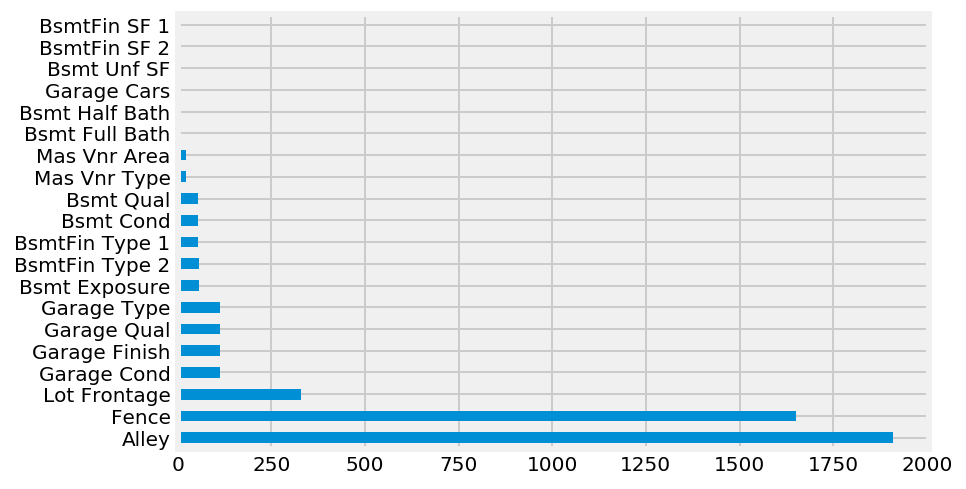

In [72]:
df_sum_null.plot(kind='barh'); #visualization of the number of nulls to be dealt with in the feature space..

Since there is a significant number of null values for both ```Fence``` and ```Alley```- ~93.2% and ~80% respectively, they will be removed from the dataframe since no reasonable conclusions can be drawn from such variables even if imputation is done. The only way around this is to find out the actual values for these missing data-collecting more data!

In [73]:
df=df.drop(['Alley','Fence'],axis=1) #dropping alley and fence features.

In [74]:
df_sum_null = df.isnull().sum().sort_values(ascending=False) #filtering for features with null values in the dataframe..

In [75]:
df_sum_null = df_sum_null[df_sum_null!=0]
df_sum_null #re-creating a separate dataframe on nulls for analysis, minus Fence and Alley

Lot Frontage      330
Garage Qual       114
Garage Finish     114
Garage Cond       114
Garage Type       113
Bsmt Exposure      58
BsmtFin Type 2     56
BsmtFin Type 1     55
Bsmt Cond          55
Bsmt Qual          55
Mas Vnr Type       22
Mas Vnr Area       22
Bsmt Half Bath      2
Bsmt Full Bath      2
Garage Cars         1
BsmtFin SF 1        1
Bsmt Unf SF         1
BsmtFin SF 2        1
dtype: int64

In [76]:
dict_sum_null = df_sum_null.to_dict() #converting pd.Series object into dict for manipulation subsequently
dict_sum_null

{'Lot Frontage': 330,
 'Garage Qual': 114,
 'Garage Finish': 114,
 'Garage Cond': 114,
 'Garage Type': 113,
 'Bsmt Exposure': 58,
 'BsmtFin Type 2': 56,
 'BsmtFin Type 1': 55,
 'Bsmt Cond': 55,
 'Bsmt Qual': 55,
 'Mas Vnr Type': 22,
 'Mas Vnr Area': 22,
 'Bsmt Half Bath': 2,
 'Bsmt Full Bath': 2,
 'Garage Cars': 1,
 'BsmtFin SF 1': 1,
 'Bsmt Unf SF': 1,
 'BsmtFin SF 2': 1}

/Users/jasonchia/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jasonchia/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


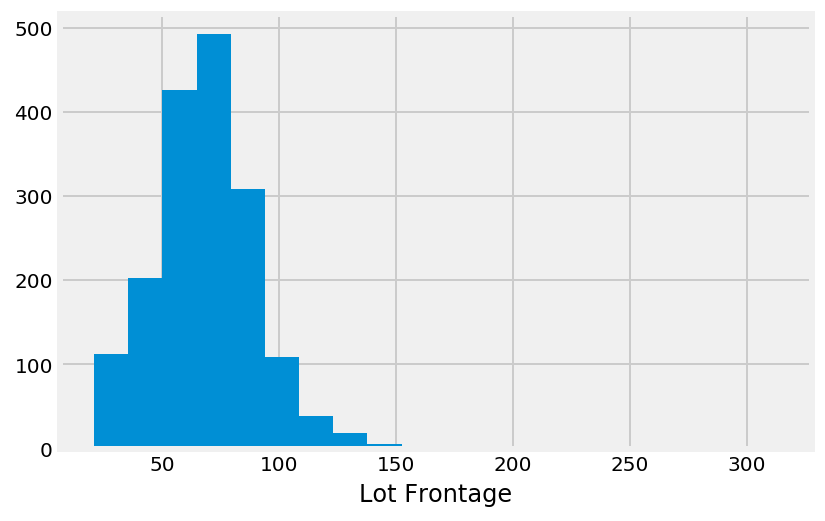

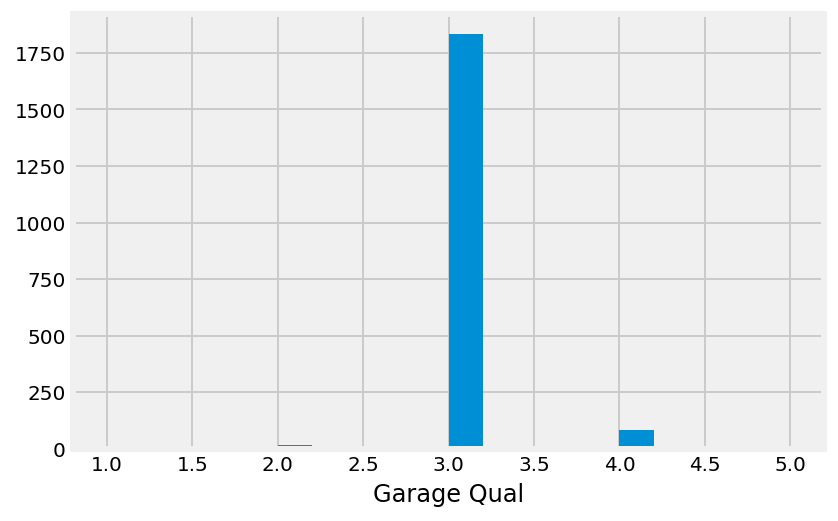

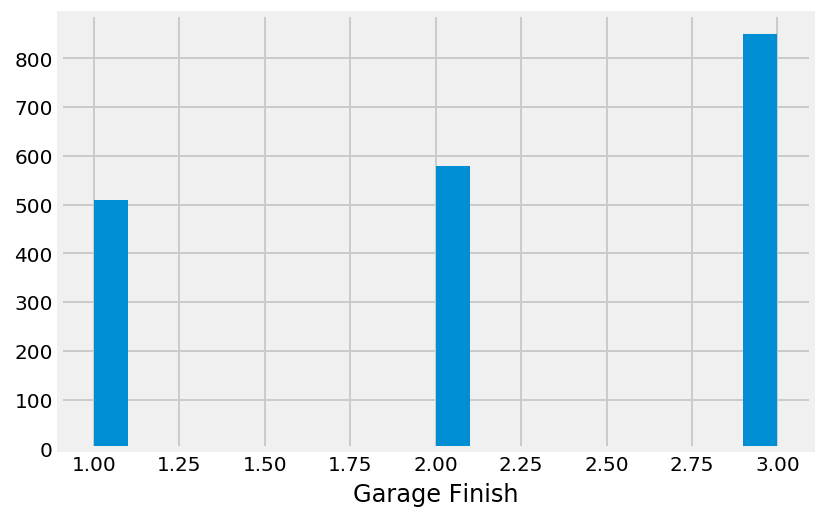

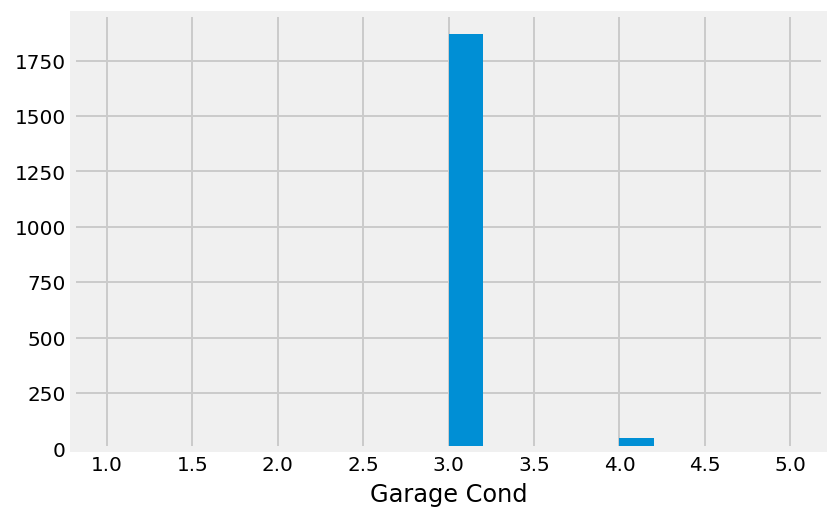

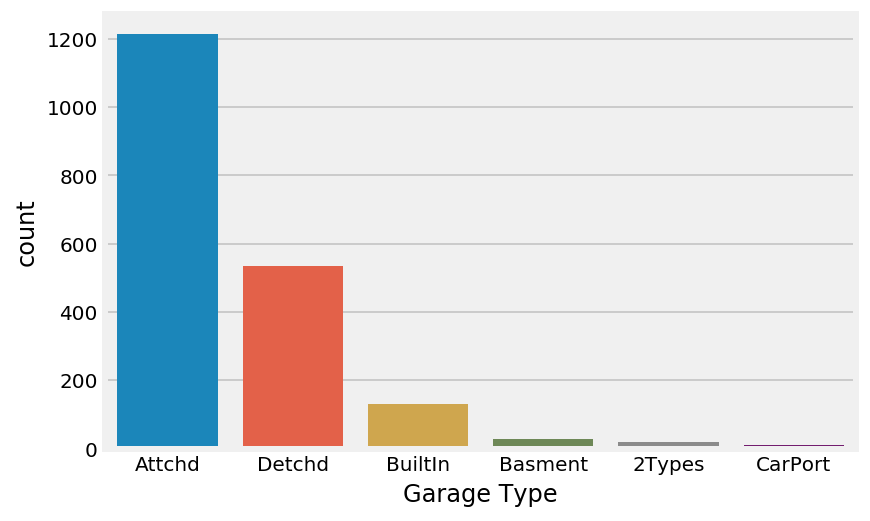

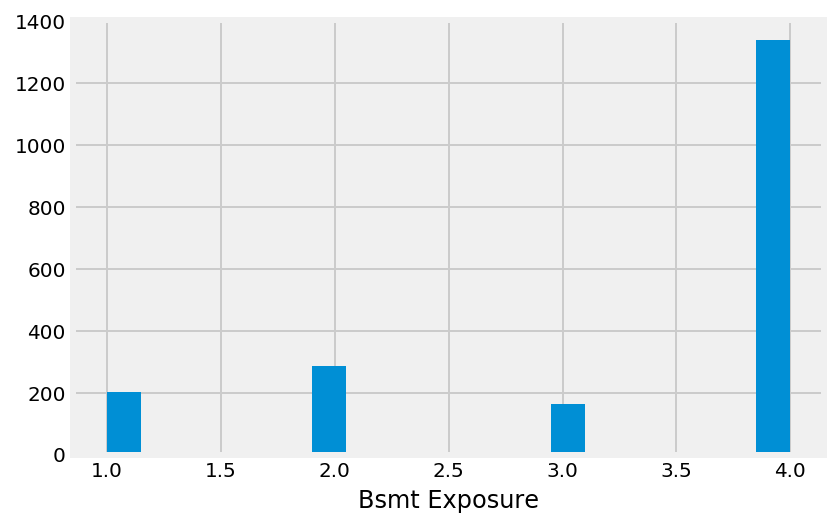

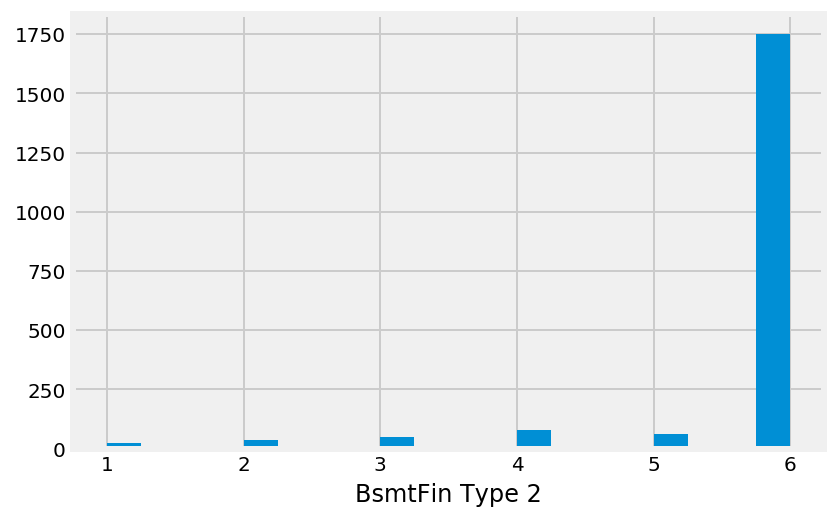

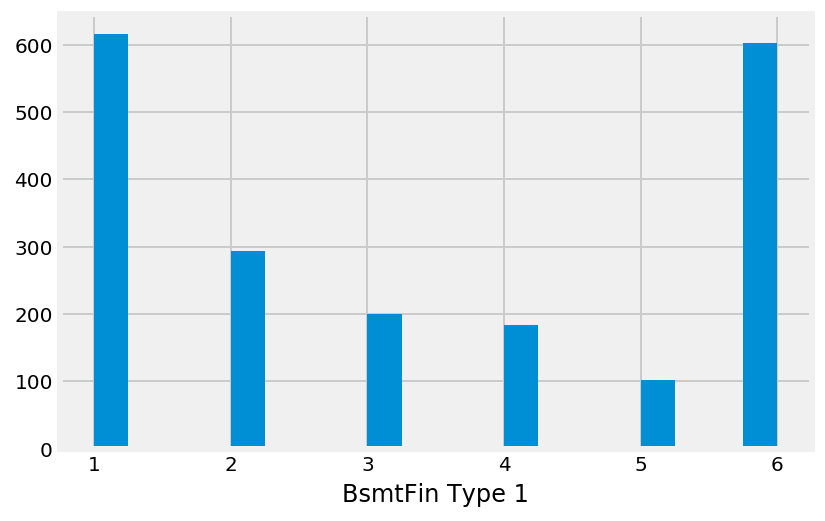

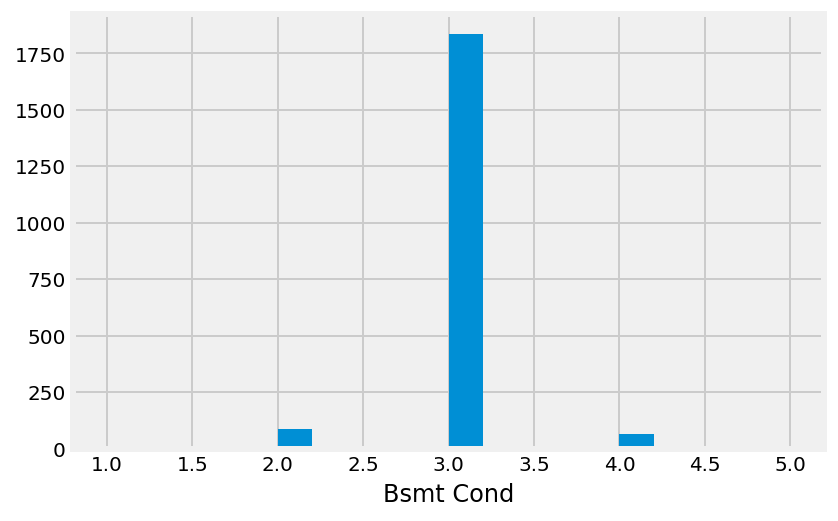

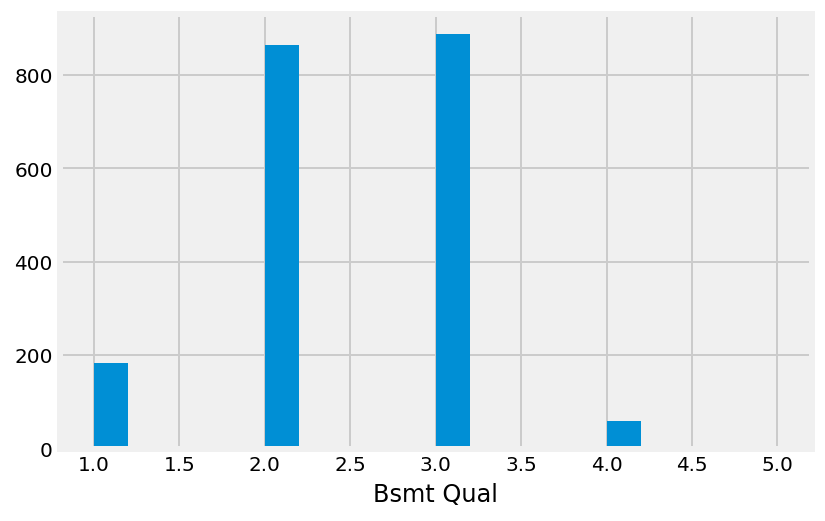

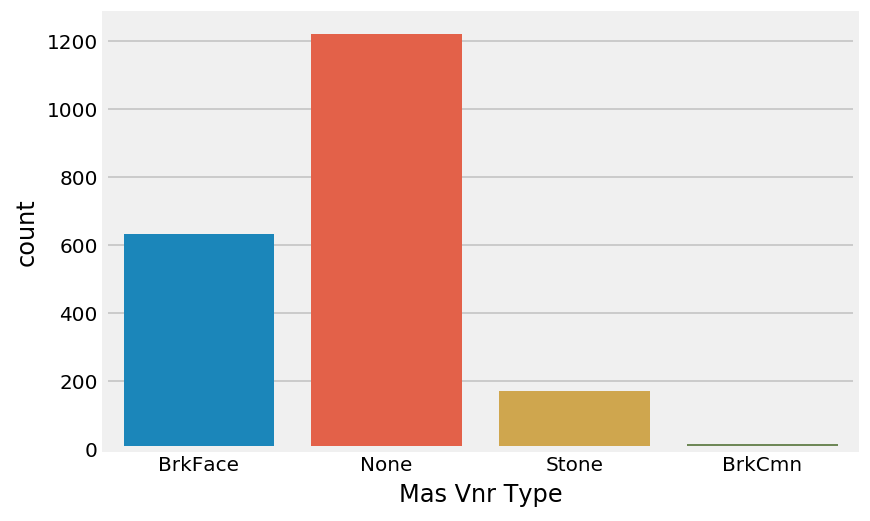

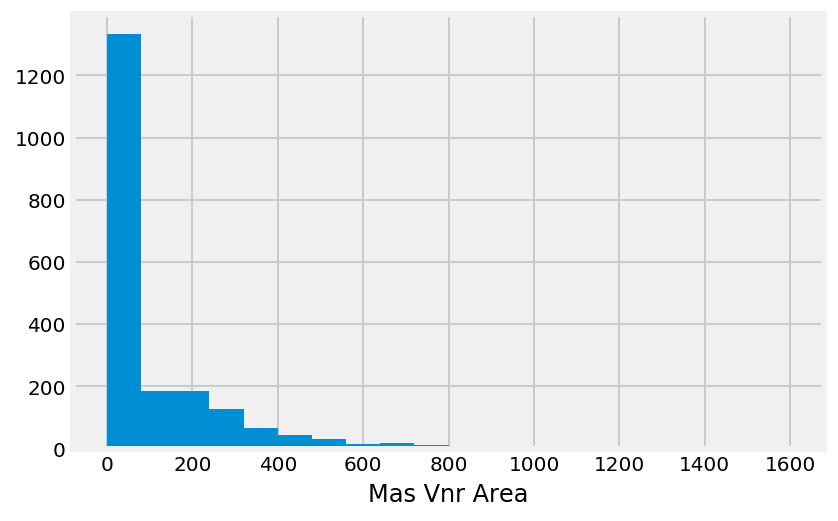

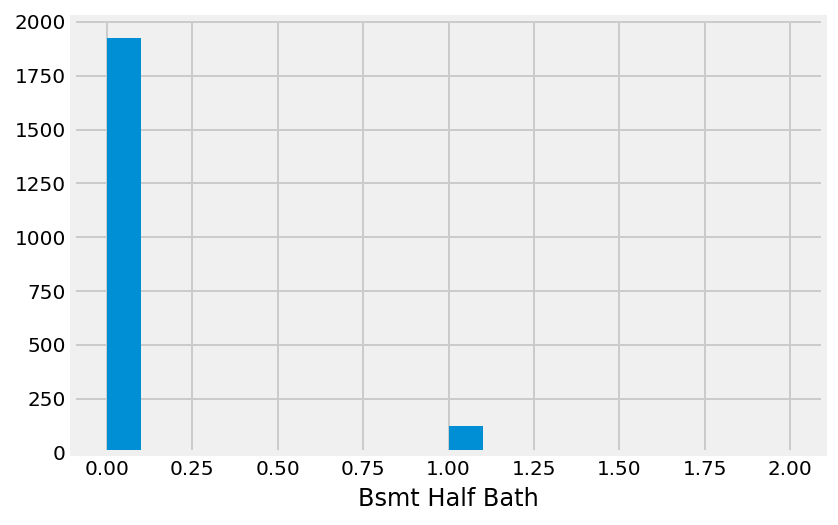

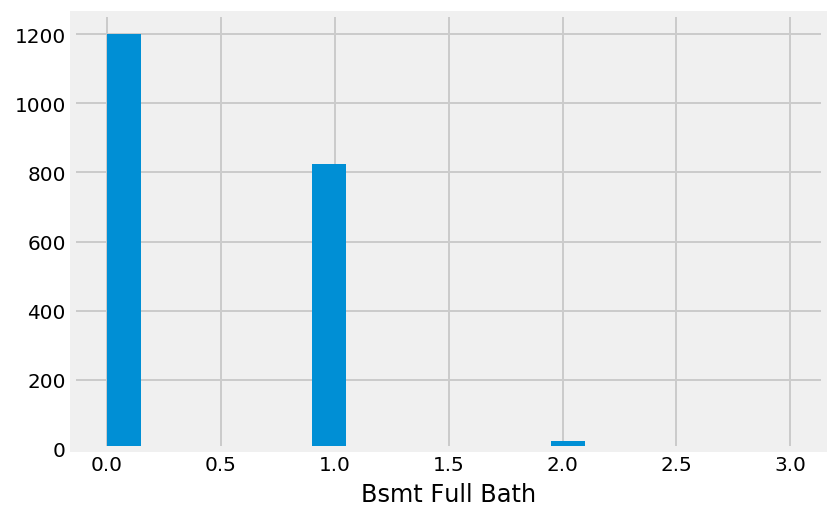

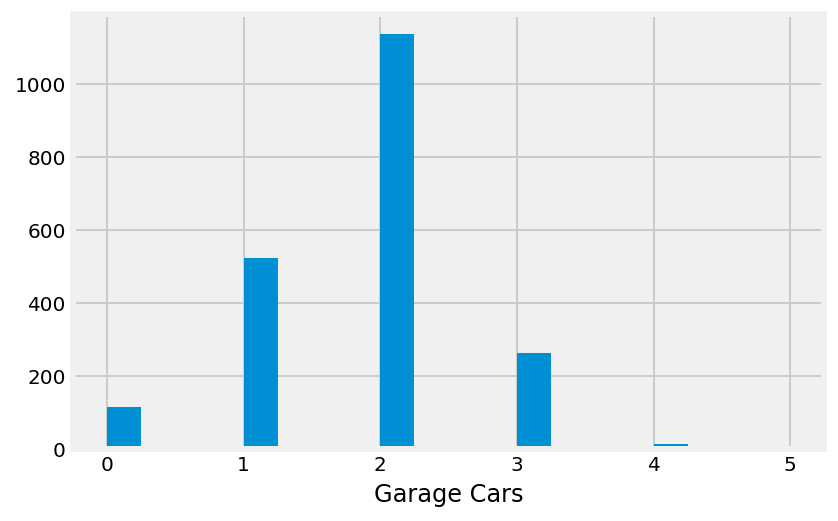

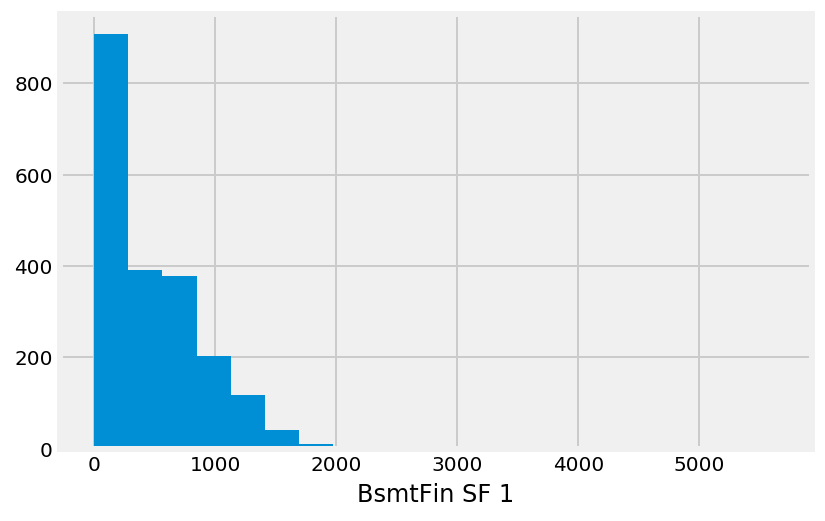

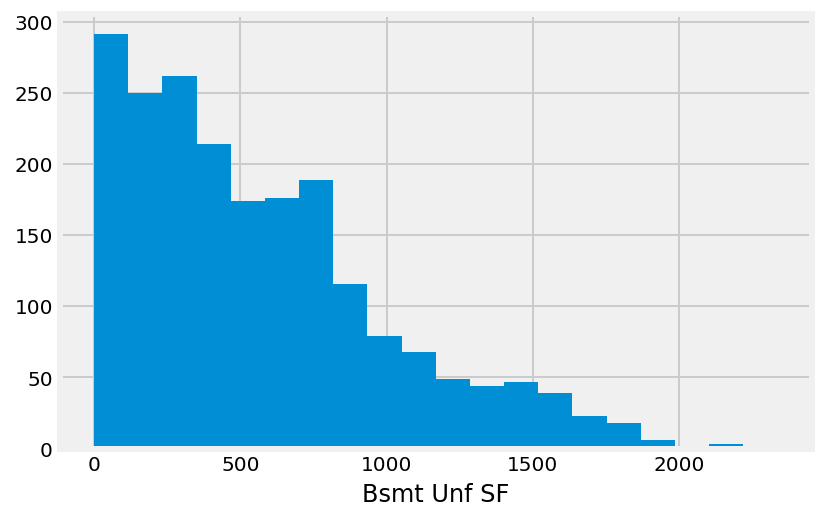

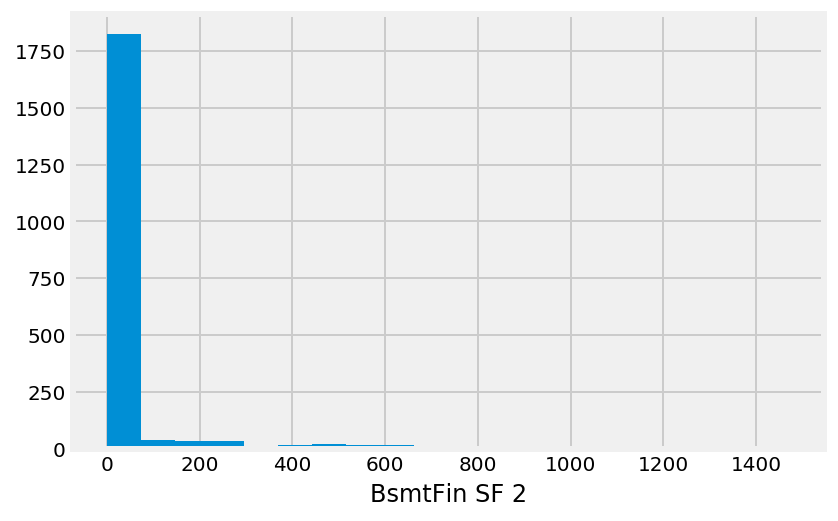

In [77]:
for i, col in enumerate(dict_sum_null.keys()): #Shows the countplots of categorical variables and histograms of numerical variables with null values
    if df[col].dtypes=='object':
        plt.figure(i)
        sns.countplot(x=col, data=df)
    else:
        plt.figure(i)
        plt.hist(df[col],bins=20)
        plt.xlabel(col)

For ```Lot Frontage```, a numerical feature, ```NaN```s will be dealt with by mean imputation via ```SimpleImputer``` since based on the histogram, it appears rather normally-distributed albeit with a small right tail.

In [78]:
df['Lot Frontage'].isnull().sum() #confirming number of nulls for column.

330

In [79]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean') #Imputing with mean.
imp.fit(df['Lot Frontage'].values.reshape(-1,1))
df['Lot Frontage']=imp.transform(df['Lot Frontage'].values.reshape(-1,1)) #Transforming to specified column.

In [80]:
df['Lot Frontage'].isnull().sum() #imputation done!

0

```Garage Qual``` is ordinal - ```NaN```s will be dealt with by mode/"most frequent" imputation.

In [81]:
df['Garage Qual'].isnull().sum() #confirming number of nulls for column.

114

In [82]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Imputing with most frequent.
imp.fit(df['Garage Qual'].values.reshape(-1,1))
df['Garage Qual']=imp.transform(df['Garage Qual'].values.reshape(-1,1)) #Transforming to specified column.

In [83]:
df['Garage Qual'].isnull().sum() #imputation done!

0

In [84]:
df['Garage Qual']=df['Garage Qual'].astype(int) #converting it to integers since it is ordinal.

In [85]:
df['Garage Qual'].dtypes #confirming it is in integer format.

dtype('int64')

```Garage Finish``` is ordinal - NaNs will be dealt with by mode/"most frequent" imputation.

In [86]:
df['Garage Finish'].isnull().sum() #confirming number of nulls for column.

114

In [87]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Imputing with most frequent.
imp.fit(df['Garage Finish'].values.reshape(-1,1))
df['Garage Finish']=imp.transform(df['Garage Finish'].values.reshape(-1,1)) #Transforming to specified column.

In [88]:
df['Garage Finish'].isnull().sum() #imputation done!

0

In [89]:
df['Garage Finish']=df['Garage Finish'].astype(int) #converting it to integers since it is ordinal.

In [90]:
df['Garage Finish'].dtypes #confirming it is in integer format.

dtype('int64')

```Garage Cond``` is ordinal - NaNs will be dealt with by mode/"most frequent" imputation.

In [91]:
df['Garage Cond'].isnull().sum() #confirming number of nulls for column.

114

In [92]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Imputing with most frequent.
imp.fit(df['Garage Cond'].values.reshape(-1,1))
df['Garage Cond']=imp.transform(df['Garage Cond'].values.reshape(-1,1)) #Transforming to specified column.

In [93]:
df['Garage Cond'].isnull().sum() #imputation done!

0

In [94]:
df['Garage Cond']=df['Garage Cond'].astype(int) #converting it to integers since it is ordinal.

In [95]:
df['Garage Cond'].dtypes #confirming it is in integer format.

dtype('int64')

```Garage Type``` is nominal. ```NaN```s will be filled with most common value- ```Attchd``` based on countplot above.

In [96]:
df['Garage Type'].isnull().sum() #confirming number of nulls for column.

113

In [97]:
df['Garage Type'] = df['Garage Type'].fillna('Attchd') #filling NaNs..

In [98]:
df['Garage Type'].isnull().sum() #filling done!

0

```Bsmt Exposure``` is ordinal - NaNs will be dealt with by mode/"most frequent" imputation.

In [99]:
df['Bsmt Exposure'].isnull().sum() #confirming number of nulls for column.

58

In [100]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Imputing with most frequent.
imp.fit(df['Bsmt Exposure'].values.reshape(-1,1))
df['Bsmt Exposure']=imp.transform(df['Bsmt Exposure'].values.reshape(-1,1)) #Transforming to specified column

In [101]:
df['Bsmt Exposure'].isnull().sum() #imputation done!

0

In [102]:
df['Bsmt Exposure']=df['Bsmt Exposure'].astype(int) #converting it to integers since it is ordinal.

In [103]:
df['Bsmt Exposure'].dtypes #confirming it is in integer format.

dtype('int64')

```BsmtFin Type 2``` is ordinal - NaNs will be dealt with by mode/"most frequent" imputation.

In [104]:
df['BsmtFin Type 2'].isnull().sum() #confirming number of nulls for column.

56

In [105]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Imputing with most frequent.
imp.fit(df['BsmtFin Type 2'].values.reshape(-1,1))
df['BsmtFin Type 2']=imp.transform(df['BsmtFin Type 2'].values.reshape(-1,1)) #Transforming to specified column

In [106]:
df['BsmtFin Type 2'].isnull().sum() #imputation done!

0

In [107]:
df['BsmtFin Type 2']=df['BsmtFin Type 2'].astype(int) #converting it to integers since it is ordinal.

In [108]:
df['BsmtFin Type 2'].dtypes #confirming it is in integer format.

dtype('int64')

```BsmtFin Type 1``` is ordinal - NaNs will be dealt with by mode/"most frequent" imputation.

In [109]:
df['BsmtFin Type 1'].isnull().sum() #confirming number of nulls for column.

55

In [110]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Imputing with most frequent.
imp.fit(df['BsmtFin Type 1'].values.reshape(-1,1))
df['BsmtFin Type 1']=imp.transform(df['BsmtFin Type 1'].values.reshape(-1,1)) #Transforming to specified column

In [111]:
df['BsmtFin Type 1'].isnull().sum() #imputation done!

0

In [112]:
df['BsmtFin Type 1']=df['BsmtFin Type 1'].astype(int) #converting it to integers since it is ordinal.

In [113]:
df['BsmtFin Type 1'].dtypes #confirming it is in integer format.

dtype('int64')

```Bsmt Cond``` is ordinal - NaNs will be dealt with by mode/"most frequent" imputation.

In [114]:
df['Bsmt Cond'].isnull().sum() #confirming number of nulls for column.

55

In [115]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Imputing with most frequent.
imp.fit(df['Bsmt Cond'].values.reshape(-1,1))
df['Bsmt Cond']=imp.transform(df['Bsmt Cond'].values.reshape(-1,1)) #Transforming to specified column

In [116]:
df['Bsmt Cond'].isnull().sum() #imputation done!

0

In [117]:
df['Bsmt Cond']=df['Bsmt Cond'].astype(int) #converting it to integers since it is ordinal.

In [118]:
df['Bsmt Cond'].dtypes #confirming it is in integer format.

dtype('int64')

```Bsmt Qual``` is ordinal - NaNs will be dealt with by mode/"most frequent" imputation.

In [119]:
df['Bsmt Qual'].isnull().sum() #confirming number of nulls for column.

55

In [120]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Imputing with most frequent.
imp.fit(df['Bsmt Qual'].values.reshape(-1,1))
df['Bsmt Qual']=imp.transform(df['Bsmt Qual'].values.reshape(-1,1)) #Transforming to specified column

In [121]:
df['Bsmt Qual'].isnull().sum() #imputation done!

0

In [122]:
df['Bsmt Qual']=df['Bsmt Qual'].astype(int) #converting it to integers since it is ordinal.

In [123]:
df['Bsmt Qual'].dtypes #confirming it is in integer format.

dtype('int64')

```Mas Vnr Type``` is nominal. NaNs will be filled with most common value- ```None``` based on countplot above.

In [124]:
df['Mas Vnr Type'].isnull().sum() #confirming number of nulls for column.

22

In [125]:
df['Mas Vnr Type'] = df['Mas Vnr Type'].fillna('None') #filling NaNs..

In [126]:
df['Garage Type'].isnull().sum() #filling done!

0

```Mas Vnr Area``` appears right-skewed based on the above histogram. Thus, ```NaN```s will be imputed with median value.

In [127]:
df['Mas Vnr Area'].isnull().sum() #confirming number of nulls for column.

22

In [128]:
imp = SimpleImputer(missing_values=np.nan, strategy='median') #Imputing with median.
imp.fit(df['Mas Vnr Area'].values.reshape(-1,1))
df['Mas Vnr Area']=imp.transform(df['Mas Vnr Area'].values.reshape(-1,1)) #Transforming to specified column

In [129]:
df['Mas Vnr Area'].isnull().sum() #imputation done!

0

```Bsmt Half Bath``` is discrete, so most frequent imputation will be done.

In [130]:
df['Bsmt Half Bath'].isnull().sum() #confirming number of nulls for column.

2

In [131]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Imputing with most frequent.
imp.fit(df['Bsmt Half Bath'].values.reshape(-1,1))
df['Bsmt Half Bath']=imp.transform(df['Bsmt Half Bath'].values.reshape(-1,1)) #Transforming to specified column

In [132]:
df['Bsmt Half Bath'].isnull().sum() #imputation done!

0

```Bsmt Full Bath``` is discrete, so most frequent imputation will be done.

In [133]:
df['Bsmt Full Bath'].isnull().sum() #confirming number of nulls for column.

2

In [134]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Imputing with most frequent.
imp.fit(df['Bsmt Full Bath'].values.reshape(-1,1))
df['Bsmt Full Bath']=imp.transform(df['Bsmt Full Bath'].values.reshape(-1,1)) #Transforming to specified column

In [135]:
df['Bsmt Full Bath'].isnull().sum() #imputation done!

0

```Garage Cars``` is discrete, so most frequent imputation will be done.

In [136]:
df['Garage Cars'].isnull().sum() #confirming number of nulls for column.

1

In [137]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Imputing with most frequent.
imp.fit(df['Garage Cars'].values.reshape(-1,1))
df['Garage Cars']=imp.transform(df['Garage Cars'].values.reshape(-1,1)) #Transforming to specified column

In [138]:
df['Garage Cars'].isnull().sum() #imputation done!

0

```BsmtFin SF 1``` is numerical and based on the histogram above, it appears rather right-skewed. ```NaN```s will thus be imputed by median.

In [139]:
df['BsmtFin SF 1'].isnull().sum() #confirming number of nulls for column.

1

In [140]:
imp = SimpleImputer(missing_values=np.nan, strategy='median') #Imputing with median.
imp.fit(df['BsmtFin SF 1'].values.reshape(-1,1))
df['BsmtFin SF 1']=imp.transform(df['BsmtFin SF 1'].values.reshape(-1,1)) #Transforming to specified column

In [141]:
df['BsmtFin SF 1'].isnull().sum() #imputation done!

0

```Bsmt Unf SF``` is numerical and based on the histogram above, it appears rather right-skewed. NaNs will thus be imputed by median.

In [142]:
df['Bsmt Unf SF'].isnull().sum() #confirming number of nulls for column.

1

In [143]:
imp = SimpleImputer(missing_values=np.nan, strategy='median') #Imputing with median.
imp.fit(df['Bsmt Unf SF'].values.reshape(-1,1))
df['Bsmt Unf SF']=imp.transform(df['Bsmt Unf SF'].values.reshape(-1,1)) #Transforming to specified column

In [144]:
df['Bsmt Unf SF'].isnull().sum() #imputation done!

0

```BsmtFin SF 2``` is numerical and based on the histogram above, it appears rather right-skewed. NaNs will thus be imputed by median.



In [145]:
df['BsmtFin SF 2'].isnull().sum() #confirming number of nulls for column.

1

In [146]:
imp = SimpleImputer(missing_values=np.nan, strategy='median') #Imputing with median.
imp.fit(df['BsmtFin SF 2'].values.reshape(-1,1))
df['BsmtFin SF 2']=imp.transform(df['BsmtFin SF 2'].values.reshape(-1,1)) #Transforming to specified column

In [147]:
df['BsmtFin SF 2'].isnull().sum() #imputation done!

0

Checking the various previously-null-containing data types' distributions, after imputations...

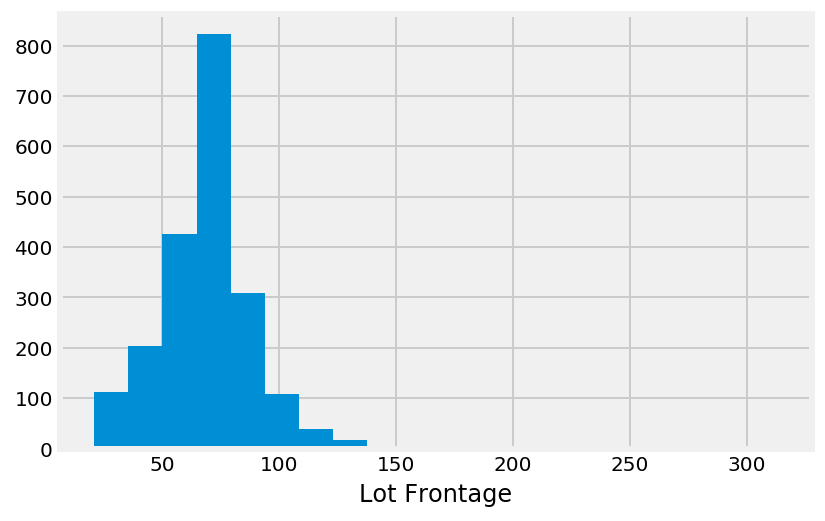

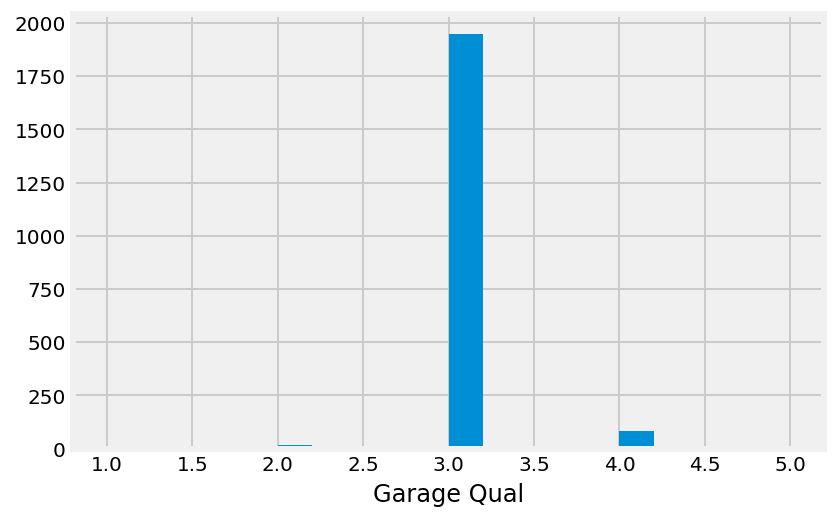

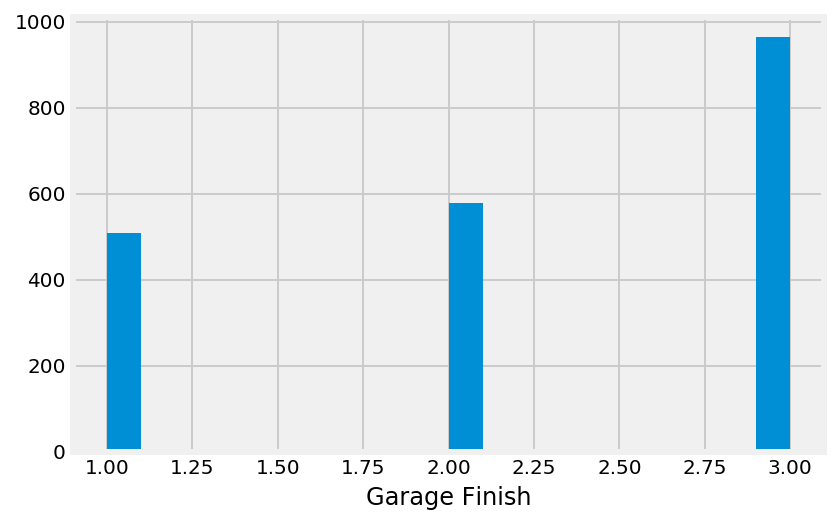

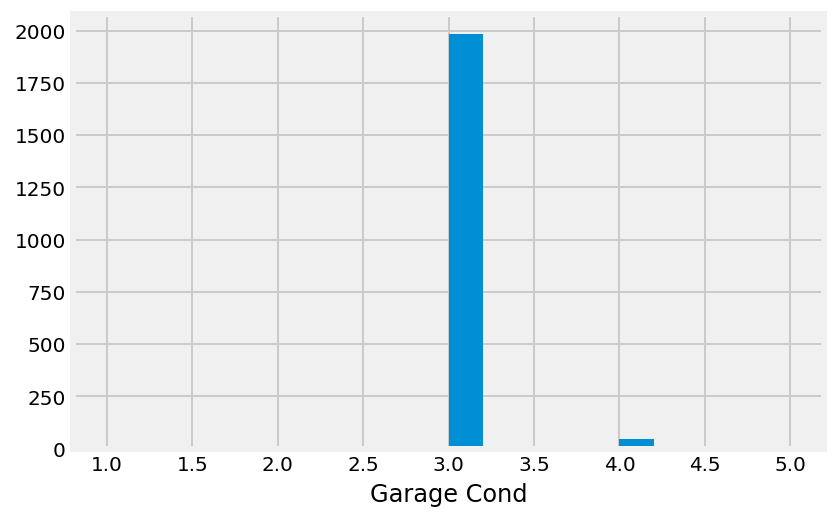

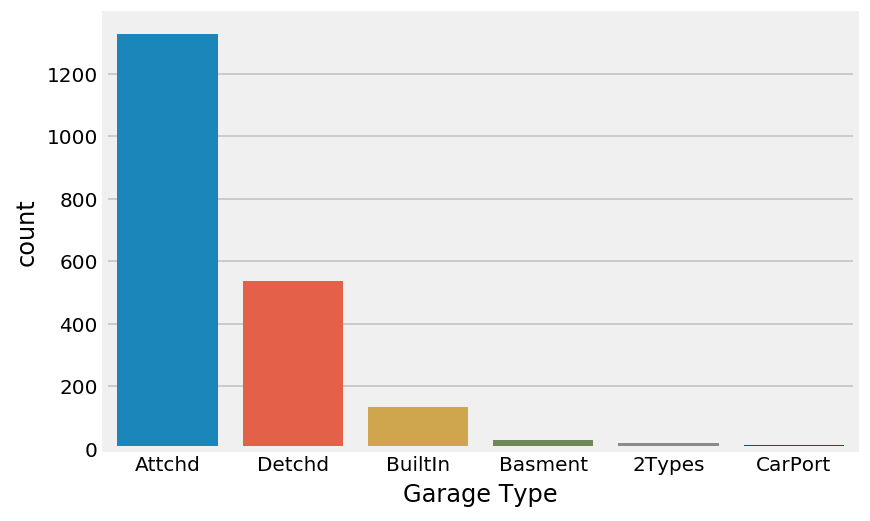

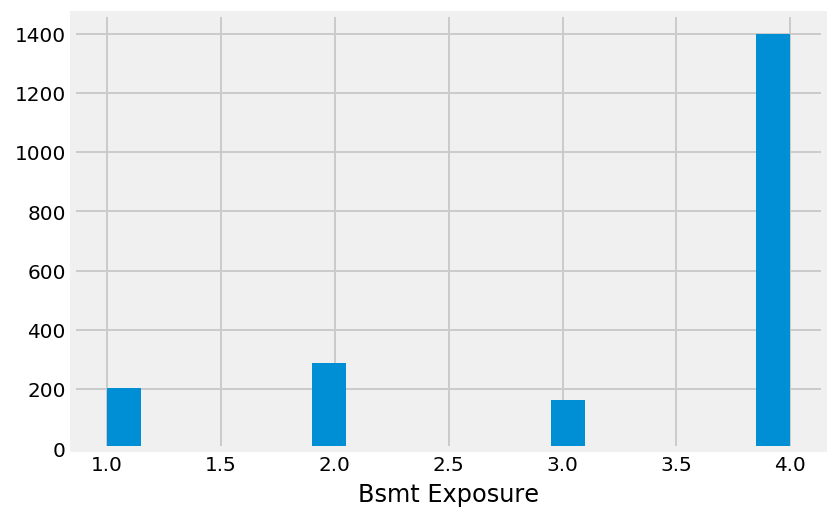

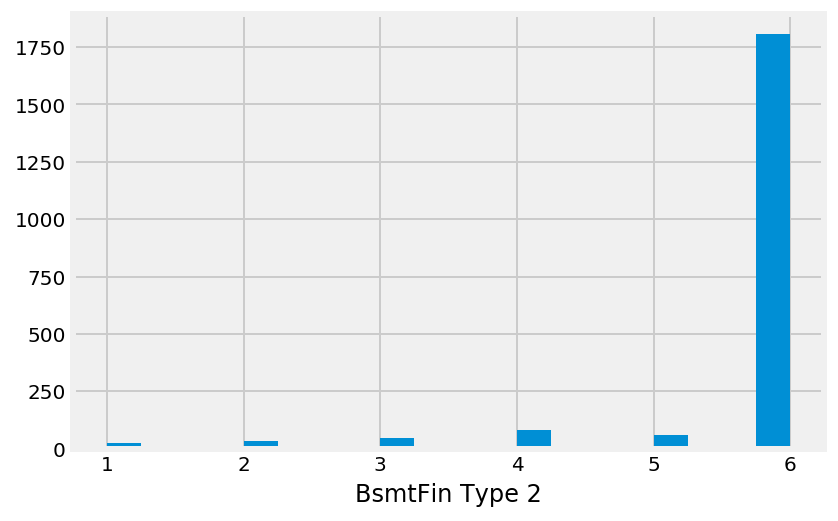

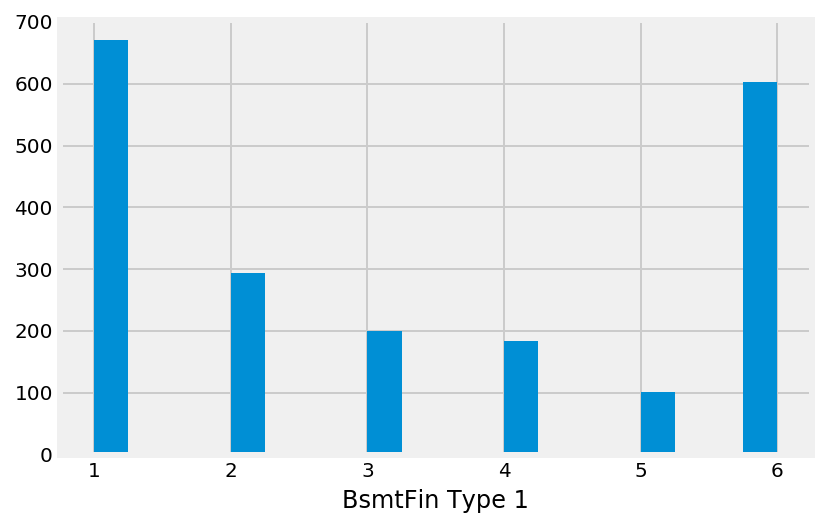

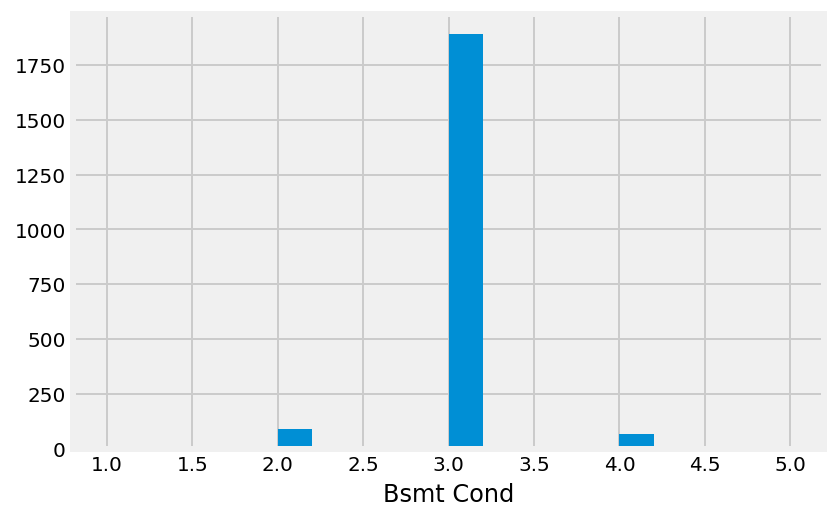

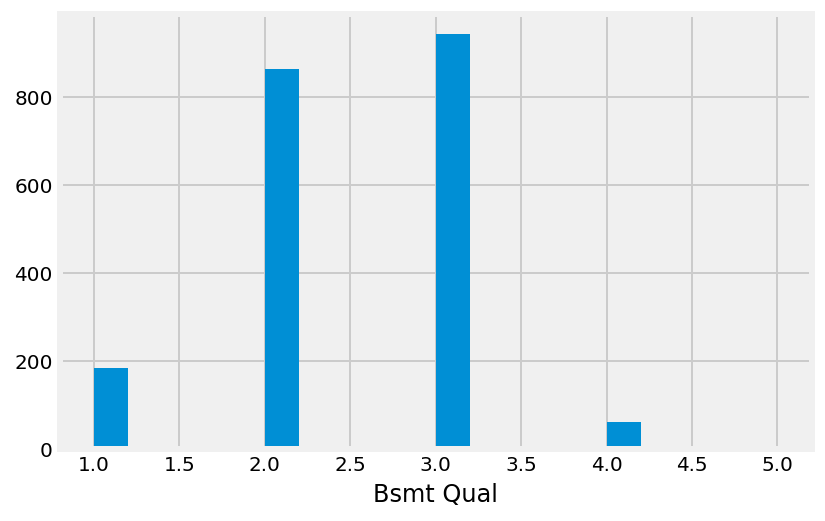

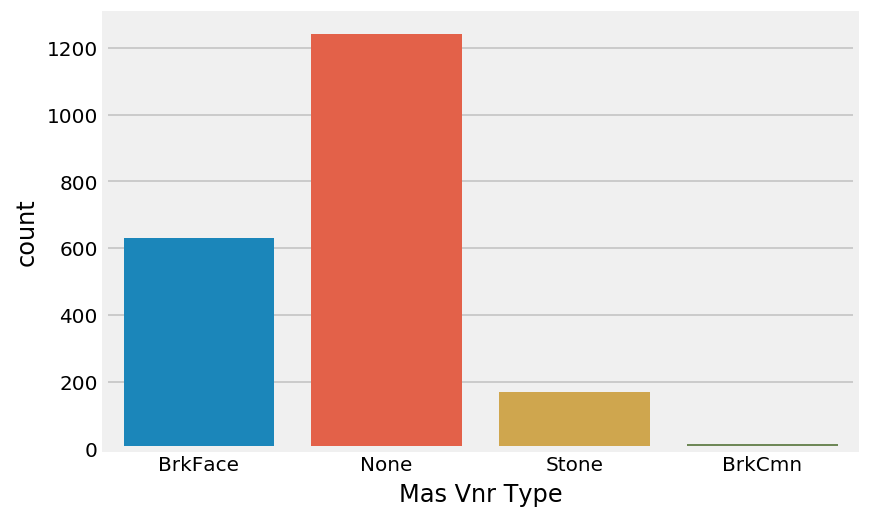

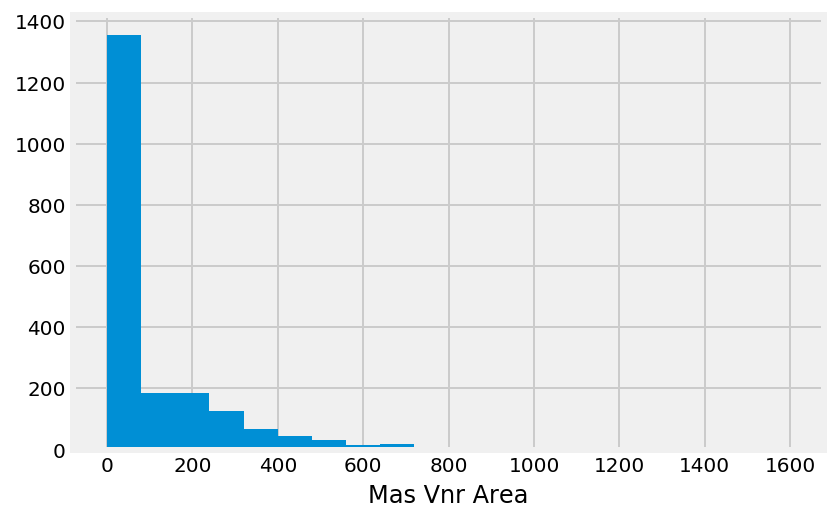

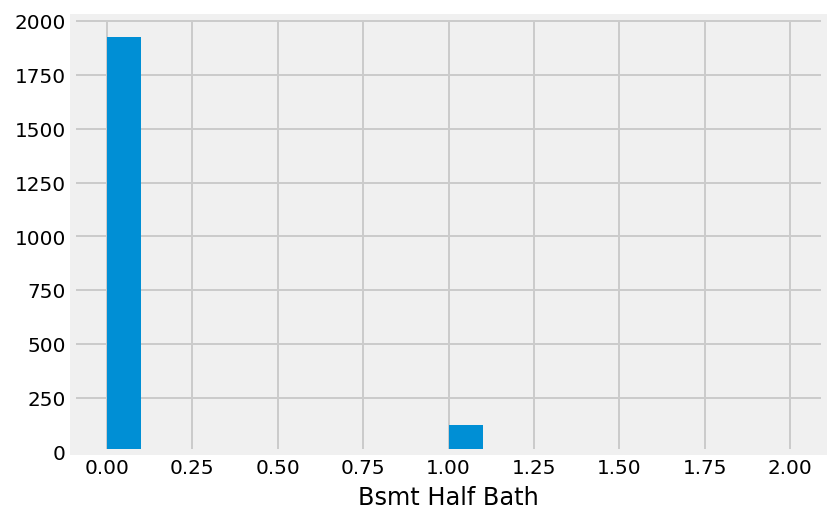

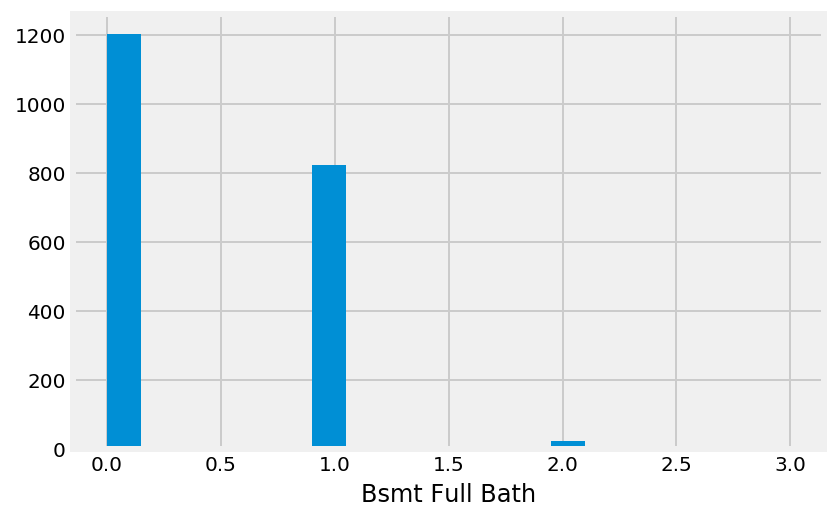

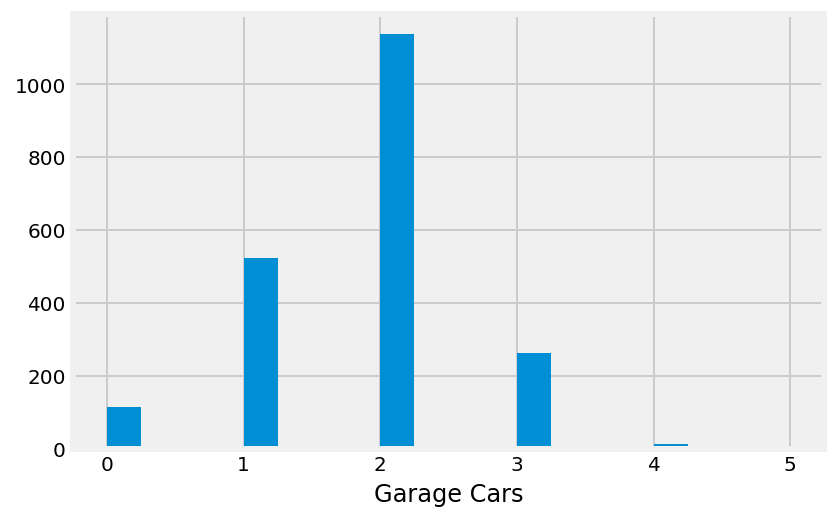

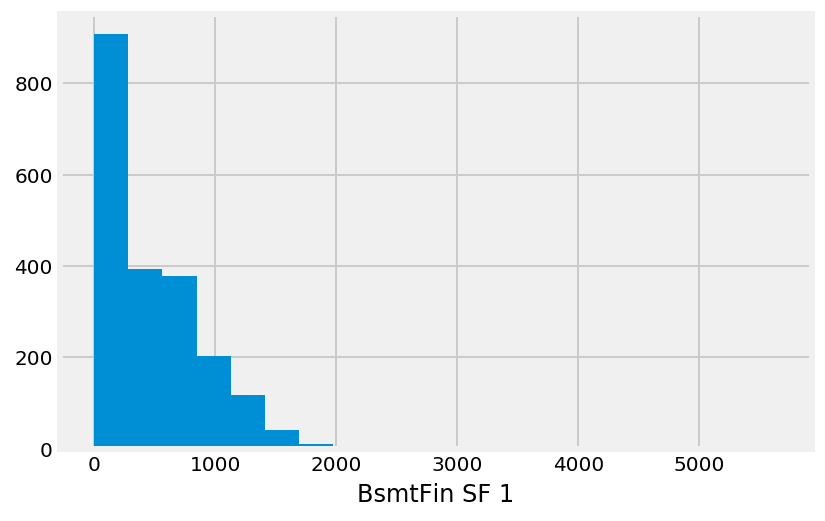

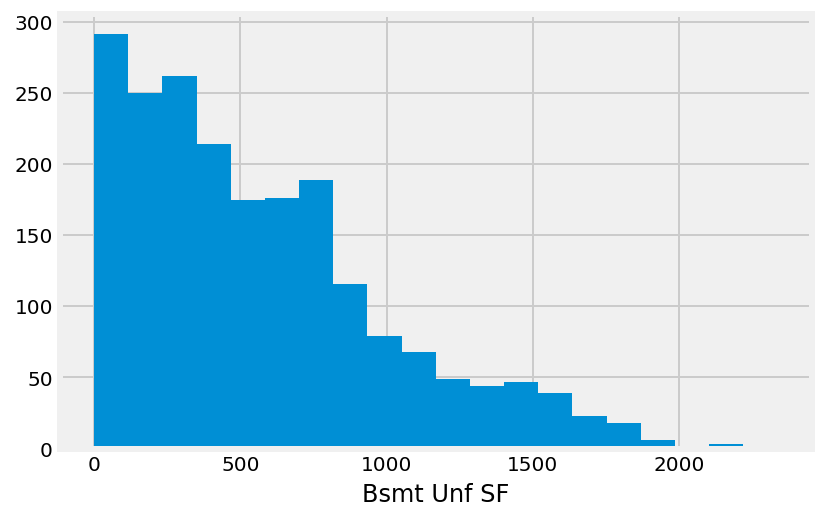

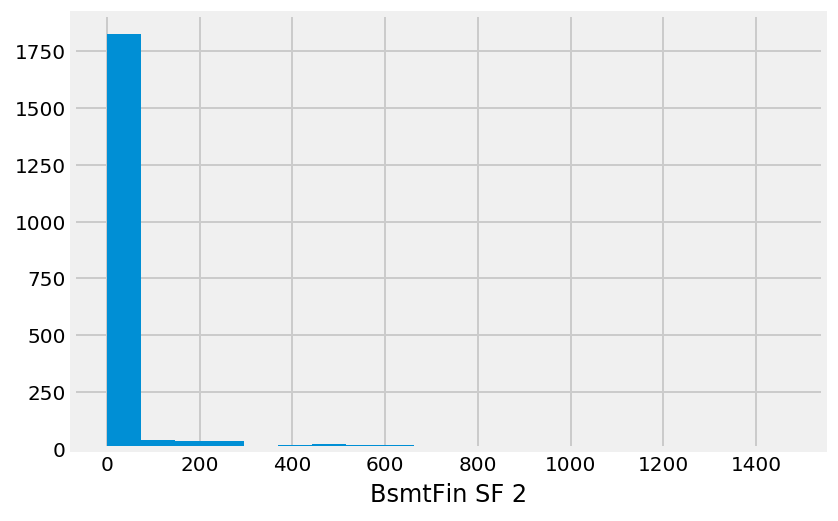

In [148]:
for i, col in enumerate(dict_sum_null.keys()): #Shows the countplots of categorical variables and histograms of numerical variables that used to have null values
    if df[col].dtypes=='object':
        plt.figure(i)
        sns.countplot(x=col, data=df)
    else:
        plt.figure(i)
        plt.hist(df[col],bins=20)
        plt.xlabel(col)

As expected, the distributions of the various predictors with their ```NaN```s imputed with mean, median, or mode/most frequent now have sharper peaks. This is can constitute a potential pitfall for target prediction since "educated guesses" have been made to fill missing data points.

In [149]:
df.info() #Cleaned dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   object 
 2   MS SubClass      2051 non-null   object 
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     2051 non-null   float64
 5   Lot Area         2051 non-null   float64
 6   Street           2051 non-null   object 
 7   Lot Shape        2051 non-null   int64  
 8   Land Contour     2051 non-null   object 
 9   Utilities        2051 non-null   int64  
 10  Lot Config       2051 non-null   object 
 11  Land Slope       2051 non-null   int64  
 12  Neighborhood     2051 non-null   object 
 13  Condition 1      2051 non-null   object 
 14  Condition 2      2051 non-null   object 
 15  Bldg Type        2051 non-null   object 
 16  House Style      2051 non-null   object 
 17  Overall Qual  

## Exploratory Data Analysis
---


### 3) Exploratory Data Analysis - part 1
- Now that the datatypes have been converted accordingly and those ```NaN```s that could be corrected have been correct, let's have an initial look at the correlation of the various features with the target, ```SalePrice```. Let's begin by examining the correlation between continuous features (floats and integers) with the target.

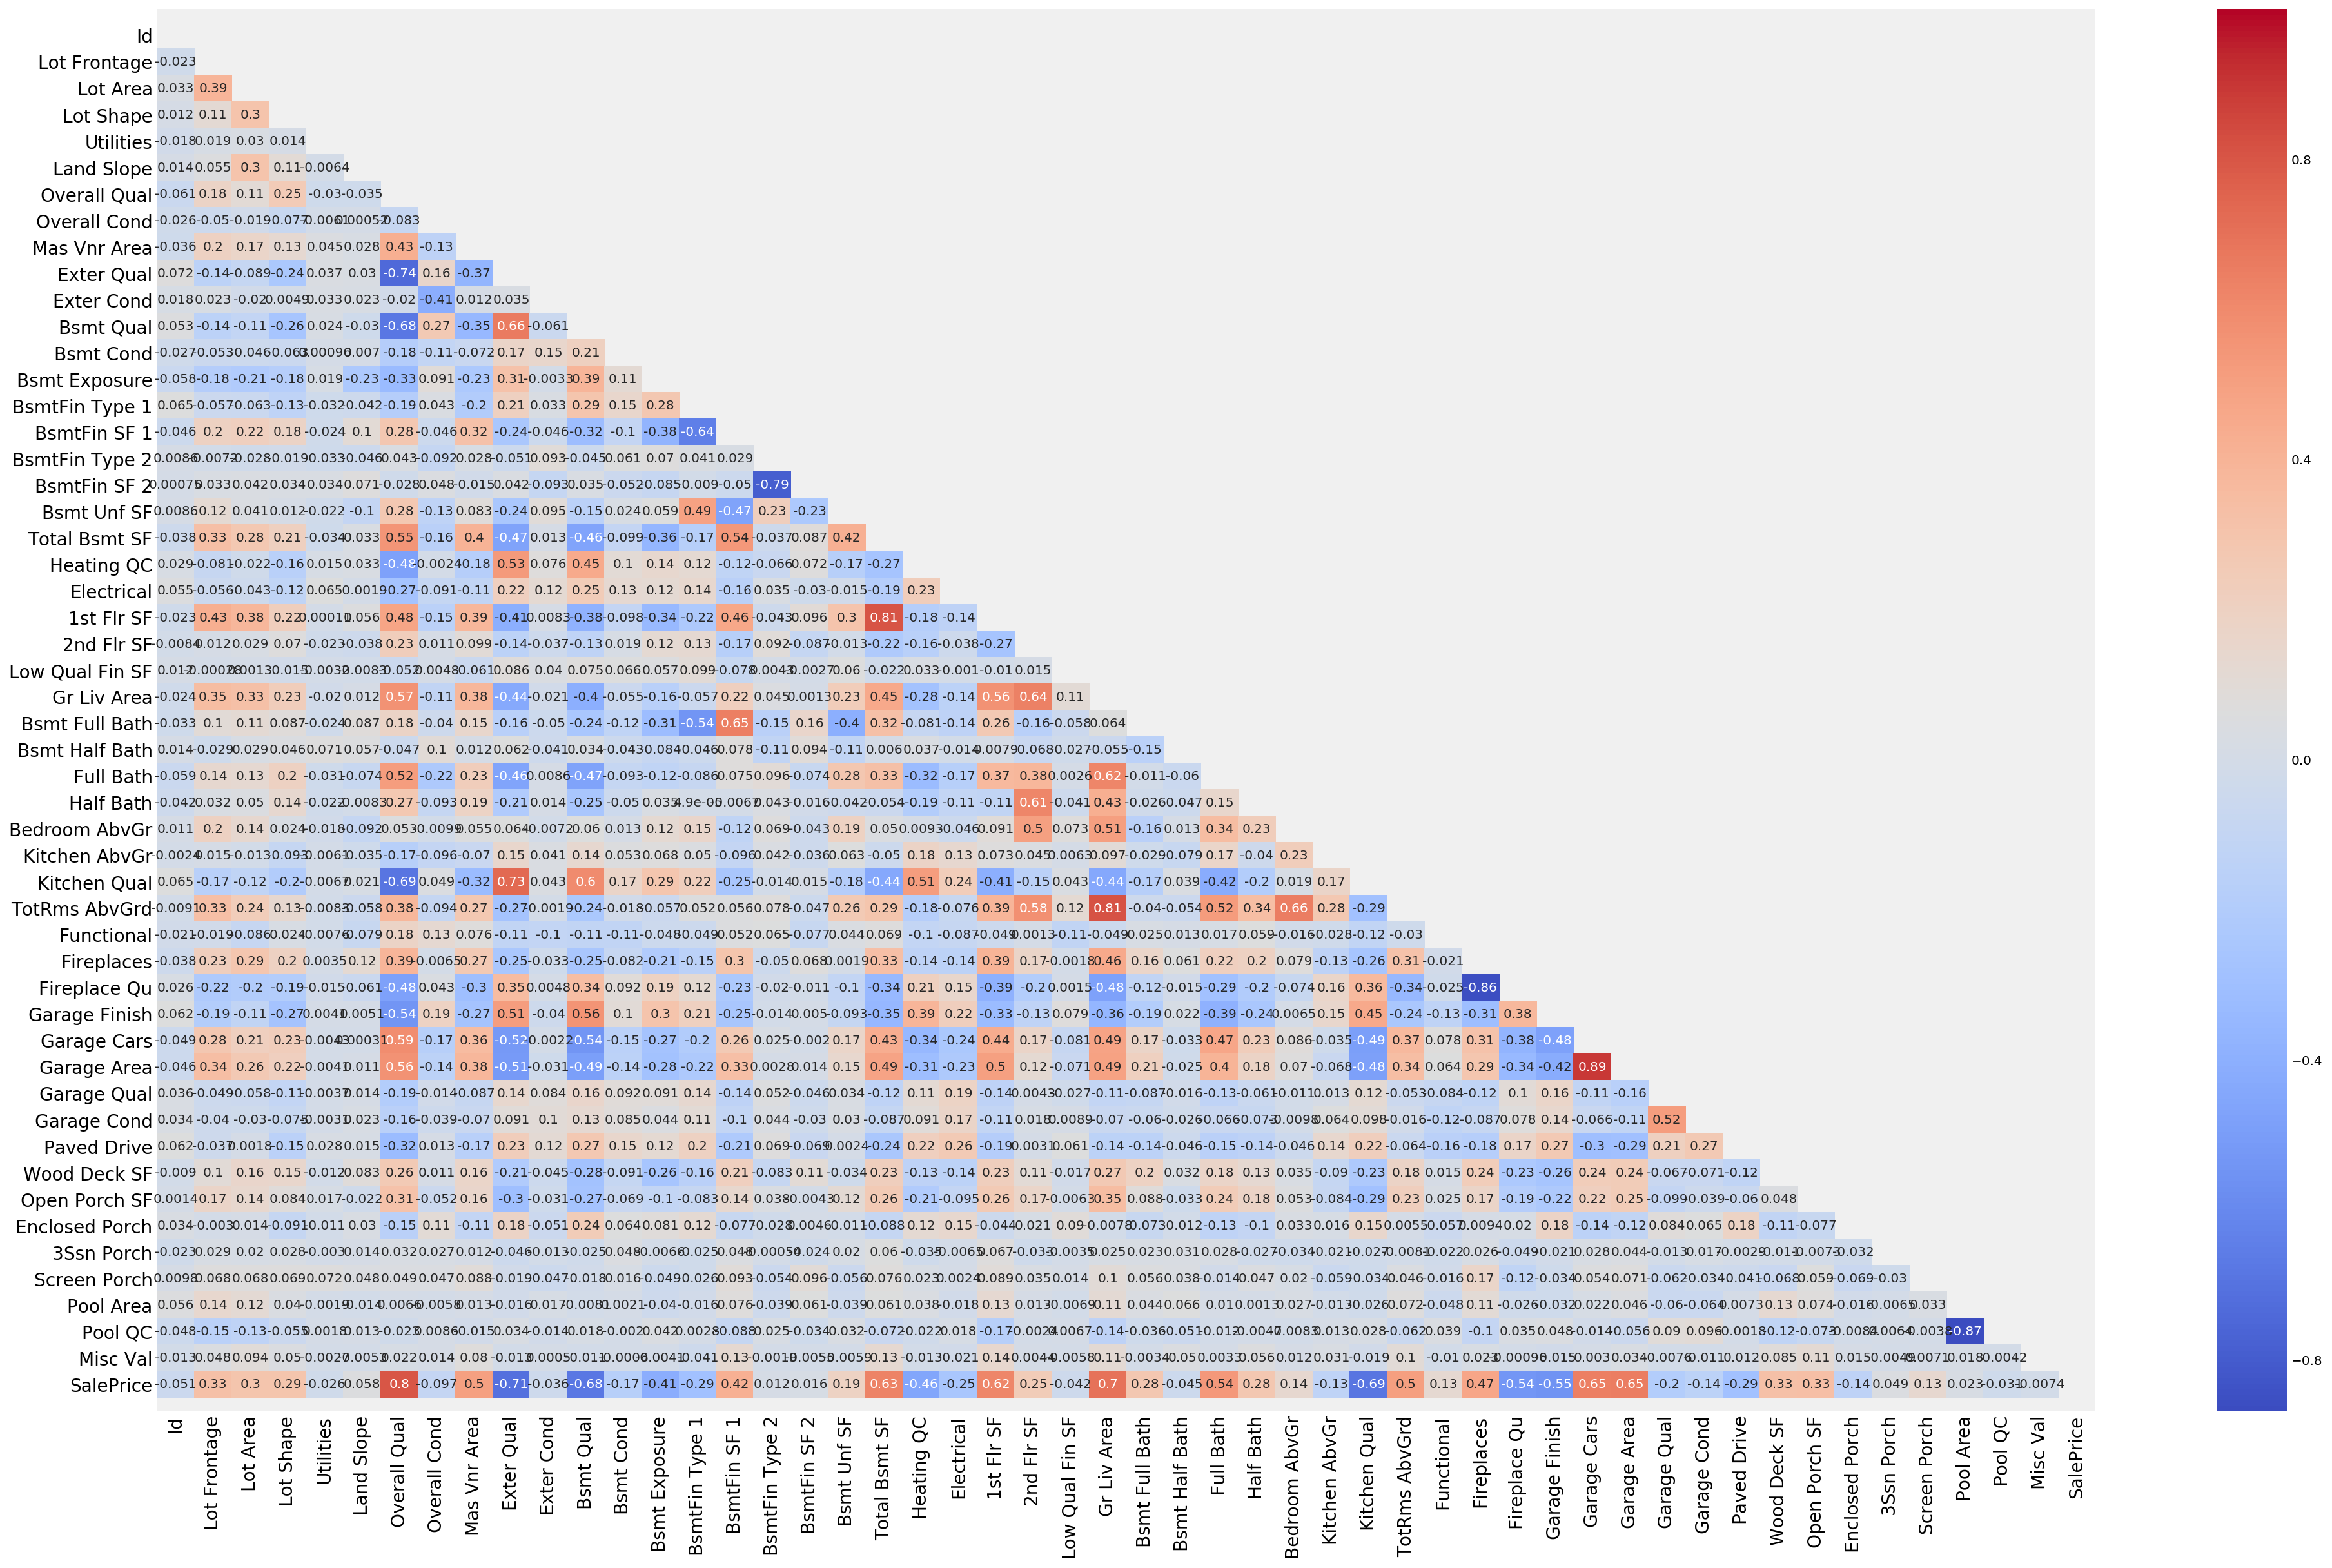

In [150]:
# Set the matplotlib figure size to 20x20:
fix, ax = plt.subplots(figsize=(30,20))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(df.corr(), mask=mask, ax=ax, annot=True, cmap='coolwarm')

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

bottom, top = ax.get_ylim()   # To center the heatmap so that all edges of it are visible.
ax.set_ylim(bottom + 0.5, top - 0.5);
plt.show()  #Finally, displaying the final heatmap plot.

From the heatmap above, it appears that Overall Quality, Ground Living Area, and Garage Area are highly correlated with sale price, with overrall quality coming up top. This is not surprising. However, all 3 predictors are correlated in some way with at least 0.50 in terms of correlation coefficient. When fitted together in the same model, they can result in multi-collinearity but this can be dealt with by regularized regression such as ```Lasso``` and so no features were selected at this juncture to be excluded - the Lasso can do the job for us.

--
### 2) Exploratory Data Analysis - part 2
- Now we shall examine the categorical features.

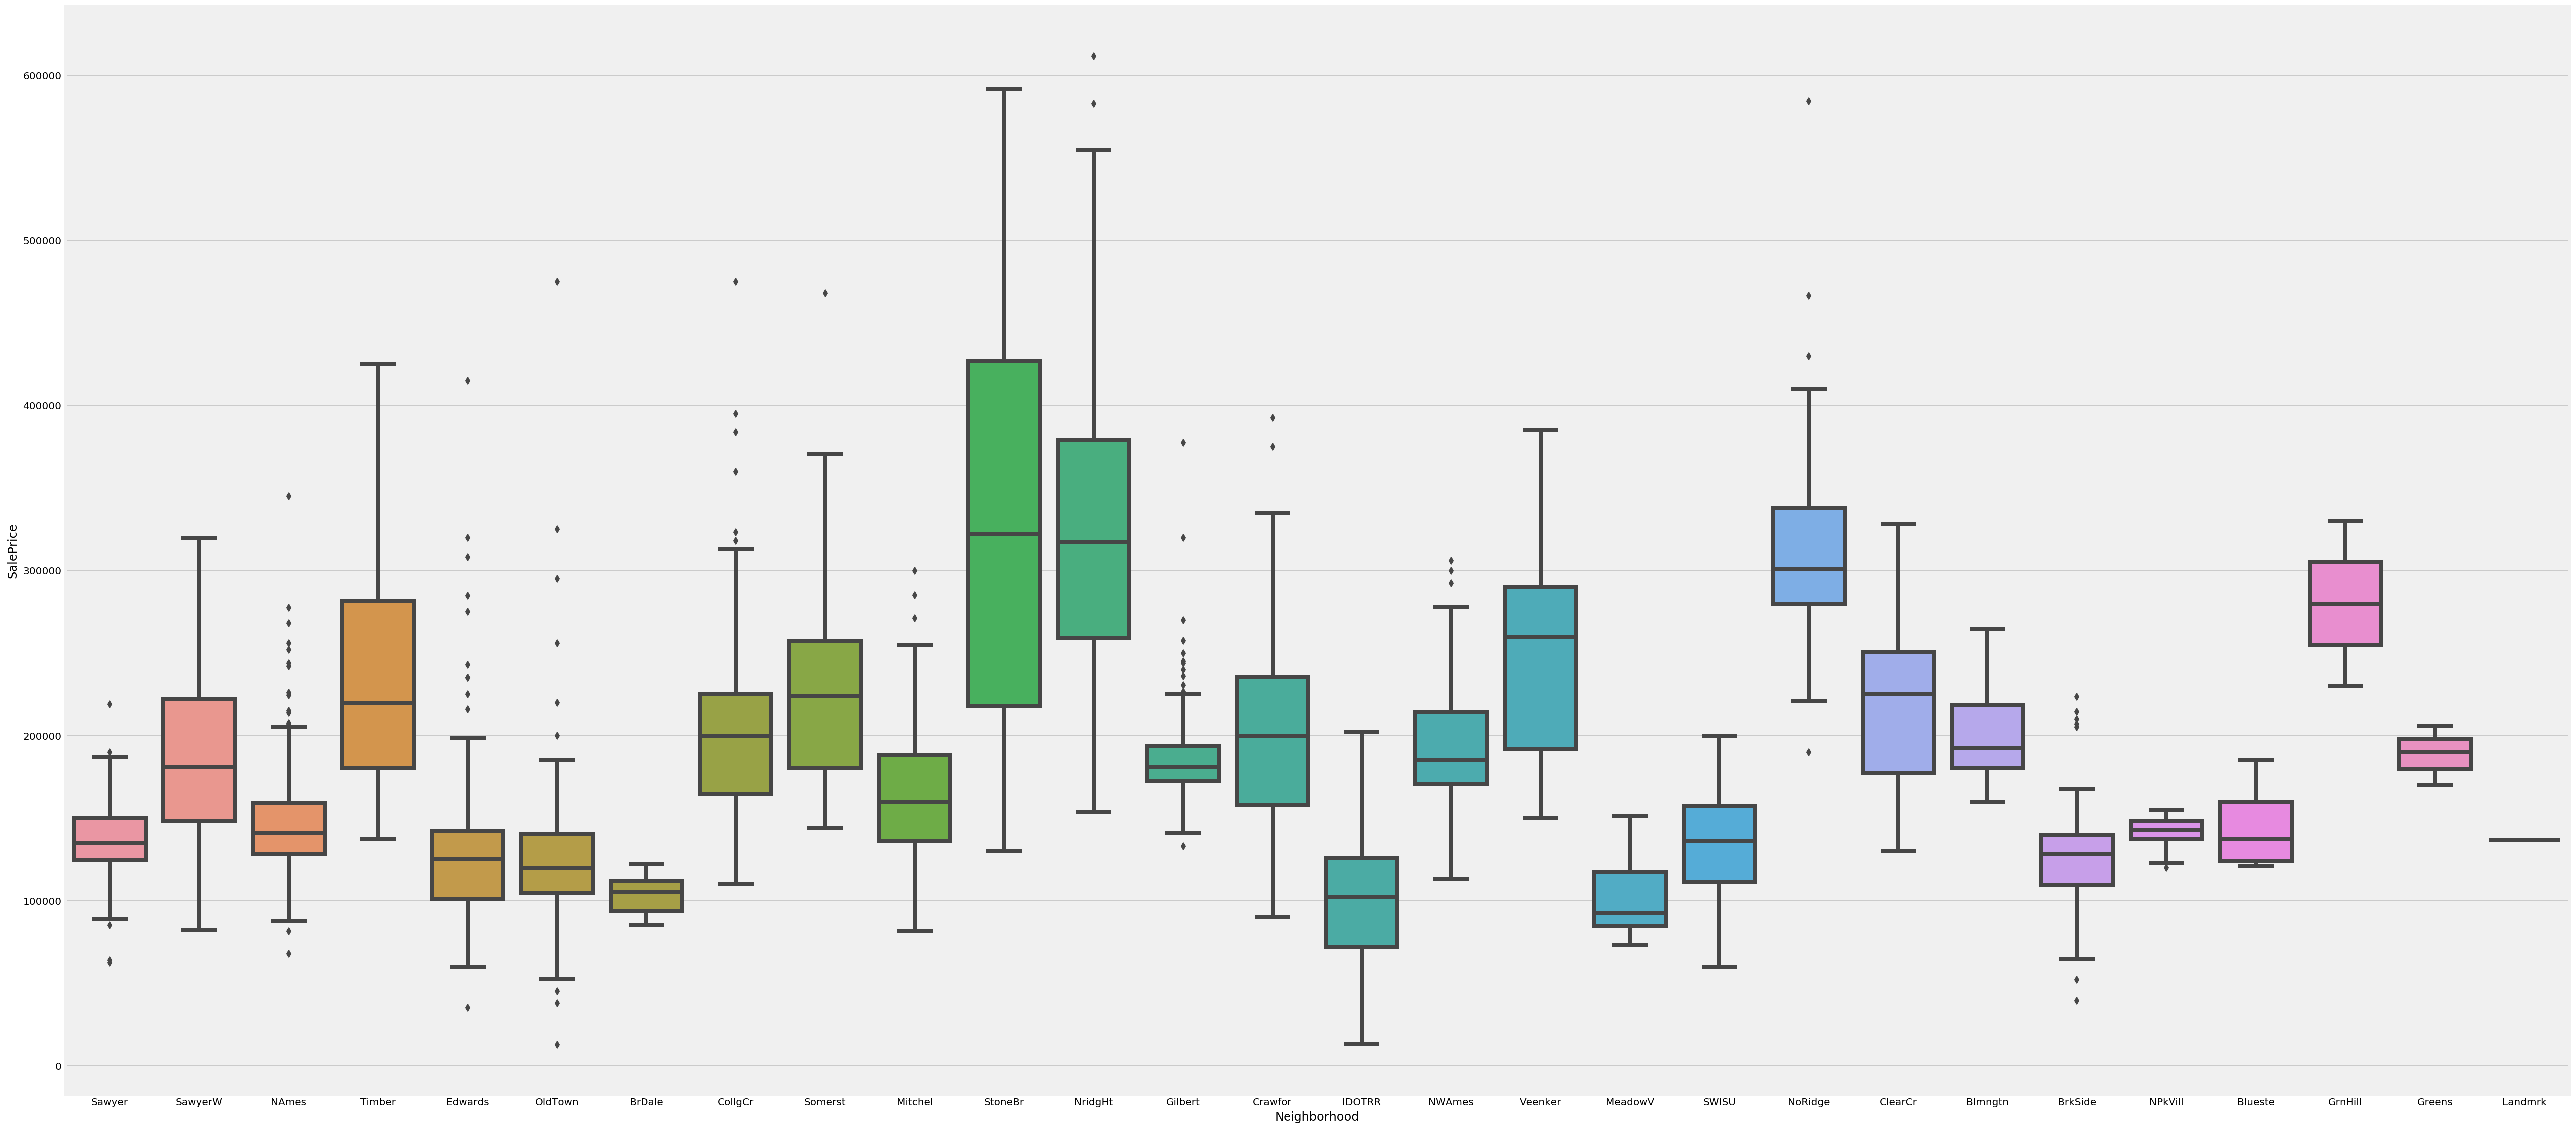

In [151]:
plt.figure(figsize=(40,20))
sns.boxplot(x = 'Neighborhood', y = 'SalePrice', data=df)

The above boxplot shows the varying ```SalePrice``` across 28 neighborhoods. Noticeably, ```MeadowV``` has the lowest median ```SalePrice``` at below 100 thousand dollars while ```StoneBr``` has the highest median ```SalePrice``` at beyond 300 thousand dollars. 

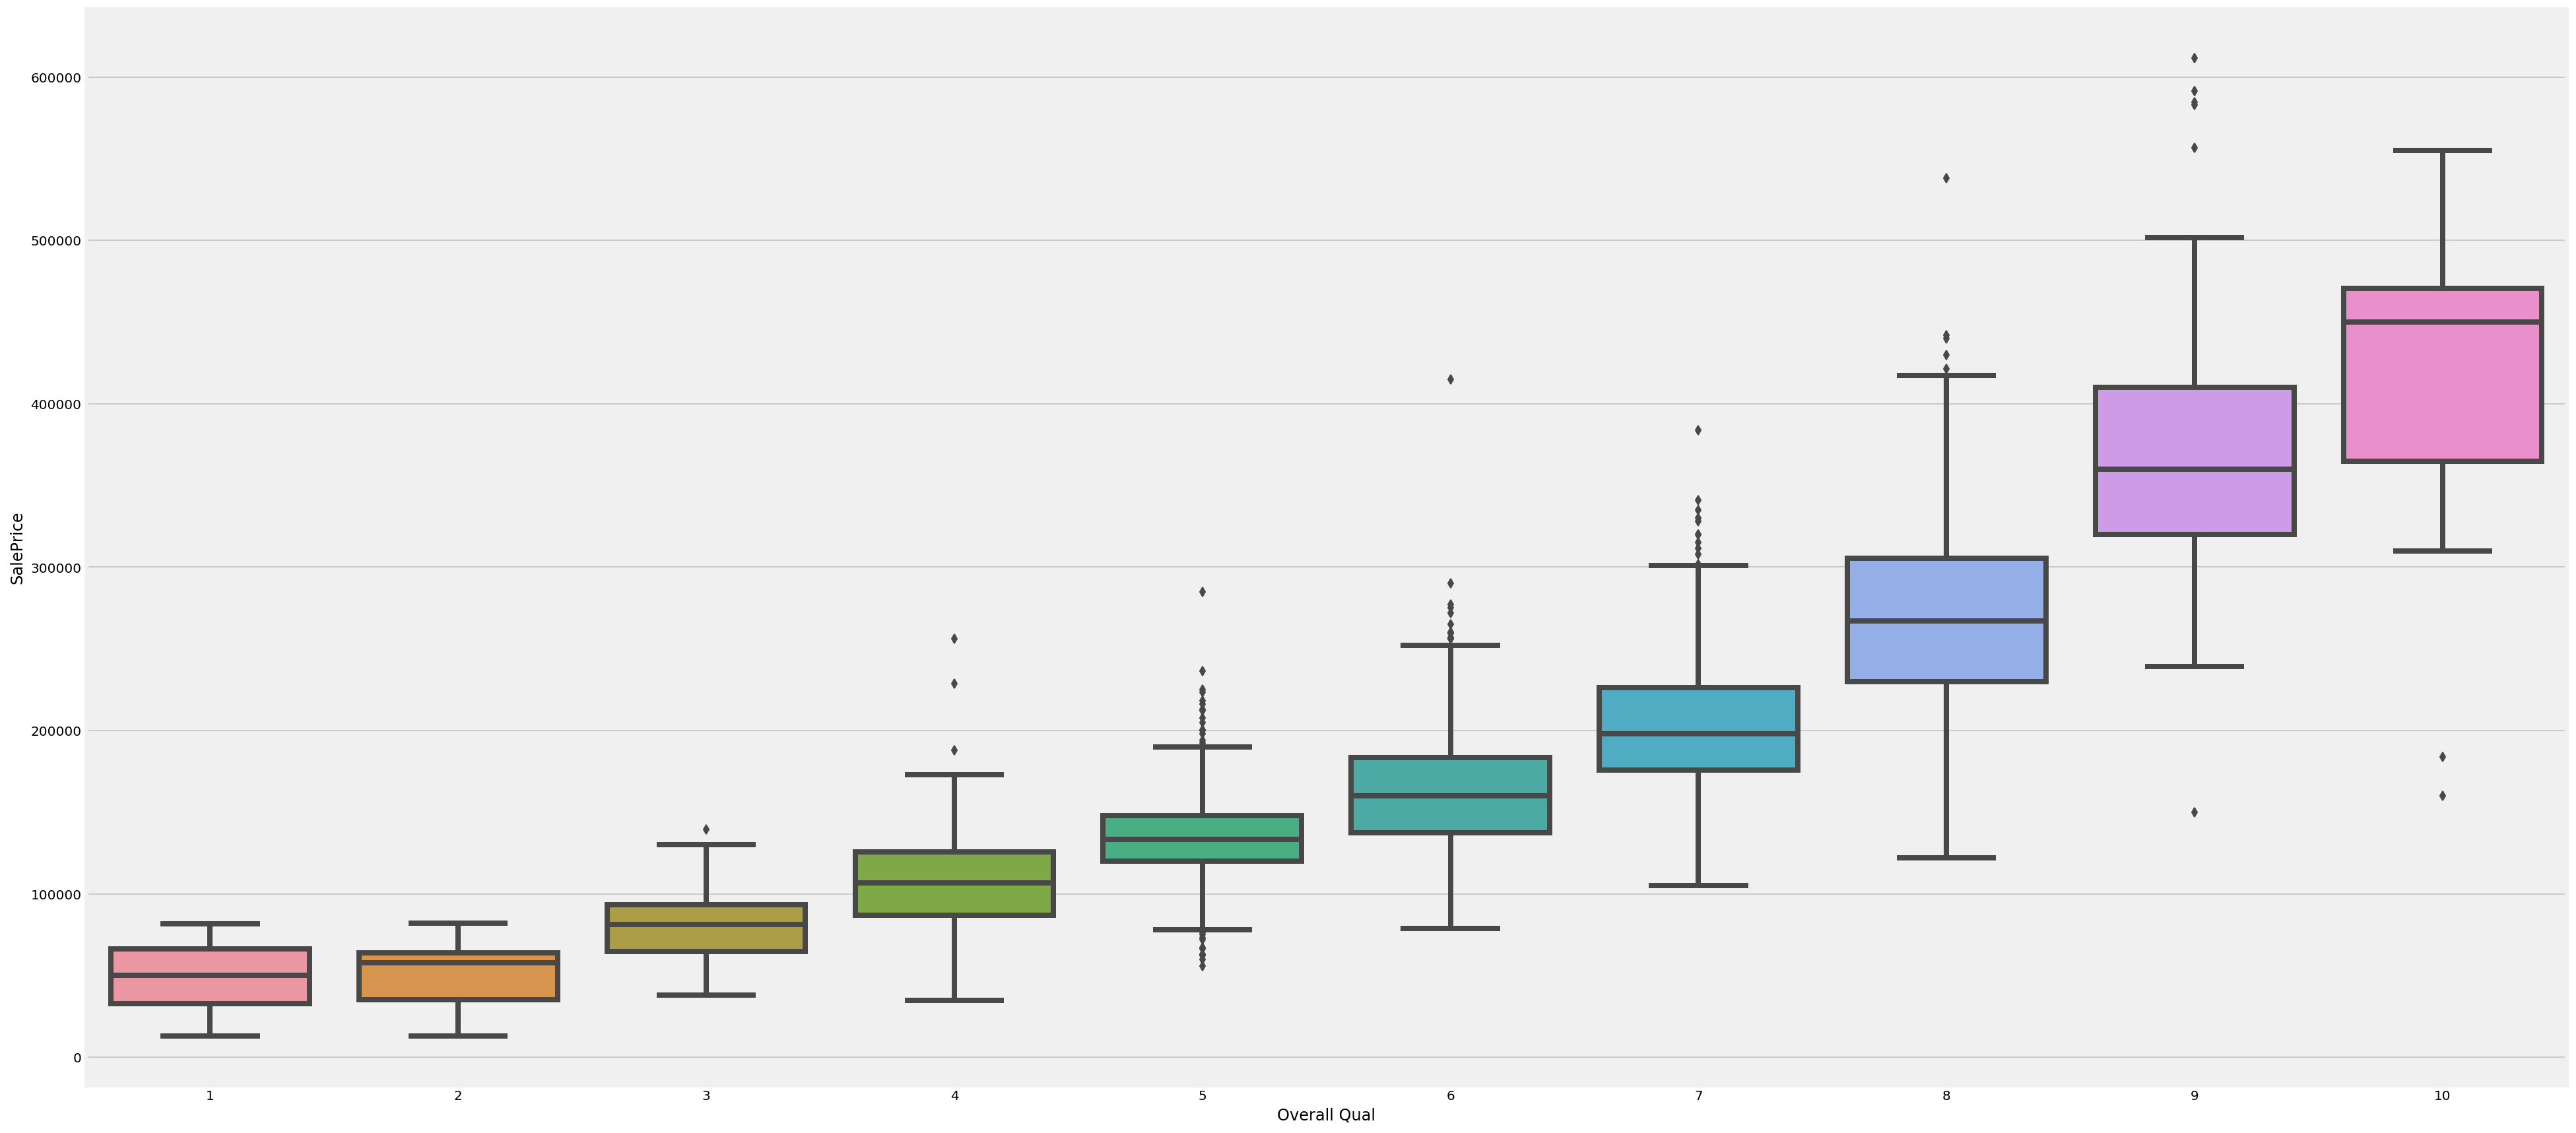

In [152]:
plt.figure(figsize=(30,15))
sns.boxplot(x='Overall Qual', y = 'SalePrice', data=df)

There is a clear positive association/relationship between overall quality of the property and the sale price which reinforced the heatmap above! This might be one of the features to look out for in the model predictions later on!

<Figure size 2160x1080 with 0 Axes>

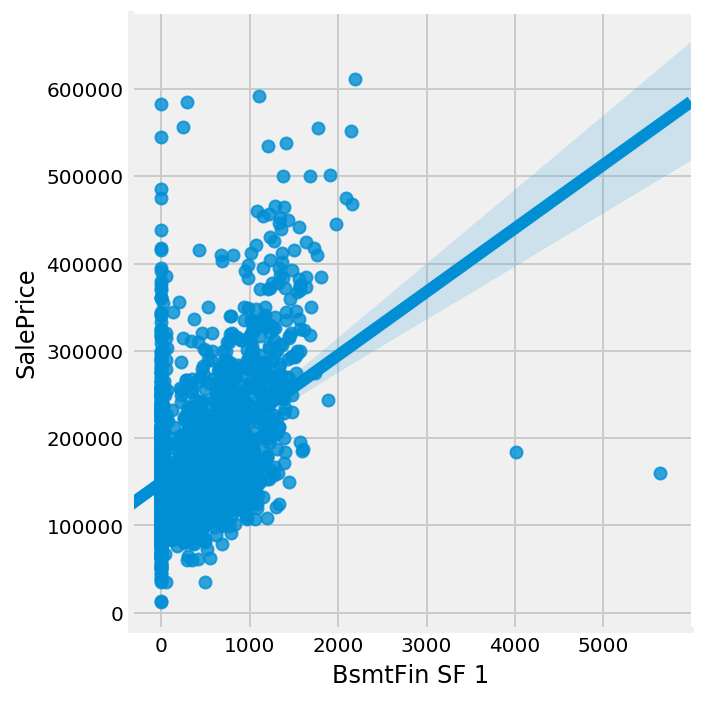

In [153]:
plt.figure(figsize=(30,15))
sns.lmplot(x='BsmtFin SF 1', y ='SalePrice', data=df);

The scatterplot with a best fit line fitted suggest a rather significant positive correlation between type 1 basement square feet and sale price. Might come up in the model predictions later on.  

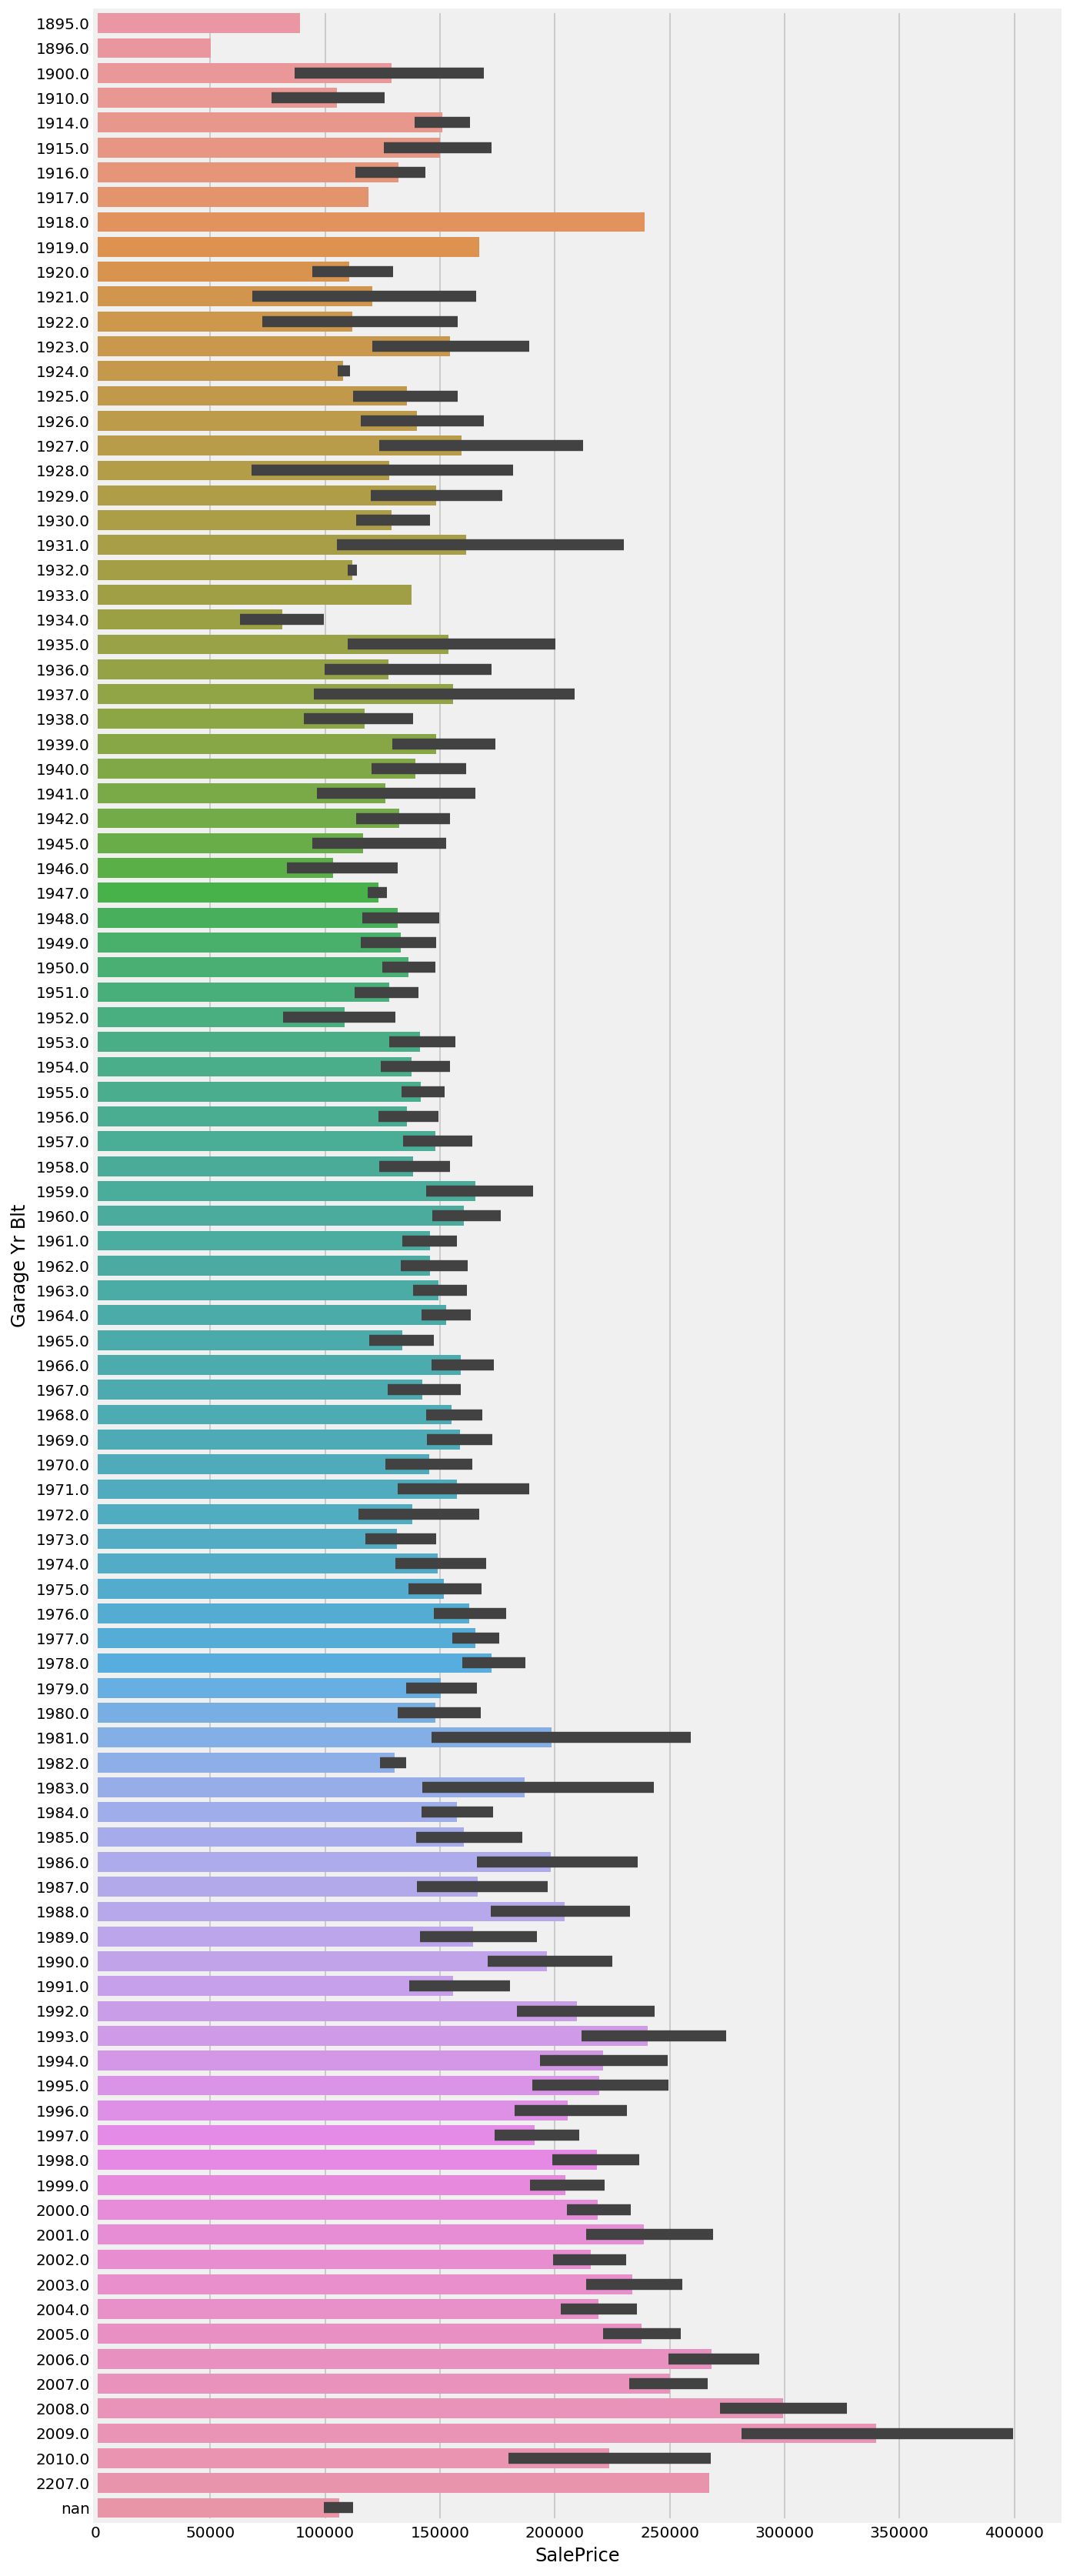

In [154]:
plt.figure(figsize=(10,30))
sns.barplot(y='Garage Yr Blt', x = 'SalePrice', orient='h', data=df);

The horizontal barplot above depicts an increasing sale price as the year the garage was built increases, with a peak in the year 2009! Yet another predictor to look out for in the model predictions. However, the data is still not complete with incorrect values such as the year, '2207', and that 'nan' which failed to be flagged as a null. This may affect the model performance...

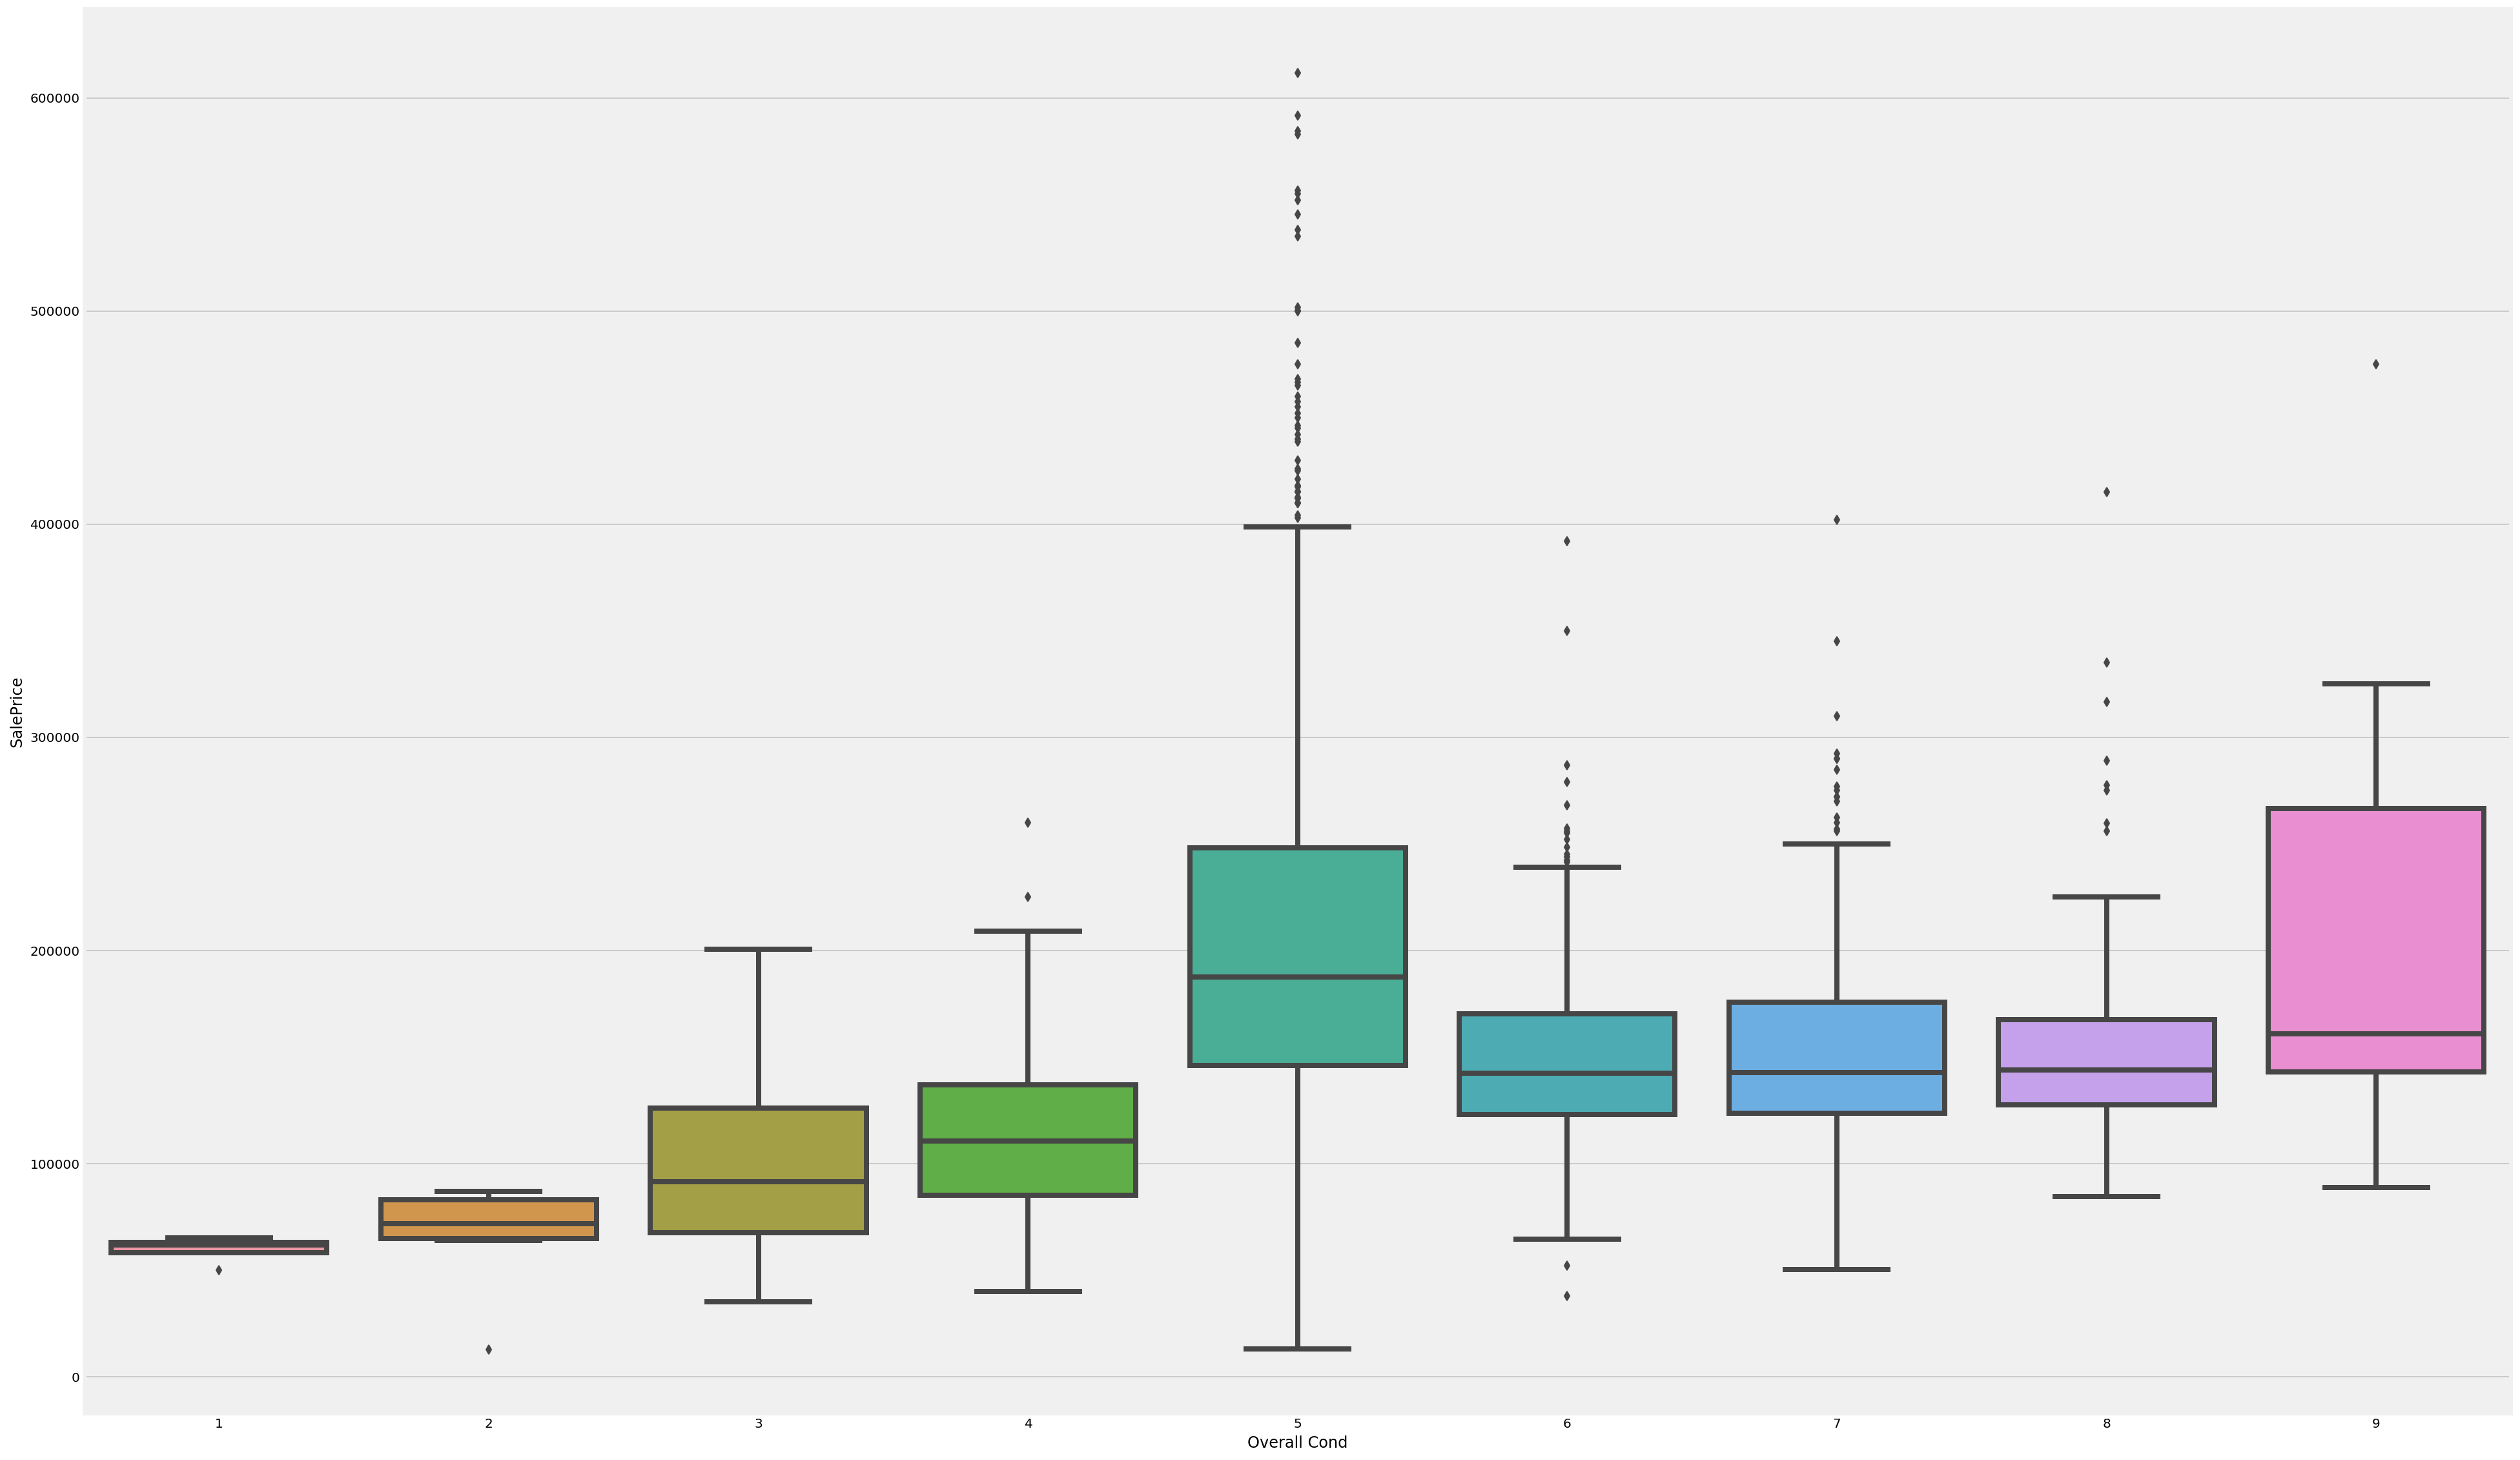

In [155]:
plt.figure(figsize=(30,20))
sns.boxplot(x='Overall Cond', y = 'SalePrice', data=df);

A gentle rising trend is observed between overall property's condition and sale price...

<Figure size 2160x1440 with 0 Axes>

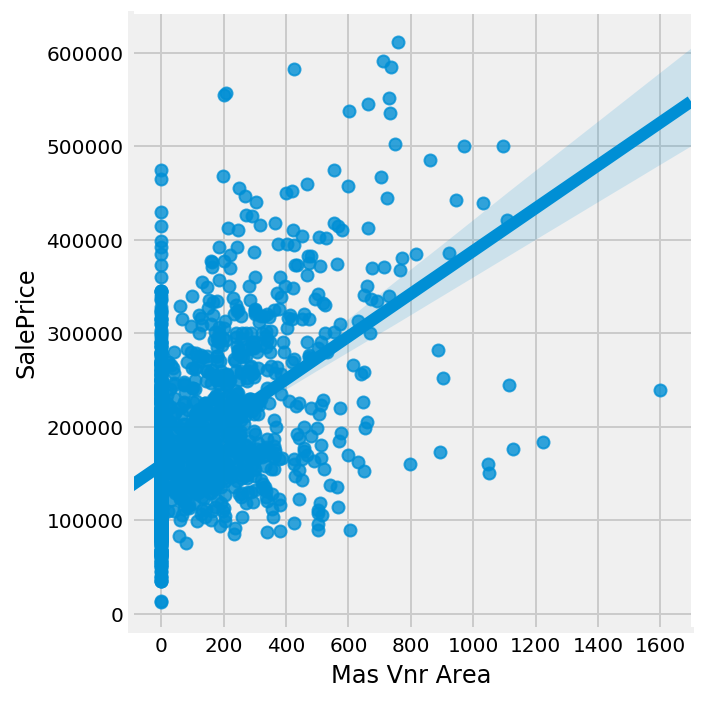

In [156]:
plt.figure(figsize=(30,20))
sns.lmplot(x='Mas Vnr Area', y ='SalePrice', data=df);

Yet another positive linear relationship between masonry veneer area and sale price!

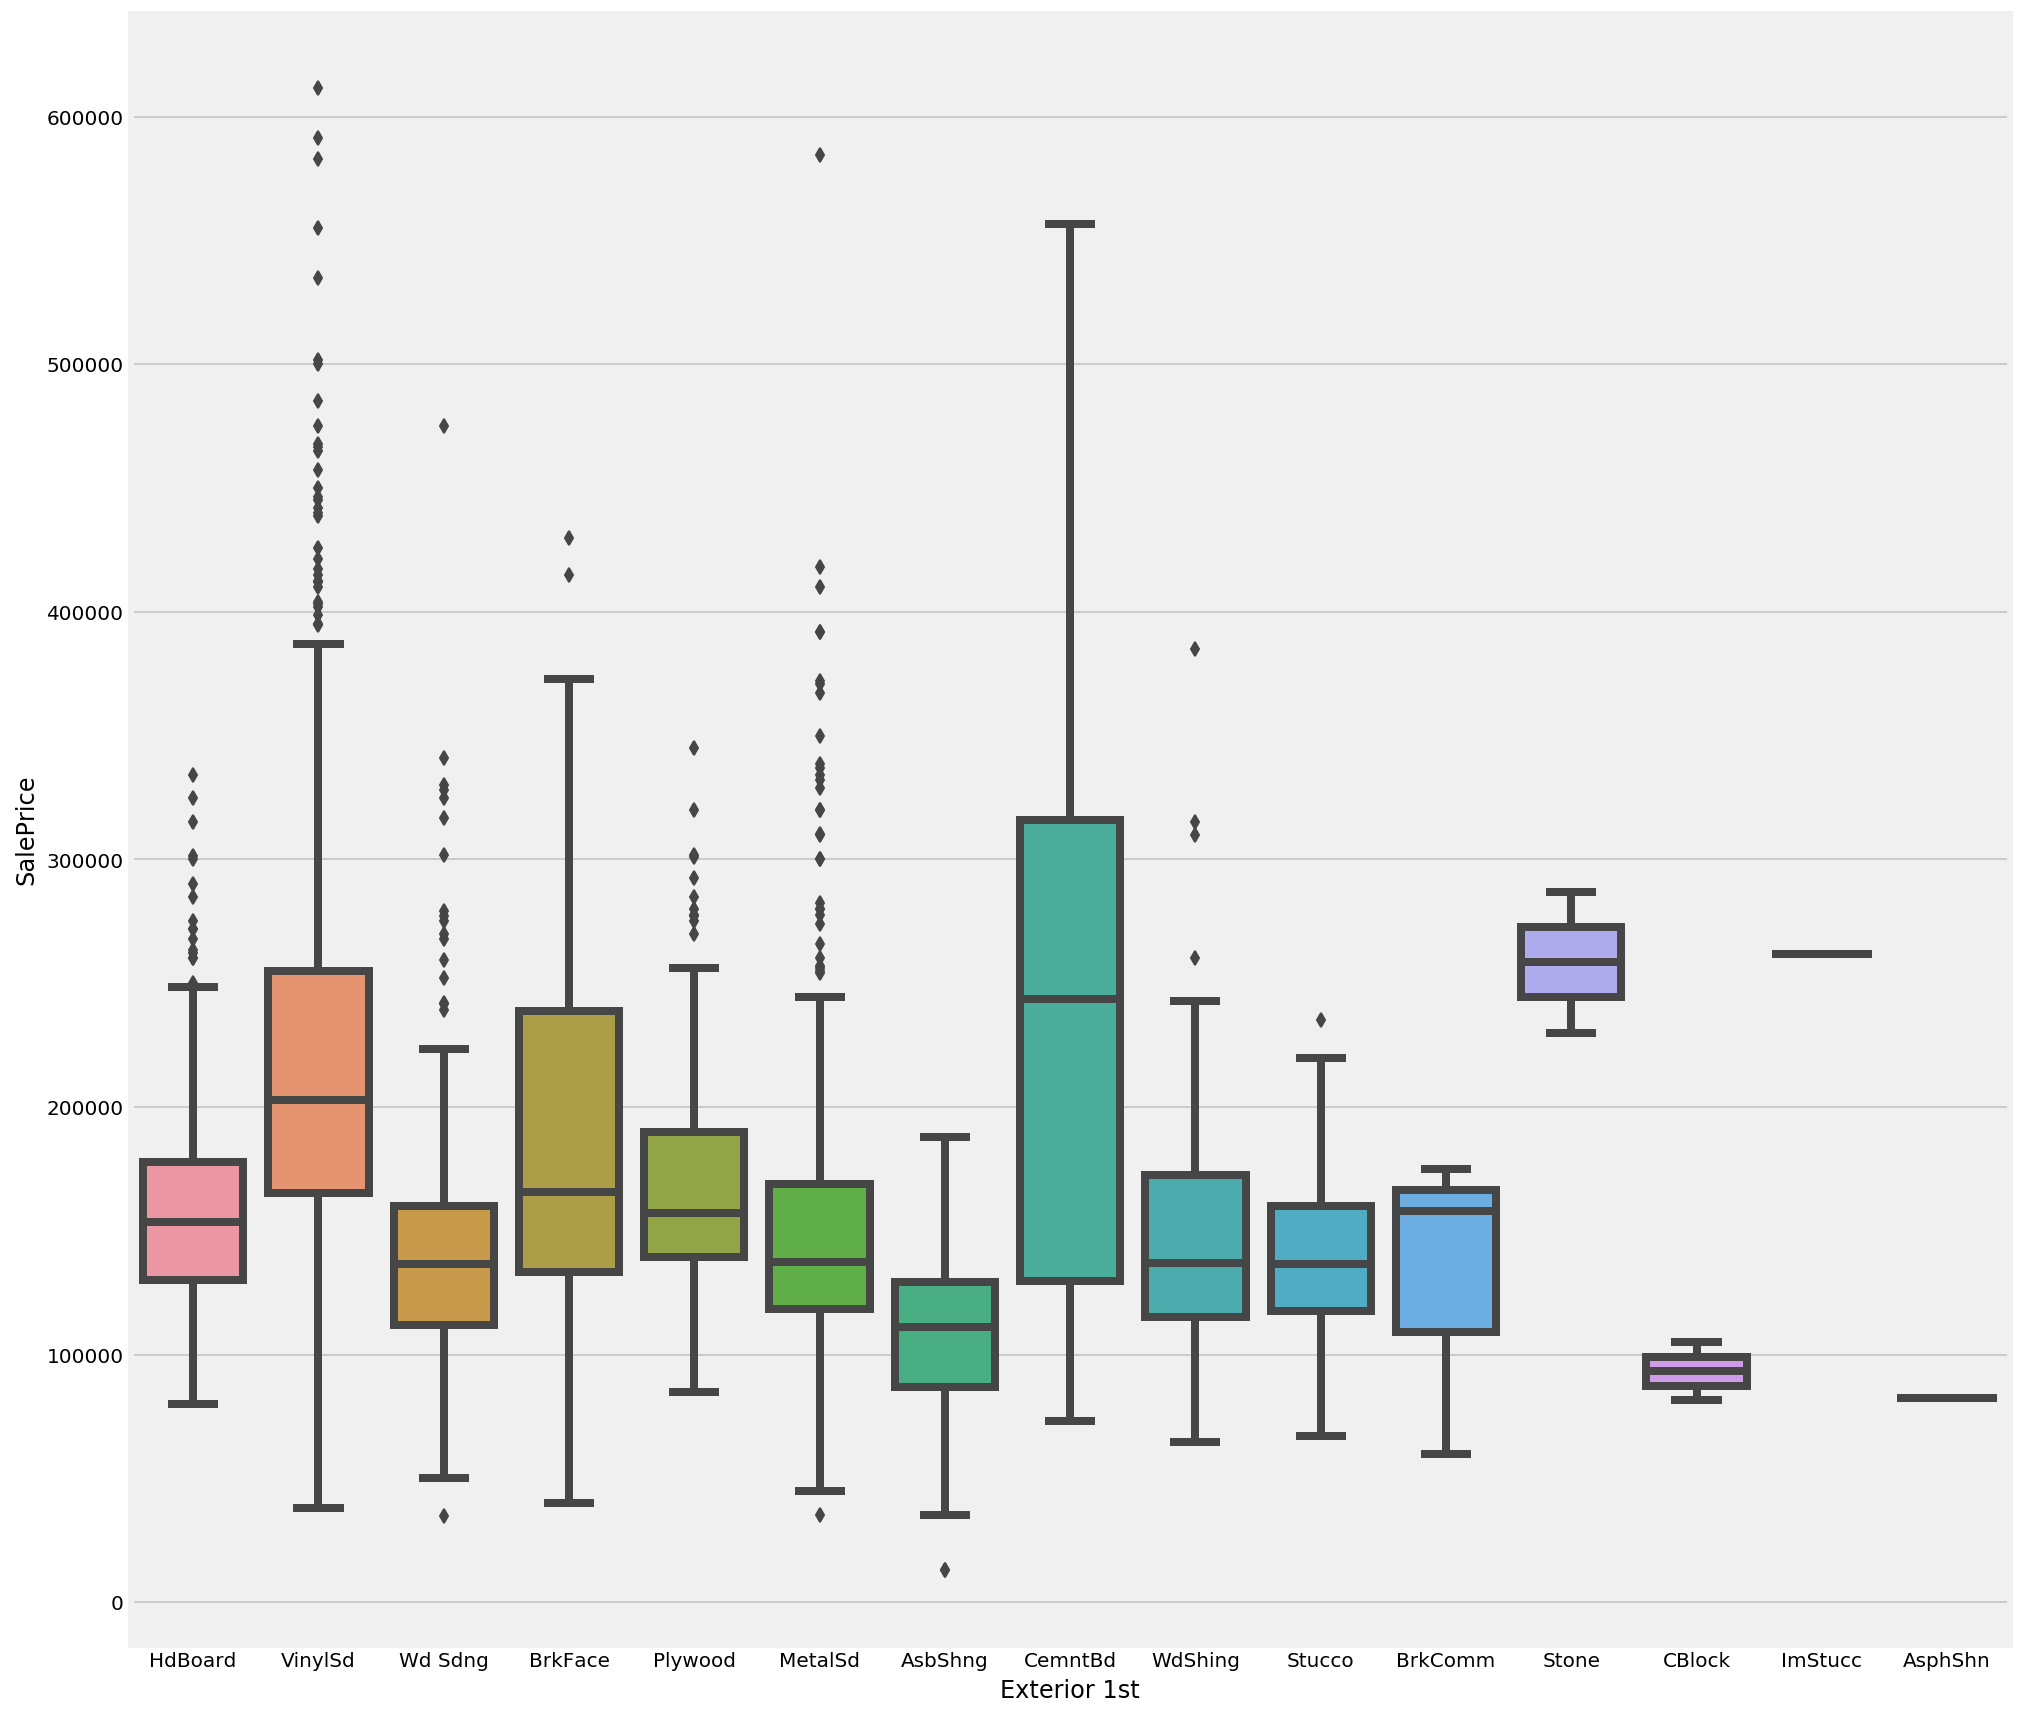

In [157]:
plt.figure(figsize=(15,15))
sns.boxplot(x='Exterior 1st', y = 'SalePrice', data=df);

Even the exterior covering of the house can play a role in the sale price - poor candidates appear to include Cinder block, Asbestos Shingles, Wood Shingles, Asphalt Shingles and Stucco...

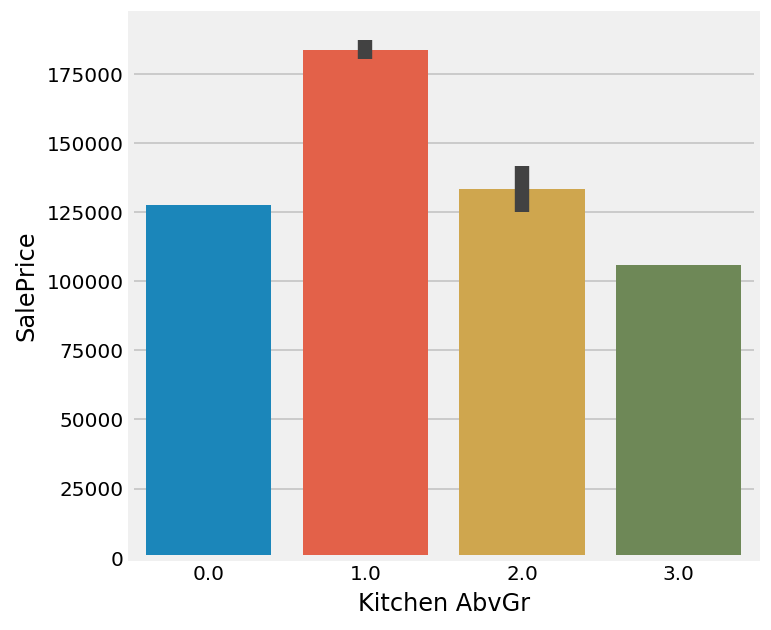

In [158]:
plt.figure(figsize=(5,5))
sns.barplot(x='Kitchen AbvGr', y = 'SalePrice', data=df);

It appears that just having one kitchen above grade sells the house for higher price than 2 or 3...

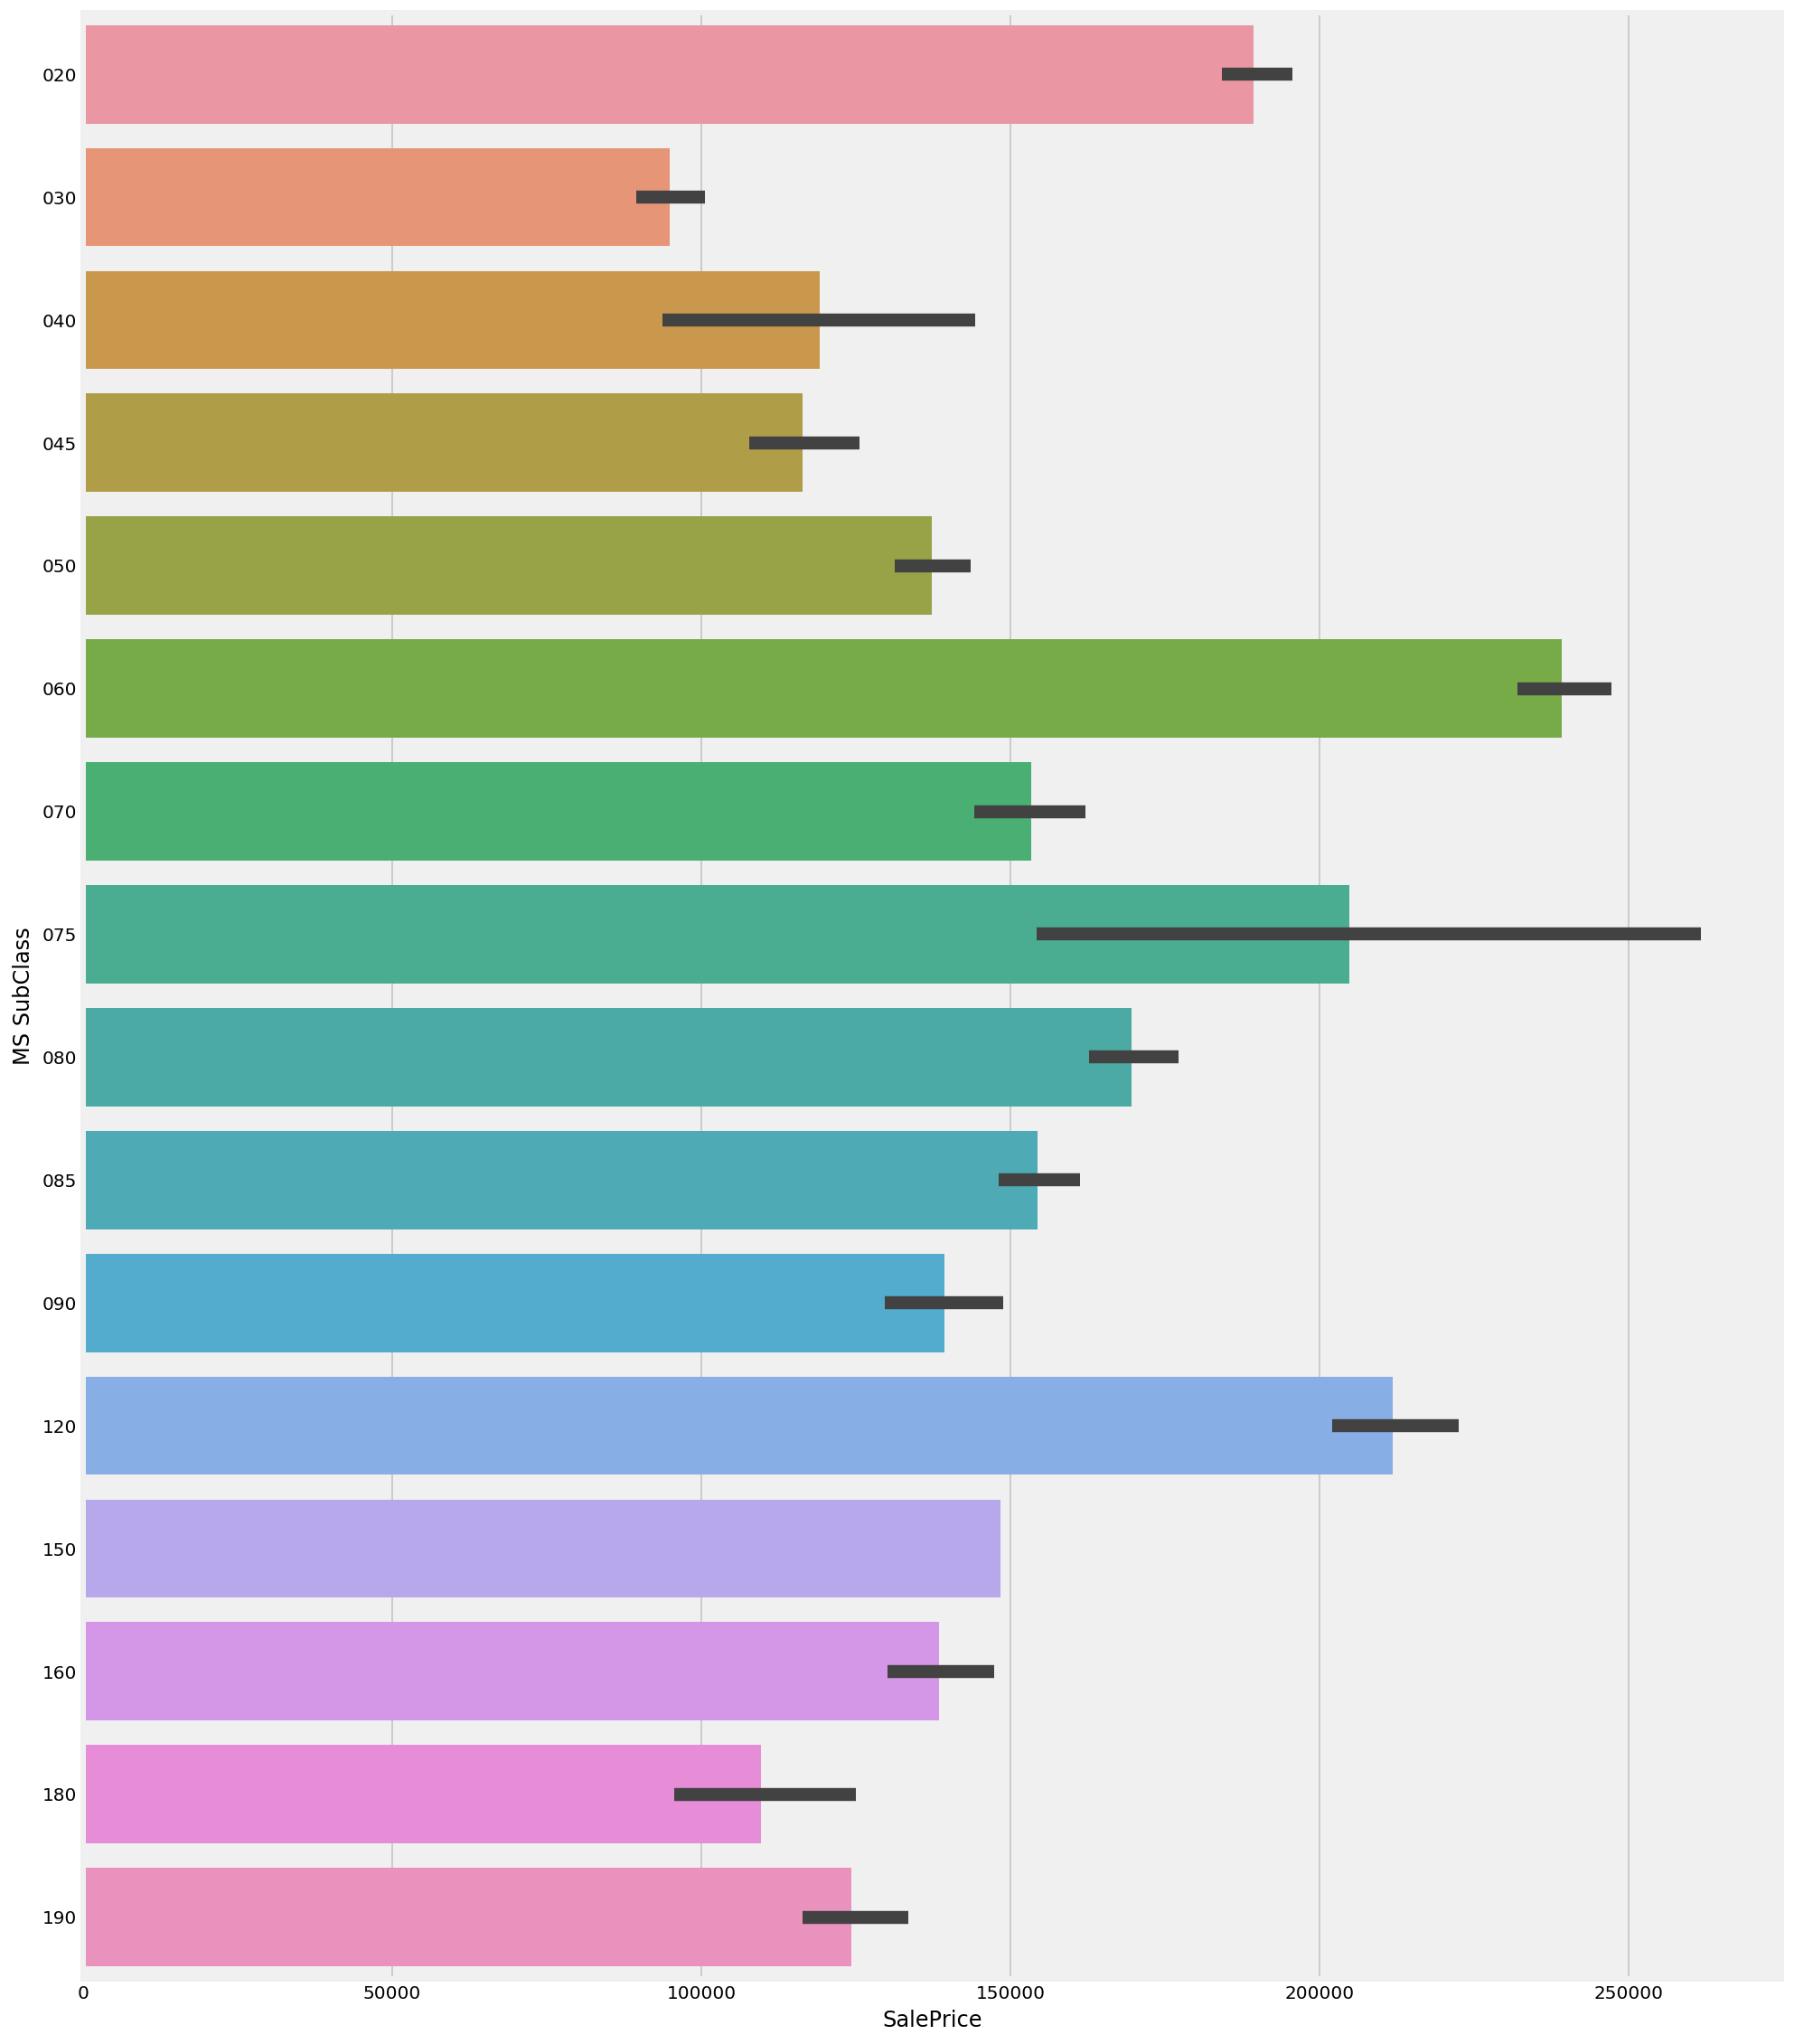

In [159]:
plt.figure(figsize=(15,20))
sns.barplot(y='MS SubClass', x = 'SalePrice', orient='h', data=df);

It is evident that houses with certain types of subclass sell at a higher while others sell at a lower price...

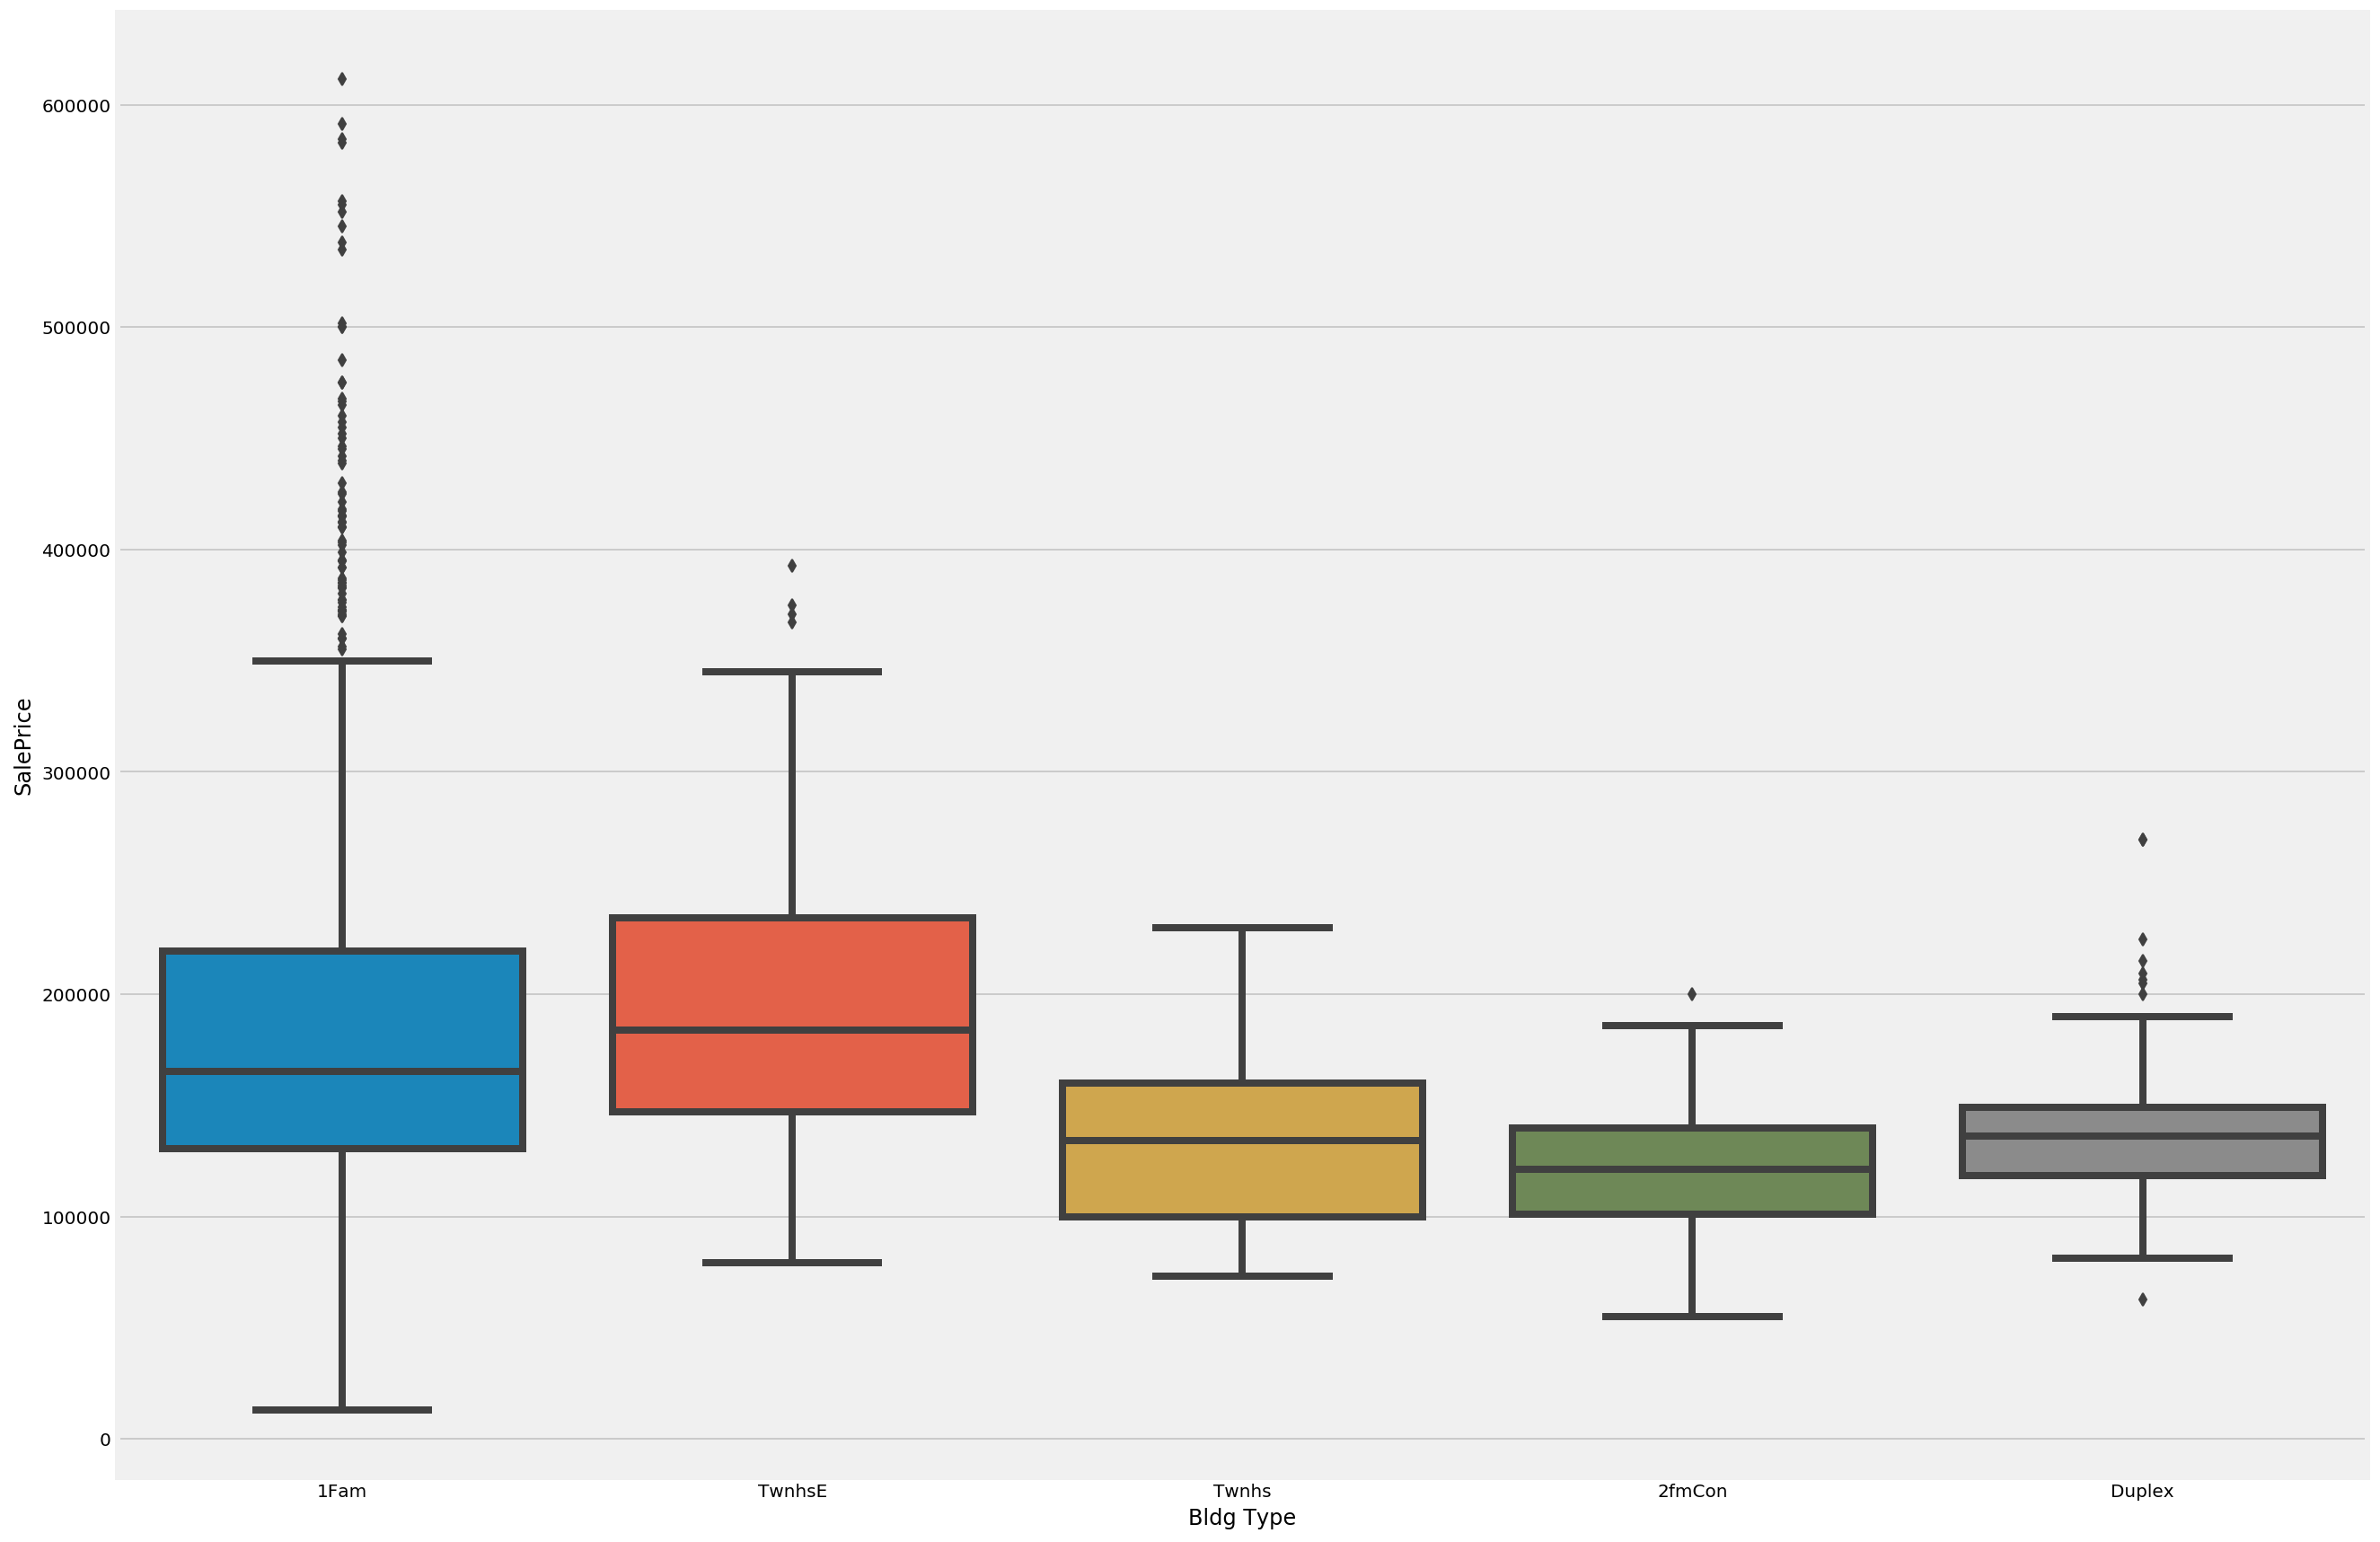

In [160]:
plt.figure(figsize=(20,15))
sns.boxplot(x='Bldg Type', y = 'SalePrice', data=df);

Observable difference between sale price of town house end and inner unit..

<Figure size 2160x1440 with 0 Axes>

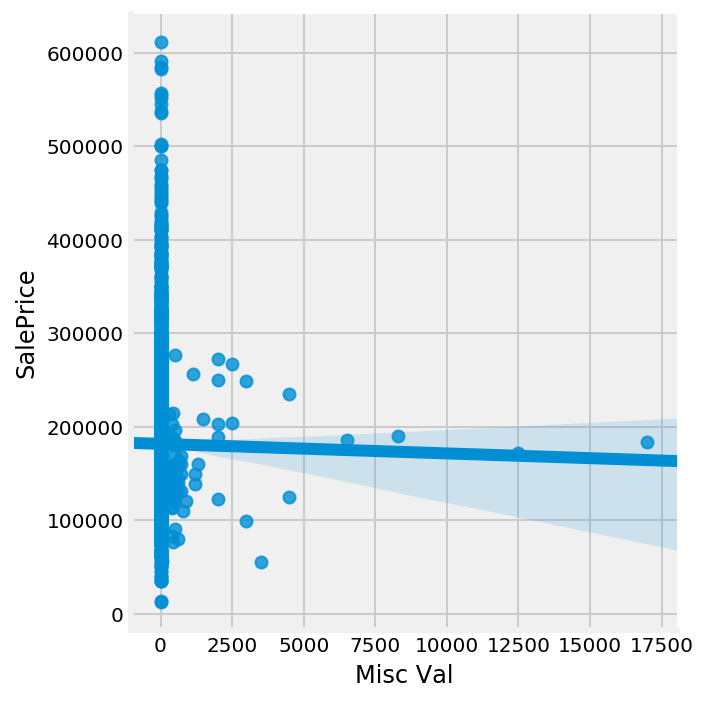

In [161]:
plt.figure(figsize=(30,20))
sns.lmplot(x='Misc Val', y ='SalePrice', data=df);

The scatterplot between sale price and misc val shows a somewhat neutral but slightly negative correlation although it is not apparent. Something interesting to note though.

## Evaluation of ```LinearRegression```, ```Ridge```, ```Lasso```, and ```ElasticNet``` on the dataset & feature selection
---

### 4) Preprocessing & Modelling

- Categorical nominal features will now undergo one-hot encoding with ```pd.get_dummies()``` and be assigned "1"s and "0"s to facilitate modelling subsequently.
- All features will be scaled via ```StandardScaler``` as well in order to allow the regularized regression model to better optimize the features' coefficients more accurately.
- But first, target and predictor variables are created...

In [162]:
new_col_names = {col:col.lower().replace(' ','_') for col in df.columns} #formatting all features' names to lower case and converting spaces to underscores.

In [163]:
df=df.rename(columns=new_col_names) #renaming the columns

In [164]:
df.info() #checking the renamed columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   object 
 2   ms_subclass      2051 non-null   object 
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     2051 non-null   float64
 5   lot_area         2051 non-null   float64
 6   street           2051 non-null   object 
 7   lot_shape        2051 non-null   int64  
 8   land_contour     2051 non-null   object 
 9   utilities        2051 non-null   int64  
 10  lot_config       2051 non-null   object 
 11  land_slope       2051 non-null   int64  
 12  neighborhood     2051 non-null   object 
 13  condition_1      2051 non-null   object 
 14  condition_2      2051 non-null   object 
 15  bldg_type        2051 non-null   object 
 16  house_style      2051 non-null   object 
 17  overall_qual  

In [165]:
df=df.drop(['id','pid'],axis=1) #dropping the id and pid labels so that they will not be converted into dummy variables in the next step.

In [166]:
df=pd.get_dummies(df, drop_first=True) #one-hot encoding of all categorical nominal variables, and assignment back to df.

In [167]:
df.info() #df now has 489 columns inclusive of dummy variables.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Columns: 489 entries, lot_frontage to sale_type_WD 
dtypes: float64(29), int64(22), uint8(438)
memory usage: 1.7 MB


In [168]:
X = df.drop(['saleprice'],axis=1) #defining predictor and target arrays.
y = df['saleprice'].values

In [169]:
scaler = StandardScaler() #Instantiating the StandardScaler in order to scale variables given that the varibales used have different scales-"Total Bsmt SF", "Full Bath", "Garage Finish" for instance

In [170]:
X_scaled = scaler.fit_transform(X) #Transforming the feature matrix with scaling.

### 5) Fitting Multiple Linear Regression (MLR), ```LinearRegression()``` on the dataset 

- Using cross validation where number of folds is an arbitrary 5.

In [171]:
linreg = LinearRegression() #Instantiate Linear Regression

linreg_scores = cross_val_score(linreg, X_scaled, y, cv=5) #Perform cross validation

print("Cross-validated LinReg scores R2:", linreg_scores) #prints cross-validated scores

print("Mean LinReg R2:",np.mean(linreg_scores)) #prints mean of cross-validated scores

predictions = cross_val_predict(linreg, X_scaled, y, cv=5) # Make cross-validated predictions

r2 = metrics.r2_score(y, predictions) #computes r2 score

print("Cross-Predicted LinReg R2:", r2) #prints r2 score

Cross-validated LinReg scores R2: [-1.05864859e+21 -1.35807705e+24 -4.68975204e+22 -3.01135381e+23
 -9.27120373e+21]
Mean LinReg R2: -3.432879610272181e+23
Cross-Predicted LinReg R2: -3.240242497811995e+23


The negative mean R2 above suggests that the ```linreg``` model performs worse than the baseline model of just using the mean of the target variable, ```SalePrice``` as the model. Let's compare this to a regularized regression such as ```Ridge``` which works better on datasets with multiple features such as this one, by contraining large coefficients of predictors and coping with multi-collinearity, thereby reducing model complexity and variance, allowing it to generalize better to unseen data. 

### 6) Fitting a regularized regression, ```Ridge()``` on the dataset by first determining the optimal alpha

- Similarly for standardization purposes, using cross validation where number of folds is an arbitrary 5 here too.

In [172]:
ridge_alphas = np.logspace(0, 5, 200) #Using RidgeCV to search for optimal alphas through a logspace.

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5) #searching for optimal alphas using pre-defined range above
optimal_ridge.fit(X_scaled, y) #training the model with scaled feature and target variables

print('Optimal Ridge Alpha: ', optimal_ridge.alpha_) #prints the optimal alpha for ridge

Optimal Ridge Alpha:  690.5513520162331


---

### 7) Cross-validate the ```Ridge``` regression $R^2$ with the optimal alpha.


In [173]:
ridge = Ridge(alpha=optimal_ridge.alpha_) #instantiate ridge with the optimal alpha obtained above

ridge_scores = cross_val_score(ridge, X_scaled, y, cv=5) #cross-validation with 5 folds

print("Cross-validated Ridge scores R2:", ridge_scores) #prints the cross-validated r2 scores

print("Mean Ridge R2:",np.mean(ridge_scores)) #prints the mean of the cross-validated r2 scores

predictions_ridge = cross_val_predict(ridge, X_scaled, y, cv=5) #cross-predict

r2_ridge = metrics.r2_score(y, predictions_ridge) #computes r2 based on cross-validation

print("Cross-Predicted Ridge R2:", r2_ridge) #prints the cross-predicted r2 score

Cross-validated Ridge scores R2: [0.87864565 0.8950923  0.80937242 0.88510288 0.82701257]
Mean Ridge R2: 0.8590451610926028
Cross-Predicted Ridge R2: 0.8575214914810438


Fitting a ```Ridge``` regression model on the data significantly improved the model performance as can be seen with a positive R2 score that is close to 1! Let's see how well the ```Lasso``` model performed on this dataset next!

### 8) Fitting a regularized regression, ```Lasso()``` on the dataset by first determining the optimal alpha

- Similarly for standardization purposes, using cross validation where number of folds is an arbitrary 5 here too.

In [174]:
optimal_lasso = LassoCV(n_alphas=500, cv=5, verbose=1) #Allowing LassoCV to decide what alphas to use by setting the keyword argument n_alphas= to however many alphas arbitrarily determined to search over.
optimal_lasso.fit(X_scaled, y) #training the model

print('Optimal Lasso Alpha : ', optimal_lasso.alpha_) #printing optimal alpha for lasso

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Optimal Lasso Alpha :  855.8617534498123


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s finished


---

### 9) Cross-validate the ```Lasso``` regression $R^2$ with the optimal alpha.

In [175]:
lasso = Lasso(alpha=optimal_lasso.alpha_) #instantiating lasso with the optimal alpha obtained from above

lasso_scores = cross_val_score(lasso, X_scaled, y, cv=5) #cross-validation with 5 folds

print("Cross-validated Lasso scores R2:", lasso_scores) #prints cross-validated r2 scores

print("Mean Lasso R2:",np.mean(lasso_scores)) #prints mean of cross-validated r2 scores

predictions_lasso = cross_val_predict(lasso, X_scaled, y, cv=5) #cross-predict

r2_lasso = metrics.r2_score(y, predictions_lasso) #computes r2 score for lasso

print("Cross-Predicted Lasso R2:", r2_lasso) #prints out cross-predicted r2 score for lasso

Cross-validated Lasso scores R2: [0.86562279 0.90794188 0.79077965 0.89641336 0.83220229]
Mean Lasso R2: 0.8585919931938552
Cross-Predicted Lasso R2: 0.8567357184420394


Even though Ridge performed very slightly better than Lasso, there are more features than there are rows and this will give rise to high model variance. Lasso will be used to eliminate unimportant or redundant features to reduce model variance and complexity.

---

### 10) Determining important features that contribute to our target, ```SalePrice```.


In [176]:
lasso.fit(X_scaled, y) #fitting with lasso to retrieve the coefficients.

Lasso(alpha=855.8617534498123, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [177]:
lasso_coefs = pd.DataFrame({'variable':X.columns, #creating a dictionary of variables, their coefficients and the absolute value of their coefficients so that they can be ranked below.
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False) #sorting absolute coefficients in descending order

lasso_coefs.head(20) #displays the top 20 most important predictors (either positive or negative) based on lasso's feature selection

variable          coef      abs_coef
24            gr_liv_area  20153.565203  20153.565203
5            overall_qual  13901.282070  13901.282070
97   neighborhood_NridgHt   8992.942229   8992.942229
49               misc_val  -6797.919365   6797.919365
103  neighborhood_StoneBr   5924.300827   5924.300827
31           kitchen_qual  -5920.209843   5920.209843
8              exter_qual  -5368.169008   5368.169008
10              bsmt_qual  -5349.654186   5349.654186
12          bsmt_exposure  -4977.241518   4977.241518
37            garage_cars   4475.731914   4475.731914
96   neighborhood_NoRidge   4341.214950   4341.214950
14           bsmtfin_sf_1   3984.746975   3984.746975
124      bldg_type_TwnhsE  -3635.626669   3635.626669
456  garage_yr_blt_2009.0   3507.213279   3507.213279
46           screen_porch   3266.629447   3266.629447
7            mas_vnr_area   3259.261014   3259.261014
6            overall_cond   2984.681325   2984.681325
460     misc_feature_Gar2   2859.492032   2859.492032
35           fireplace_qu  -2812.178577   2812.178577
25         bsmt_full_bath   2739.492512   2739.492512

In [178]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[1]))

Percent variables zeroed out: 0.7786885245901639


In [179]:
np.sum((lasso.coef_ != 0)) #Important features based on Lasso

108

In [180]:
np.sum((lasso.coef_ == 0)) #Unimportant features based on Lasso

380

In [181]:
lasso_coefs #checking out the important feature variables sorted in descending order of the size of their coefficients.

variable          coef      abs_coef
24            gr_liv_area  20153.565203  20153.565203
5            overall_qual  13901.282070  13901.282070
97   neighborhood_NridgHt   8992.942229   8992.942229
49               misc_val  -6797.919365   6797.919365
103  neighborhood_StoneBr   5924.300827   5924.300827
..                    ...           ...           ...
200       year_built_1967      0.000000      0.000000
199       year_built_1966      0.000000      0.000000
198       year_built_1965     -0.000000      0.000000
197       year_built_1964      0.000000      0.000000
487         sale_type_WD      -0.000000      0.000000

[488 rows x 3 columns]

In [182]:
lst_impt_feat=lasso_coefs[lasso_coefs['coef']!=0][['variable']].values.tolist() #Filtering for all important features to a list

In [183]:
lst_impt_feat=[lst[0] for lst in lst_impt_feat] #Storing all important features to a list

In [184]:
len(lst_impt_feat) #there are 108 important features identified by lasso.

108

We now have a narrowed-down list of variables, 108, to be precise! 380/488 (~77.9%) of the variables have been zeroed-out by ```Lasso```! Let's see how well the ```ElasticNet```, a combination of ```Ridge``` and ```Lasso``` does on this dataset next!

### 11) Fitting a regularized regression, ```ElasticNet``` on the dataset by first determining the optimal alpha and l1_ratio

- Will be using ```n_alphas``` for the alpha parameters and searching over an arbitrary ```linspace()``` for ```l1_ratios```.
- Cross validation fold will be standardized with the rest of the prior models at ```cv=5```.


In [185]:
l1_ratios = np.linspace(0.01, 1.0, 25)  #specifying a range of l1_ratios for ElasticNetCV to search over

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=500, cv=5, #specifying the number of alphas for ElasticNet to search over
                            verbose=1)
optimal_enet.fit(X_scaled, y) #training the model with ElasticNet on scaled X data

print(optimal_enet.alpha_) #printing both optimal alpha and l1_ratio
print(optimal_enet.l1_ratio_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

855.8617534498123
1.0


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   46.3s finished


---

### 12) Cross-validate the ElasticNet $R^2$ with the optimal alpha and l1_ratio.

In [186]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_) #instantiating ElasticNet with the optimal alpha and l1_ratios obtained above

enet_scores = cross_val_score(enet, X_scaled, y, cv=5) #cross-validation with 5 folds

print("Cross-validated ElasticNet scores R2:", enet_scores) #prints cross-validated r2 scores

print("Mean ElasticNet R2:",np.mean(enet_scores)) #prints mean of cross-validated r2 scores

predictions_enet = cross_val_predict(enet, X_scaled, y, cv=5) #cross-predict

r2_enet = metrics.r2_score(y, predictions_enet) #computes r2 score for ElasticNet

print("Cross-Predicted Lasso R2:", r2_enet) #prints cross-predicted r2 score for ElasticNet

Cross-validated ElasticNet scores R2: [0.86562279 0.90794188 0.79077965 0.89641336 0.83220229]
Mean ElasticNet R2: 0.8585919931938552
Cross-Predicted Lasso R2: 0.8567357184420394


It appears that ```ElasticNet``` performed as well as ```Lasso```, although after accounting for rounding, all 3 regularized models performed as well with a R2 of 0.86! This means that the 3 models are able to explain 86% of the variance in the target, ```SalePrice```. This is not surprising as this dataset has many features and some if not most, could be collinear, which would affect the accuracy of the model when generalizing to unseen data. ```ElasticNetCV``` searches for an appropriate blend of ```Ridge``` and ```Lasso``` regularized regression models based on the number of alphas and search space for l1_ratio and arrived at ```Lasso``` (given that as shown in the cell above point 7), the optimal l1_ratio is 1.0) which will help simplify the model through feature selection which we have also witnessed earlier. Given the ability of ```ElasticNet``` to tune between ```Ridge``` and ```Lasso```, it will be used to train the model proper in the subsequent section. 

## Model Development
---

### 13) Training an ```ElasticNet``` model proper with the narrowed down features to see how well it performs using 6 regression metrics.

In [187]:
X1 = X[lst_impt_feat]  #defining the predictor and target variables containing only the important features filtered out by Lasso earlier, for model development.
y = df['saleprice'].values

In [188]:
X1.shape

(2051, 108)

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, random_state=42) #Using a default test_size of 25% and a train_size of 75%

In [190]:
scaler1 = StandardScaler() #Instantiating a different scaler to avoid confusion.

In [191]:
scaler1.fit(X_train)  #Scaling on X_train and transforming both X_train and X_test.
X_train_sc = scaler1.transform(X_train)
X_test_sc = scaler1.transform(X_test)

In [192]:
def r2_adj(y_true, y_preds, p):   #Defining function that will output adjusted r2_score.
    n = len(y_true)
    y_mean = np.mean(y_true)
    numerator = np.sum(np.square(y_true - y_preds)) / (n - p - 1)
    denominator = np.sum(np.square(y_true - y_mean)) / (n - 1)
    return 1 - numerator / denominator

In [193]:
import sklearn.metrics as metrics   #Defining function that will output regression metrics for model evaluation.
import numpy as np

def reg_metrics(y_true, y_pred, p):
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    msle = metrics.mean_squared_log_error(y_true, y_pred)
    mae = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    r2a = r2_adj(y_true, y_pred, p)
    
    print('Mean squared error      = ', mse)
    print('Root mean squared error = ', rmse)
    print('Mean squared log error  = ', msle)
    print('Median absolute error   = ', mae)
    print('R^2                     = ', r2)
    print('Adjusted R^2            = ', r2a)

In [194]:
l1_ratios_tts = np.linspace(0.01, 1.0, 25) #searching for optimal alphas and l1_ratios for the X_train_sc

optimal_enet_tts = ElasticNetCV(l1_ratio=l1_ratios_tts, n_alphas=500, cv=5, #steps are the same as prior ElasticNet optimization cycle
                            verbose=1)
optimal_enet_tts.fit(X_train_sc, y_train)

print(optimal_enet_tts.alpha_)
print(optimal_enet_tts.l1_ratio_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

504.81199260626596
1.0


......................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   19.7s finished


In [195]:
enet_tts = ElasticNet(alpha=optimal_enet_tts.alpha_, l1_ratio=optimal_enet_tts.l1_ratio_) #instantiating with optimal alpha and l1_ratio
enet_tts.fit(X_train_sc, y_train)  #train the model witht he optimal alpha and l1_ratio
predictions_enet_train = enet_tts.predict(X_train_sc) #predict on X_train_sc
print('Reg metrics for training set: ')
reg_metrics(y_train, predictions_enet_train, X1.shape[1]) #prints a series of 6 regression metrics

Reg metrics for training set: 
Mean squared error      =  578281951.894511
Root mean squared error =  24047.493671784403
Mean squared log error  =  0.019077947352719702
Median absolute error   =  11181.0145135419
R^2                     =  0.908565087759651
Adjusted R^2            =  0.9016546815161536


In [196]:
predictions_enet_test = enet_tts.predict(X_test_sc) #predict on X_test_sc
print('Reg metrics for test set: ')
reg_metrics(y_test, predictions_enet_test, X1.shape[1])  #prints a series of 6 regression metrics

Reg metrics for test set: 
Mean squared error      =  637877414.3062584
Root mean squared error =  25256.235157011397
Mean squared log error  =  0.02406779562349702
Median absolute error   =  12446.536320327665
R^2                     =  0.8961115887437219
Adjusted R^2            =  0.8683394391999644


As expected, R2 dropped a little from ~0.91 to ~0.90 comparing between training and test set since we are examining how well the model performs on unseen data (test set). The adjusted R2 score gives a more pronounced indication of how well the model generalizes to unseen data with a larger difference between itself and R2 indicating high model complexity with possibly unimportant features but in this case, the difference of ~0.90 - ~0.87 for the test set is not too bad. We will be using this model to predict on the ```test.csv```.

### Assumptions of MLR

- Based on the heatmap earlier, features like ```overall_qual``` have a high correlation coefficient (0.81), with ```SalePrice``` and most others are either positively or negatively correlated to varying extents, suggesting linearity assumption is fulfilled.

In [197]:
residuals = predictions_enet_test - y_test

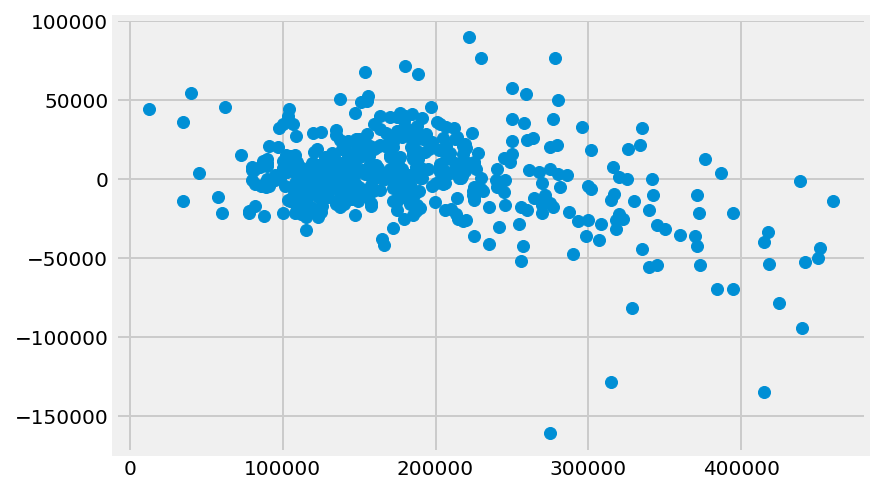

In [198]:
plt.scatter(y_test, residuals);

- The above scatterplot shows a roughly horizontal trend suggesting that the independence assumption of MLR is roughly fulfilled.

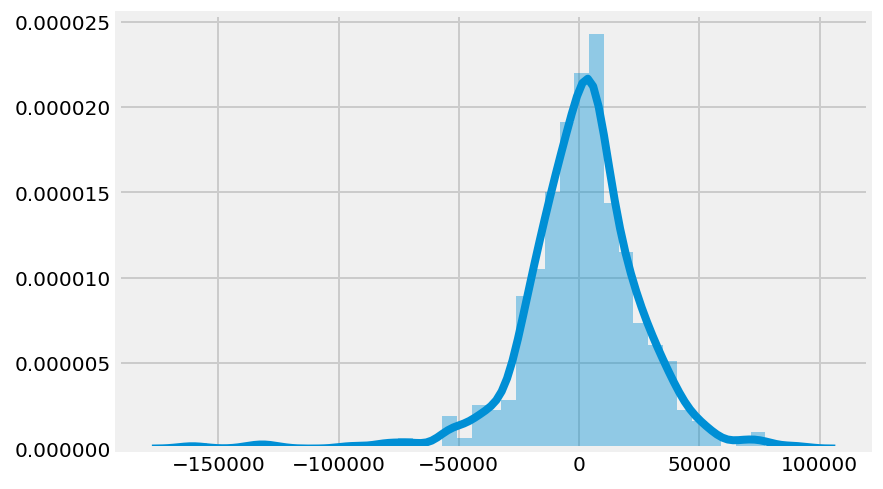

In [199]:
sns.distplot(residuals);

- The above distplot shows that the residuals are normally distributed, fulfilling the normality assumption for MLR.

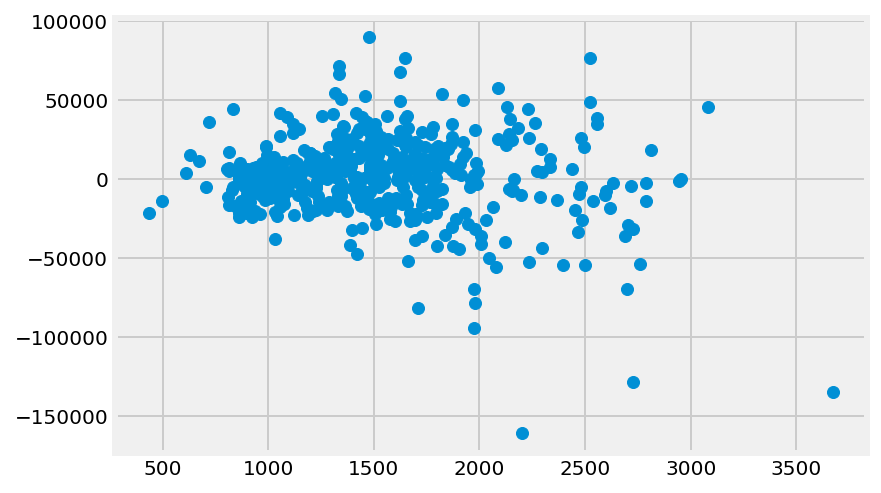

In [200]:
plt.scatter(X_test['gr_liv_area'], residuals);

- The above scatterplot shows that the residuals are roughly independent of one of the selected predictors, ```gr_liv_area```, given the roughly horizontal trend, fulfilling the equality of variance assumption. 

### Testing the independence of predictors to assess the last assumption on independence of predictors for MLR
- Using ```variance_inflation_factor``` (VIF)
- Any VIF equal to or larger than 10 means that feature should not be included in the model as long as it is not a nominal feature with multiple levels ([source](https://www.statisticshowto.datasciencecentral.com/variance-inflation-factor/)) 

In [201]:
vif = pd.DataFrame() #generating an empty dataframe for VIF outputs

In [202]:
X2 = X1.copy() #creating a copy of the original X1 just in case of 'accidents'.

In [203]:
X2['intercept']=1 #adding 'intercept' column to X2

In [204]:
vif["variables"] = X2.columns #creating a new column called 'variables' in vif dataframe.

In [205]:
vif["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])] #running VIF on the predictors chosen to determine collinearity.

/Users/jasonchia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [206]:
vif[vif['VIF']>=10].sort_values('VIF', ascending=False) #filtering for VIFs more than or equal to 10 and determining which numerical or ordinal feature is a cause for concern.

variables          VIF
79        ms_subclass_090          inf
92       bldg_type_Duplex          inf
101       year_built_1896          inf
106  garage_yr_blt_1896.0          inf
108             intercept  2318.670800
12       bldg_type_TwnhsE    13.983190
0             gr_liv_area    12.115269
32        ms_subclass_120    11.981177

Should remove ```gr_liv_area``` due to its VIF that is more than 10. The other predictors are independent of one another. As such, the last assumption on independence of predictors is fulfilled. Let's run this list with the ```ElasticNet``` model again and see how it performs!

In [207]:
vif_lst = [i[0] for i in vif[['variables']].values.tolist()] #storing the variables in a new list.

In [208]:
vif_lst.remove('gr_liv_area') #removing the variable, "gr_liv_area" from the new list.

Running VIF again to see if there is any further difference...

In [209]:
vif2 = pd.DataFrame() #generating an empty dataframe for VIF outputs

In [210]:
vif_lst.remove('intercept') #removing the intercept first so that the list can be used to subset the X dataframe in the following cell.

In [211]:
X3 = X[vif_lst] #subsetting X with the subset of column names and assigning it to X3.

In [212]:
X3['intercept']=1 #adding an 'intercept' column into X3 for VIF.

/Users/jasonchia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [213]:
vif2["variables"] = X3.columns #adding a 'variables' column into the vif2 dataframe.

In [214]:
vif2["VIF"] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])] #conducting the VIF.

/Users/jasonchia/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [215]:
vif2[vif2['VIF']>=10].sort_values('VIF', ascending=False) #filtering and sorting features with VIF above 10. 

variables          VIF
78        ms_subclass_090          inf
91       bldg_type_Duplex          inf
100       year_built_1896          inf
105  garage_yr_blt_1896.0          inf
107             intercept  2307.743870
11       bldg_type_TwnhsE    13.983021
31        ms_subclass_120    11.980074

It turns out there are no float features that have VIF more than or equal to 10 and so I shall proceed to run ```ElasticNet``` using this ```vif_lst``` set of features!

### Running the ```ElasticNet``` again on the ```vif_lst``` features

In [216]:
X2 = X[vif_lst]  #defining the predictor and target variables containing only the important features filtered out by Lasso earlier, for model development.
y = df['saleprice'].values

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state=42) #Using a default test_size of 25% and a train_size of 75%

In [218]:
scaler = StandardScaler() #instantiating standardscaler

In [219]:
scaler.fit(X_train)  #Scaling on X_train and transforming both X_train and X_test
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [220]:
l1_ratios_tts = np.linspace(0.01, 1.0, 25) #searching for optimal alphas and l1_ratios for the X_train_sc

optimal_enet_tts = ElasticNetCV(l1_ratio=l1_ratios_tts, n_alphas=600, cv=5,  #similar steps as above approaches in optimizing ElasticNet
                            verbose=1)
optimal_enet_tts.fit(X_train_sc, y_train)

print(optimal_enet_tts.alpha_)
print(optimal_enet_tts.l1_ratio_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

809.4141600056302
1.0


...................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  8.2min finished


In [221]:
enet_tts = ElasticNet(alpha=optimal_enet_tts.alpha_, l1_ratio=optimal_enet_tts.l1_ratio_) #instantiates with optimal alpha and l1_ratio
enet_tts.fit(X_train_sc, y_train) #trains on training set

ElasticNet(alpha=809.4141600056302, copy_X=True, fit_intercept=True,
           l1_ratio=1.0, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=None, selection='cyclic', tol=0.0001,
           warm_start=False)

In [222]:
predictions_enet_test_tts = enet_tts.predict(X_test_sc) #predicts on test set
print('Reg metrics for test set: ')
reg_metrics(y_test, predictions_enet_test_tts, X2.shape[1]) #prints out a series of regression metrics

Reg metrics for test set: 
Mean squared error      =  719879881.1519014
Root mean squared error =  26830.577354054483
Mean squared log error  =  0.0254121187050849
Median absolute error   =  13689.820103492733
R^2                     =  0.8827561919094342
Adjusted R^2            =  0.8517806673027909


There is barely any change in the R2 and there is no difference in the difference between R2 and adjusted R2, and the difference is not big at ~0.03 which means that the model is not high on predictor redundancy and its variance is not high.

## Data cleaning for ```test.csv``` & prediction assessment by Kaggle 
---

### 14) Reading in ```test.csv```

- Examining and cleaning the test dataset..

In [223]:
ames_test_csv = '../datasets/test.csv'
dftest = pd.read_csv(ames_test_csv)

In [224]:
dftest.shape #Checking out the dimensions of the dataset indicates 2051 rows and 81 columns.

(879, 80)

There are 879 houses and 80 features in the test dataset.

In [225]:
dftest.head() #Checking out the top 5 rows of the dataset shows various columns with NaNs..

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch Pool Area Pool QC  \
0  Grvl       Reg          Lvl  ...          0            0         0     NaN   
1   NaN       IR1          Lvl  ...          0            0         0     NaN   
2   NaN       IR1          Lvl  ...          0            0         0     NaN   
3   NaN       Reg          Lvl  ...          0            0         0     NaN   
4   NaN       IR1          Lvl  ...          0          185         0     NaN   

  Fence Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  
0   NaN          NaN        0       4     2006        WD   
1   NaN          NaN        0       8     2006        WD   
2   NaN          NaN        0       9     2006        New  
3   NaN          NaN        0       7     2007        WD   
4   NaN          NaN        0       7     2009        WD   

[5 rows x 80 columns]

In [226]:
dftest.info() # Finding out the number of NaNs and data types..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               879 non-null    int64  
 1   PID              879 non-null    int64  
 2   MS SubClass      879 non-null    int64  
 3   MS Zoning        879 non-null    object 
 4   Lot Frontage     719 non-null    float64
 5   Lot Area         879 non-null    int64  
 6   Street           879 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        879 non-null    object 
 9   Land Contour     879 non-null    object 
 10  Utilities        879 non-null    object 
 11  Lot Config       879 non-null    object 
 12  Land Slope       879 non-null    object 
 13  Neighborhood     879 non-null    object 
 14  Condition 1      879 non-null    object 
 15  Condition 2      879 non-null    object 
 16  Bldg Type        879 non-null    object 
 17  House Style     

In [227]:
dftest_sum_null = dftest.isnull().sum().sort_values(ascending=False) #filtering nulls in dftest and sorting from largest to smallest number of nulls by feature.

In [228]:
dftest_sum_null = dftest_sum_null[dftest_sum_null!=0] #converting the null features into a dataframe.
dftest_sum_null

Pool QC           875
Misc Feature      838
Alley             821
Fence             707
Fireplace Qu      422
Lot Frontage      160
Garage Cond        45
Garage Qual        45
Garage Yr Blt      45
Garage Finish      45
Garage Type        44
Bsmt Exposure      25
BsmtFin Type 1     25
Bsmt Qual          25
BsmtFin Type 2     25
Bsmt Cond          25
Mas Vnr Area        1
Mas Vnr Type        1
Electrical          1
dtype: int64

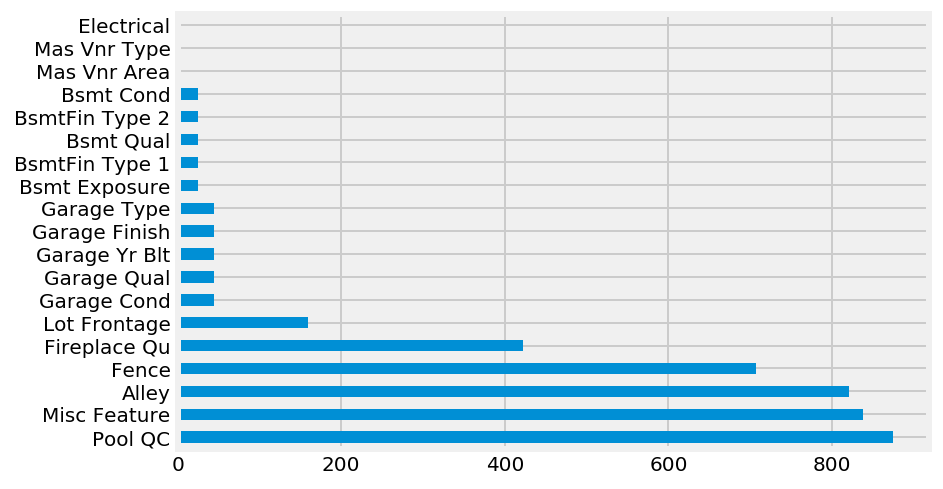

In [229]:
dftest_sum_null.plot(kind='barh'); #visualization of the number of nulls to be dealt with in the feature space..

```Pool QC```, ```Misc Feature```, ```Alley```, ```Fence```, and ```Fireplace Qu``` have substantial number of nulls...Let's examine them more closely before deciding whether to impute or drop these columns...

In [230]:
dftest[dftest['Pool QC'].isnull() & dftest['Pool Area']!=0][['Pool Area','Pool QC']] #examining whether there is any house with non-zero pool area where pool qc is null..

Empty DataFrame
Columns: [Pool Area, Pool QC]
Index: []

The above suggests that it is likely that all Pool QC nulls should be represented as 'No Pool' or 'NA' since the data suggests that houses with null Pool QC happen to have 0 Pool Area. Assuming this is indeed true, Pool QC nulls will be converted to the string, 'NA', which stands for No Pool based on the data dictionary.

In [231]:
dftest['Pool QC'] = dftest['Pool QC'].fillna('None') #filling NaNs with 'None'..

In [232]:
dftest['Pool QC'] = dftest['Pool QC'].map({'None':'NA'}) #erroneously filled null values with 'None'. Correcting that with .map() to convert 'None' into 'NA' instead.

In [233]:
dftest[dftest['Misc Feature'].isnull() & dftest['Misc Val']!=0][['Misc Feature','Misc Val']] #examining whether there is any house with non-zero pool area where pool qc is null..

Empty DataFrame
Columns: [Misc Feature, Misc Val]
Index: []

Similarly, the above suggests that those Misc Features that are null, are likely 'NA's or 'None' instead. As such, will replace these null values with the string, 'NA'.

In [234]:
dftest['Misc Feature'] = dftest['Misc Feature'].fillna('NA') #filling nulls with 'NA'..

As there are no other features to corroborate with ```Alley``` and ```Fence```, it is difficult to make educated guesses on how to fill the null values. Since there are more than 40% of nulls for these 2 columns and no reasonable conclusion can be drawn from this amount of data in these 2 columns, they will be dropped.

In [235]:
dftest=dftest.drop(['Alley','Fence'],axis=1)

In [236]:
dftest[dftest['Fireplace Qu'].isnull() & dftest['Fireplaces']!=0][['Fireplace Qu','Fireplaces']] #examining whether there is any house with non-zero pool area where pool qc is null..

Empty DataFrame
Columns: [Fireplace Qu, Fireplaces]
Index: []

Again, the above suggests the same concept applies for Fireplace Qu and Fireplaces. Will fill null values with 'NA', representing no fireplace.

In [237]:
dftest['Fireplace Qu'] = dftest['Fireplace Qu'].fillna('NA') #filling nulls with 'NA'..

In [238]:
dftest_sum_null = dftest.isnull().sum().sort_values(ascending=False) #re-filtering nulls in dftest and sorting from largest to smallest number of nulls by feature after the above imputations and modfications.

In [239]:
dftest_sum_null = dftest_sum_null[dftest_sum_null!=0] #converting the null features into a dataframe.

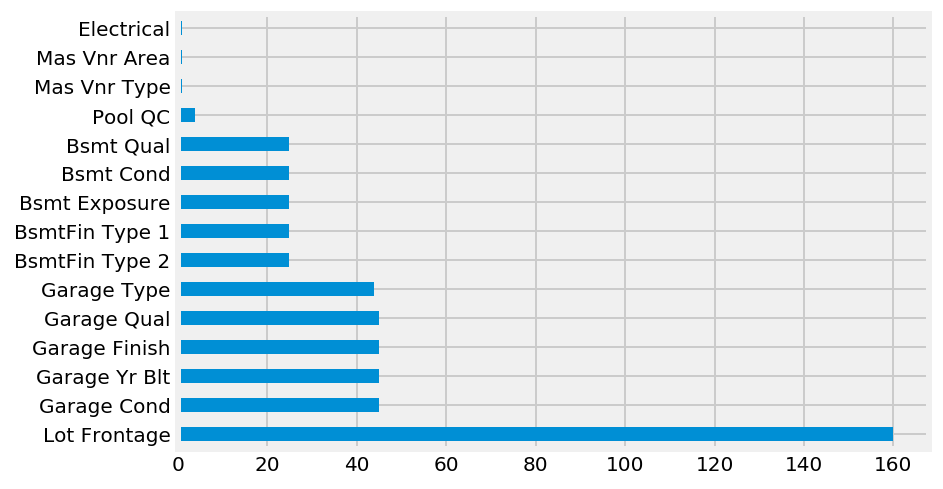

In [240]:
dftest_sum_null.plot(kind='barh'); #re-generating the visualization of the number of nulls to be dealt with in the feature space..

In [241]:
dftest_sum_null

Lot Frontage      160
Garage Cond        45
Garage Yr Blt      45
Garage Finish      45
Garage Qual        45
Garage Type        44
BsmtFin Type 2     25
BsmtFin Type 1     25
Bsmt Exposure      25
Bsmt Cond          25
Bsmt Qual          25
Pool QC             4
Mas Vnr Type        1
Mas Vnr Area        1
Electrical          1
dtype: int64

In [242]:
dftest_sum_null_dict = dftest_sum_null.to_dict()
dftest_sum_null_dict

{'Lot Frontage': 160,
 'Garage Cond': 45,
 'Garage Yr Blt': 45,
 'Garage Finish': 45,
 'Garage Qual': 45,
 'Garage Type': 44,
 'BsmtFin Type 2': 25,
 'BsmtFin Type 1': 25,
 'Bsmt Exposure': 25,
 'Bsmt Cond': 25,
 'Bsmt Qual': 25,
 'Pool QC': 4,
 'Mas Vnr Type': 1,
 'Mas Vnr Area': 1,
 'Electrical': 1}

/Users/jasonchia/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jasonchia/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


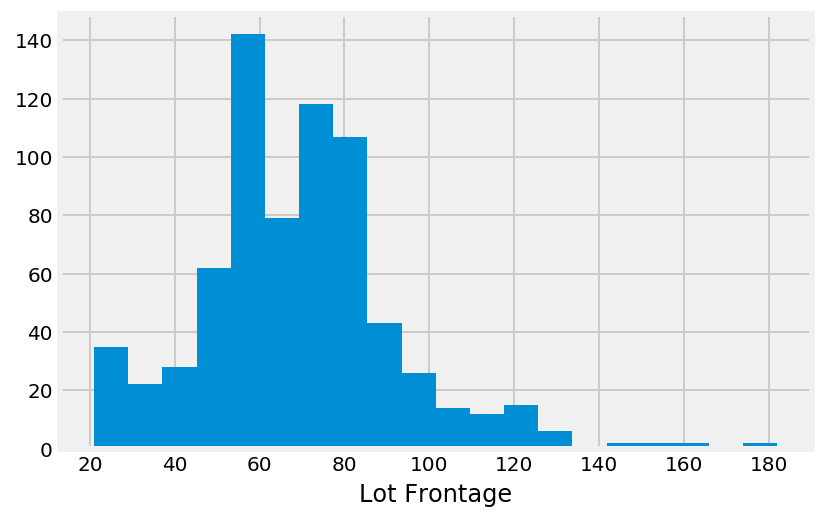

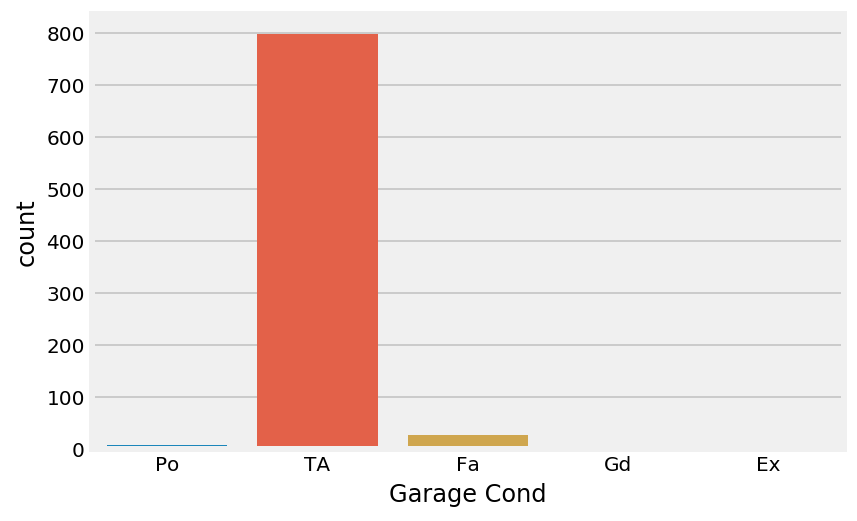

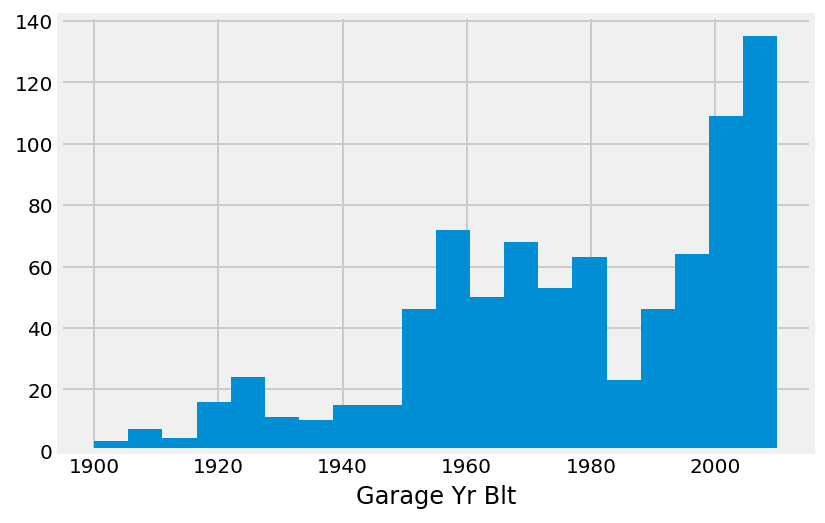

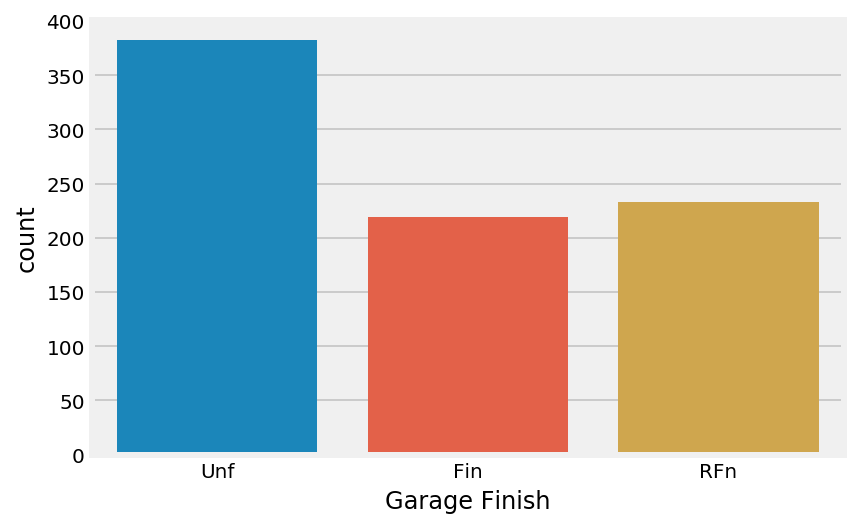

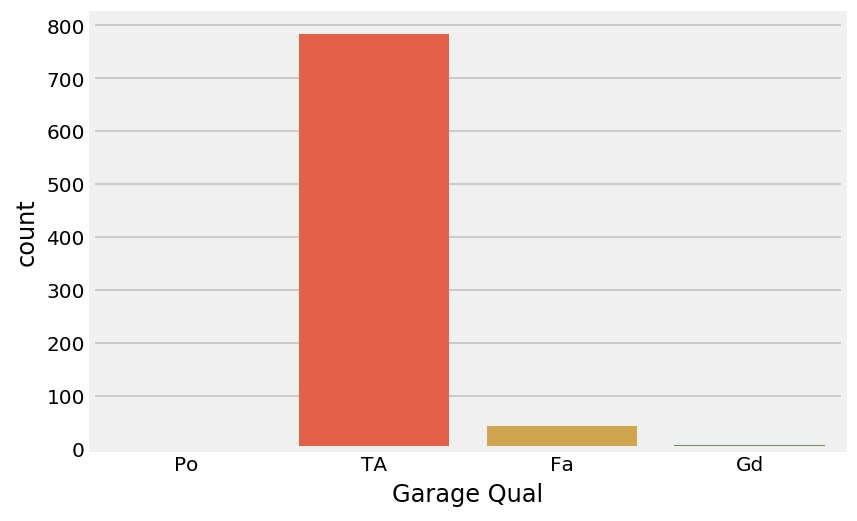

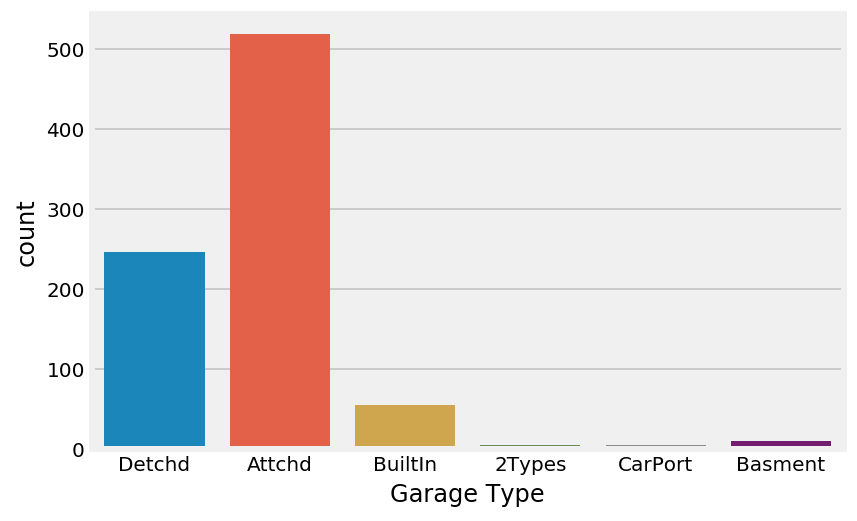

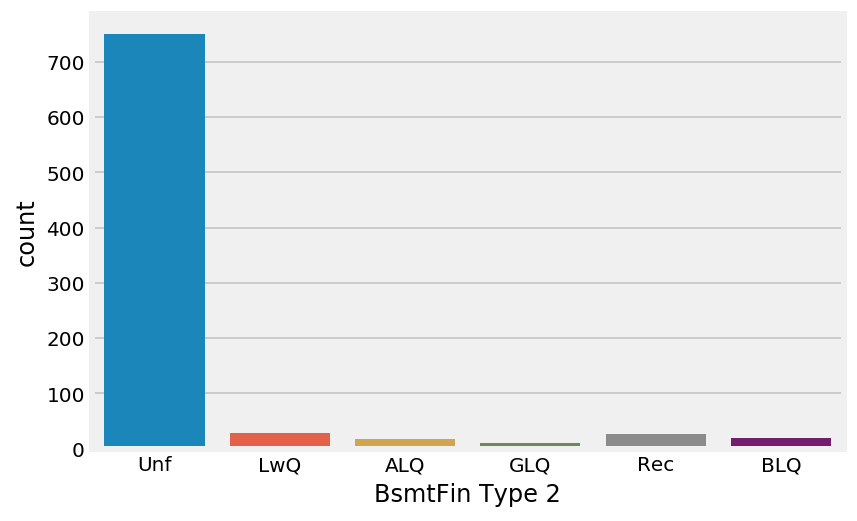

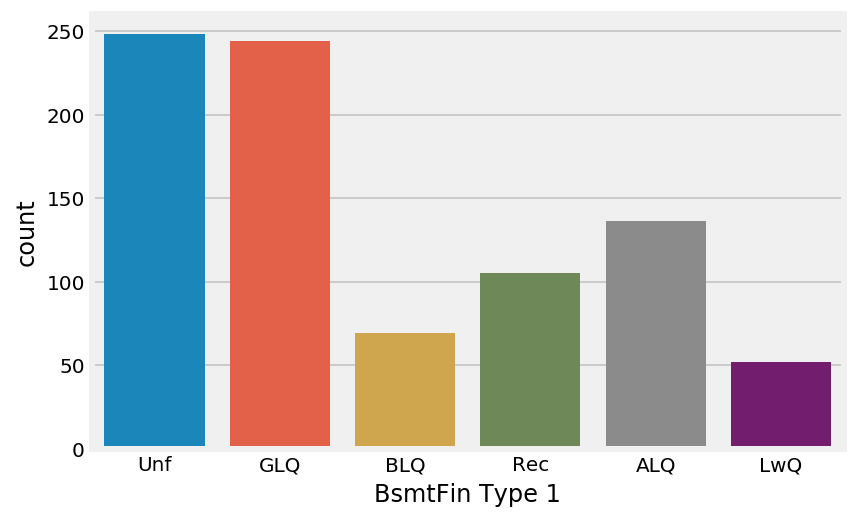

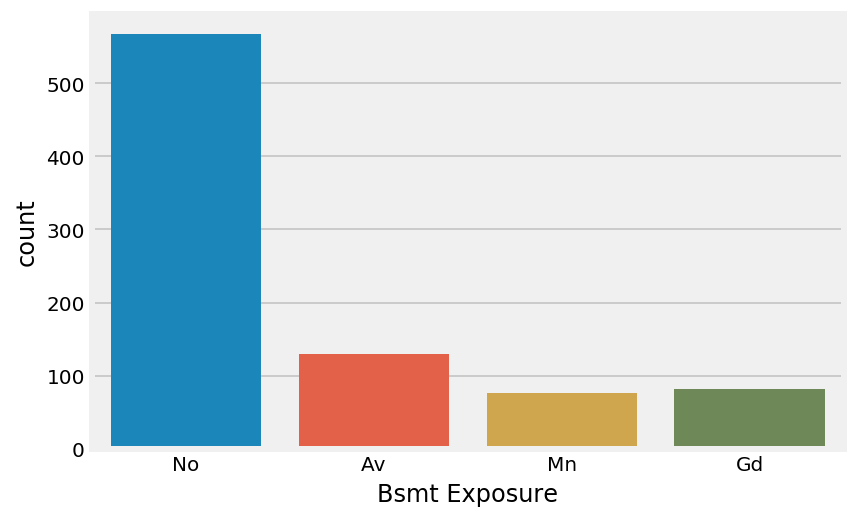

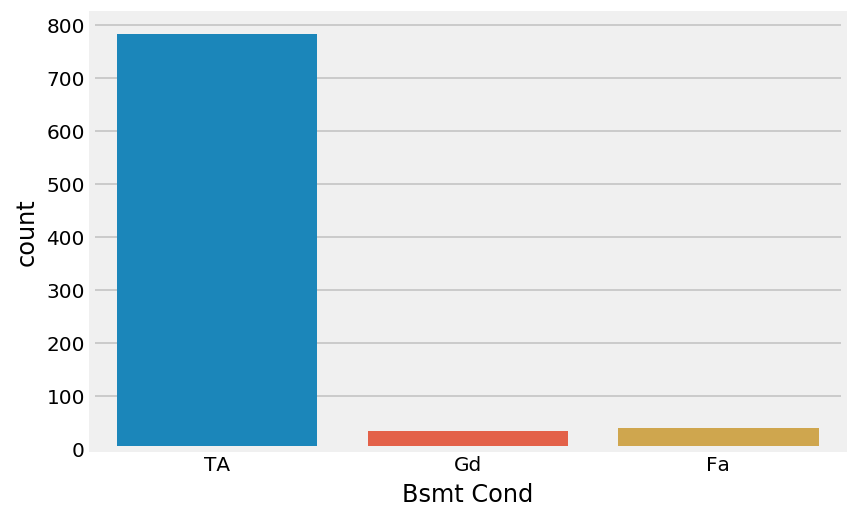

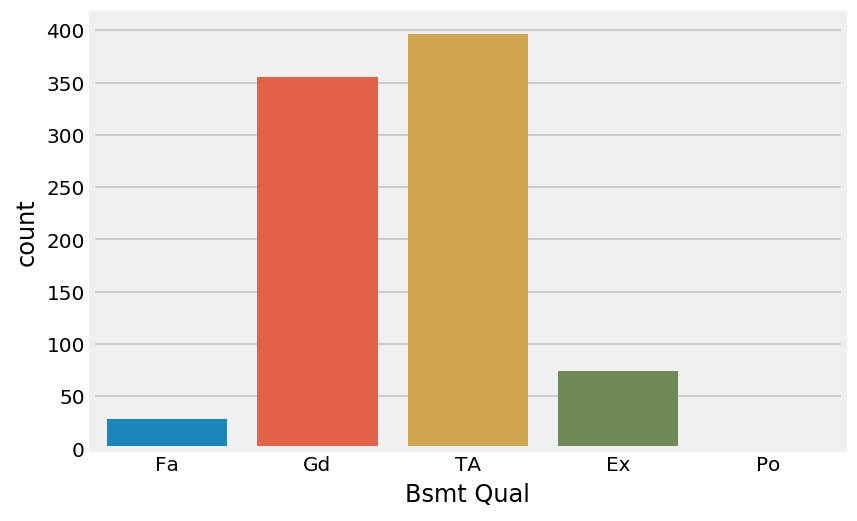

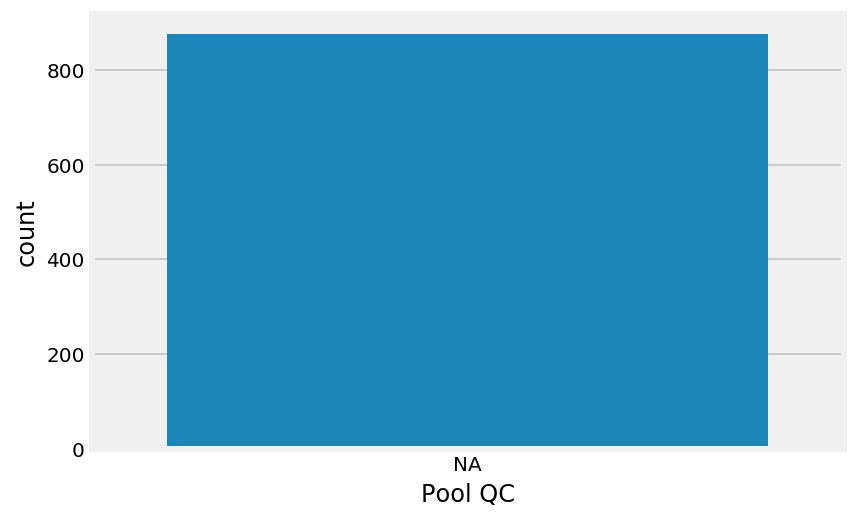

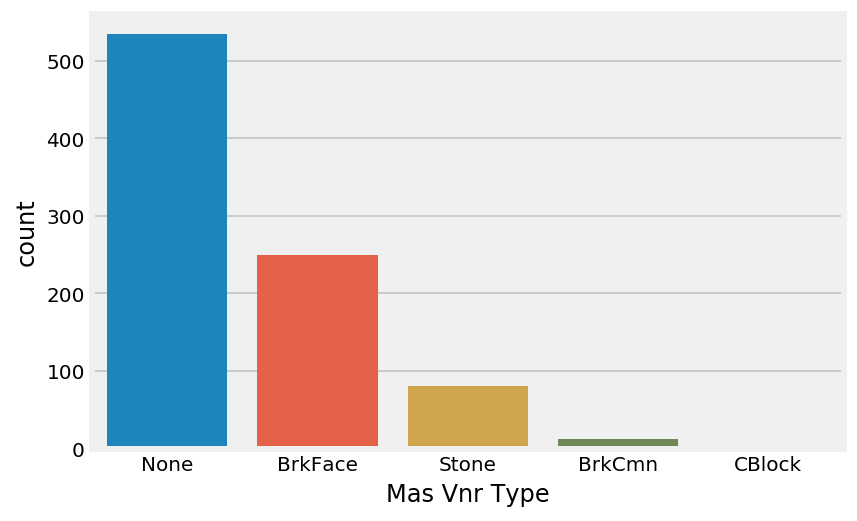

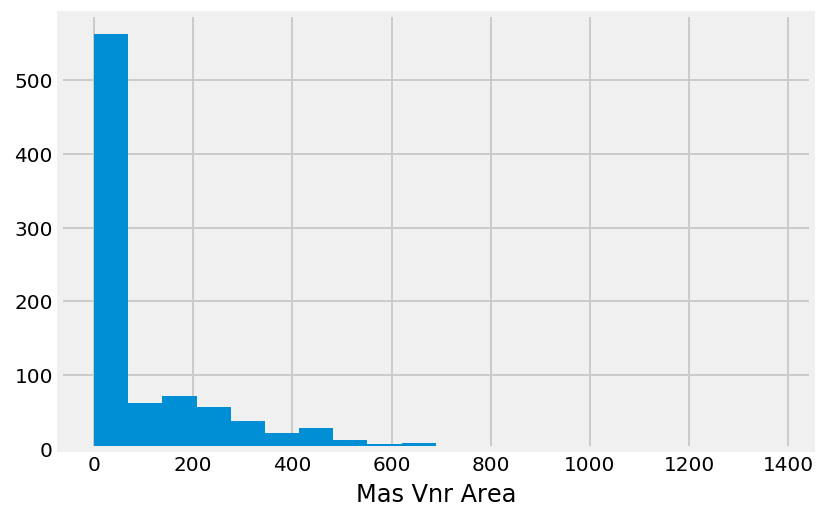

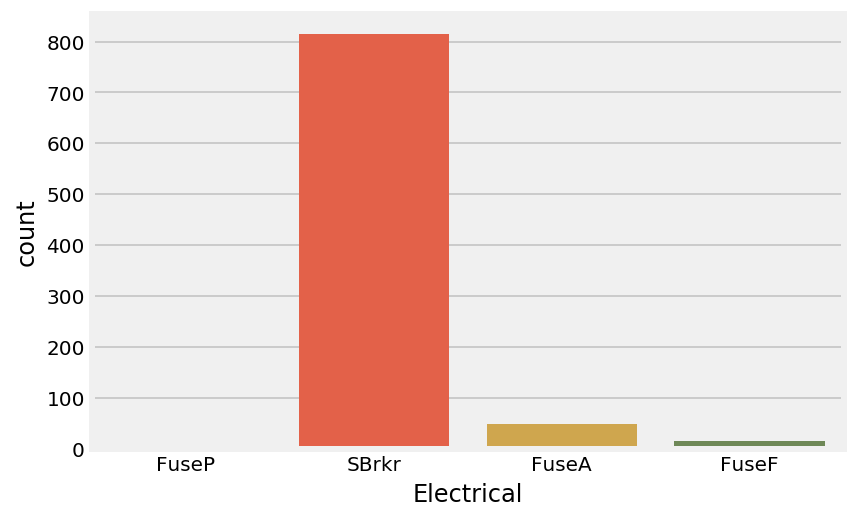

In [243]:
for i, col in enumerate(dftest_sum_null_dict.keys()): #Shows the countplots of categorical variables and histograms of numerical variables with null values
    if dftest[col].dtypes=='object':
        plt.figure(i)
        sns.countplot(x=col, data=dftest)
    else:
        plt.figure(i)
        plt.hist(dftest[col],bins=20)
        plt.xlabel(col)

In [244]:
for i, col in enumerate(dftest_sum_null_dict.keys()):
    if dftest[col].dtypes=='object':
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Imputing with most frequent for category.
        imp.fit(dftest[col].values.reshape(-1,1))
        dftest[col]=imp.transform(dftest[col].values.reshape(-1,1)) #Transforming to specified column

In [245]:
dftest_sum_null = dftest.isnull().sum().sort_values(ascending=False) #re-filtering nulls in dftest and sorting from largest to smallest number of nulls by feature after the above imputations and modfications.

In [246]:
dftest_sum_null = dftest_sum_null[dftest_sum_null!=0] #converting the null features into a dataframe.

In [247]:
dftest_sum_null #There are only 3 features with nulls to be dealt with now...

Lot Frontage     160
Garage Yr Blt     45
Mas Vnr Area       1
dtype: int64

For ```Garage Yr Blt```, it should be a nominal feature (which will be converted accordingly later on) and so it should be imputed with most frequent value just like the other categorical variables above.

In [248]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Imputing with most frequent for category.
imp.fit(dftest['Garage Yr Blt'].values.reshape(-1,1))
dftest['Garage Yr Blt']=imp.transform(dftest['Garage Yr Blt'].values.reshape(-1,1)) #Transforming to specified column

In [249]:
dftest['Lot Frontage'].describe() #retrieving summary statistics for Lot Frontage..

count    719.000000
mean      69.630042
std       23.625372
min       21.000000
25%       59.000000
50%       68.000000
75%       80.000000
max      182.000000
Name: Lot Frontage, dtype: float64

For ```Lot Frontage```, it appears that it follows a rather normal distribution (based on both the histogram and summary statistics above - where the mean is roughly aligned to the median). As such, mean imputation will be conducted.

In [250]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean') #Imputing with mean for category.
imp.fit(dftest['Lot Frontage'].values.reshape(-1,1))
dftest['Lot Frontage']=imp.transform(dftest['Lot Frontage'].values.reshape(-1,1)) #Transforming to specified column

In [251]:
dftest['Mas Vnr Area'].describe() #retrieving summary statistics for Mas Vnr Area..

count     878.000000
mean      106.982916
std       188.356829
min         0.000000
25%         0.000000
50%         0.000000
75%       173.500000
max      1378.000000
Name: Mas Vnr Area, dtype: float64

For ```Mas Vnr Area```, it appears that its distribution is significantly right skewed based on both the histogram and summary statistics - where the mean is significantly higher than the median). As such, median imputation will be conducted.

In [252]:
imp = SimpleImputer(missing_values=np.nan, strategy='median') #Imputing with median for category.
imp.fit(dftest['Mas Vnr Area'].values.reshape(-1,1))
dftest['Mas Vnr Area']=imp.transform(dftest['Mas Vnr Area'].values.reshape(-1,1)) #Transforming to specified column

In [253]:
sum(dftest.isnull().sum().values.tolist()) #confirming there are no longer any nulls in the dataframe..

0

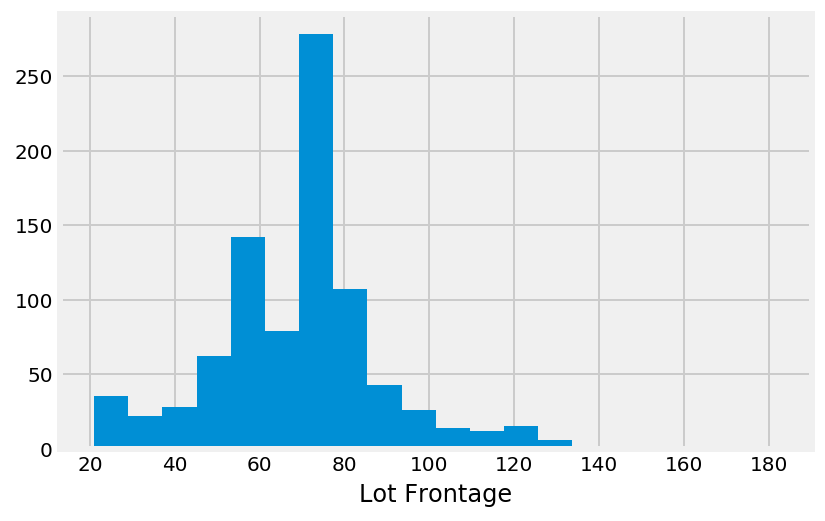

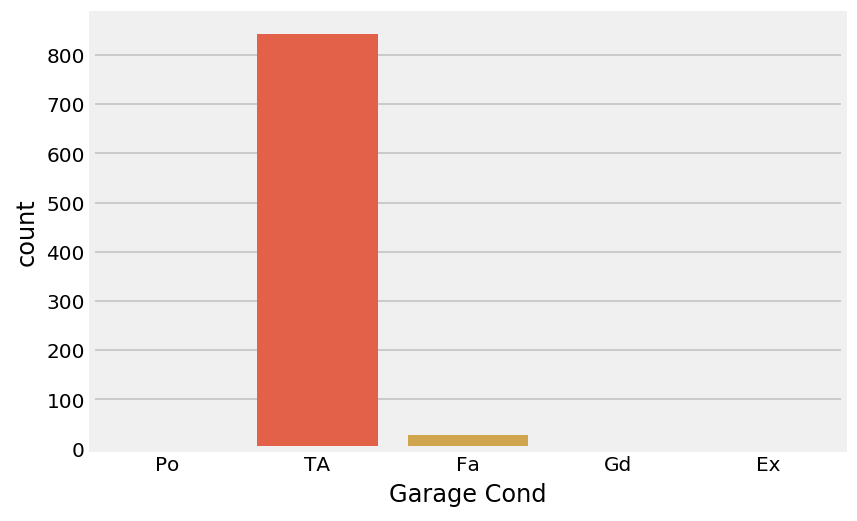

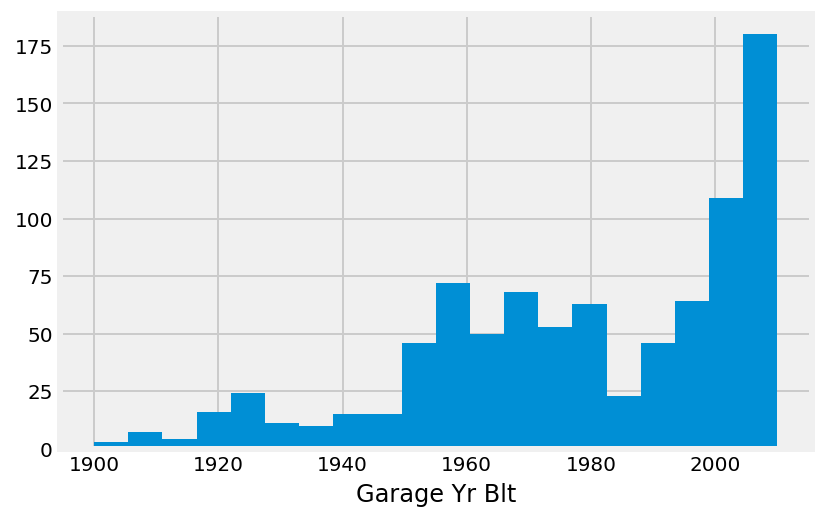

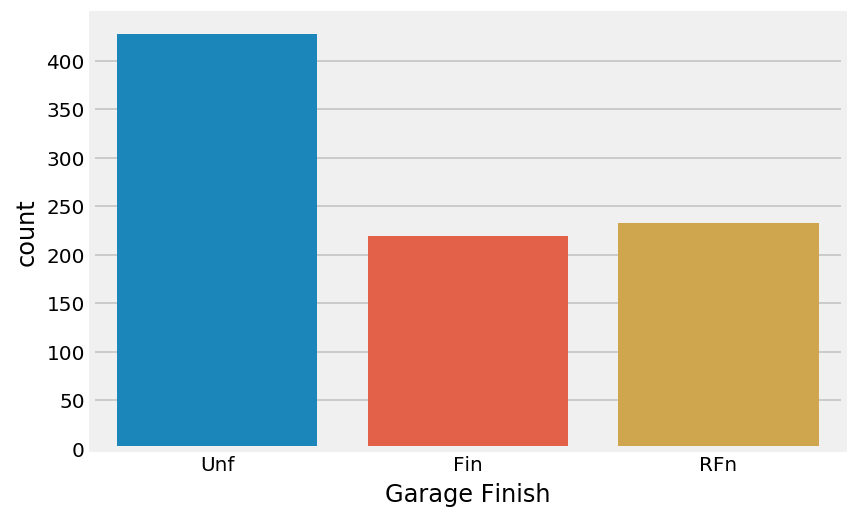

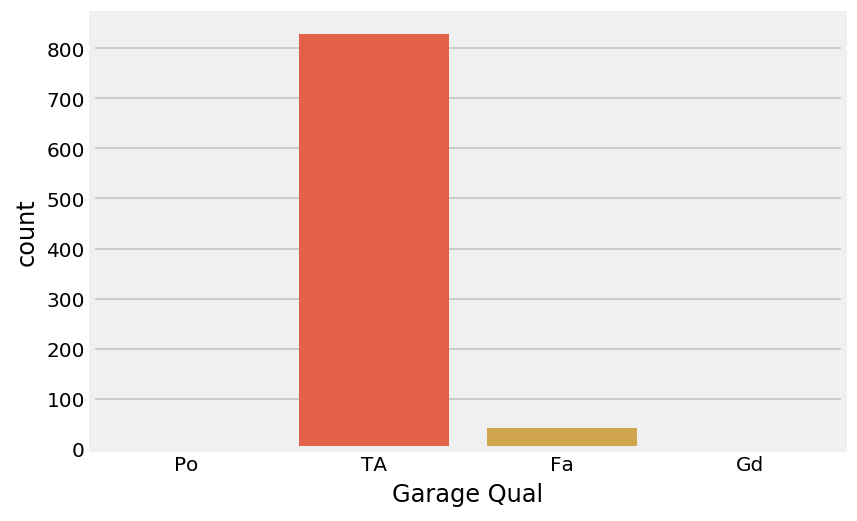

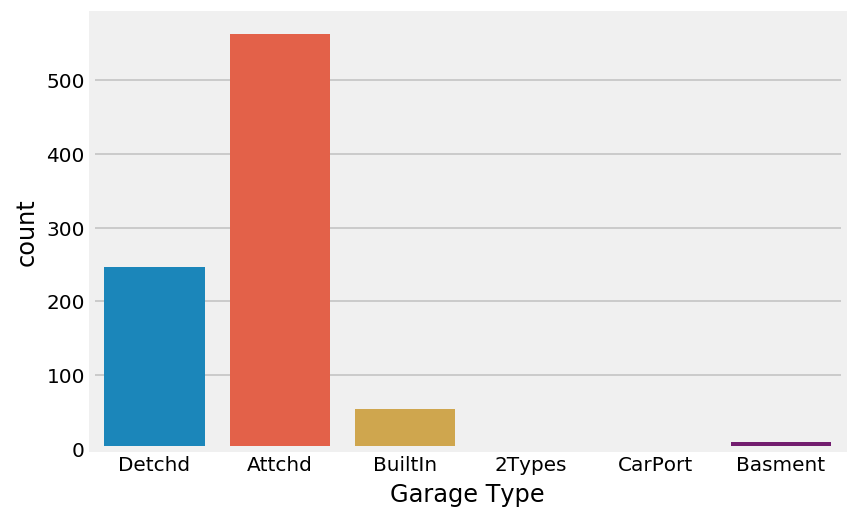

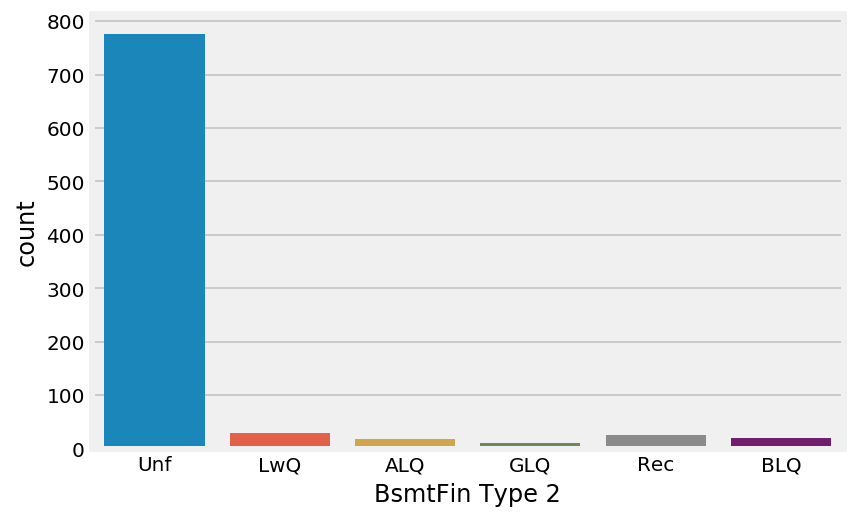

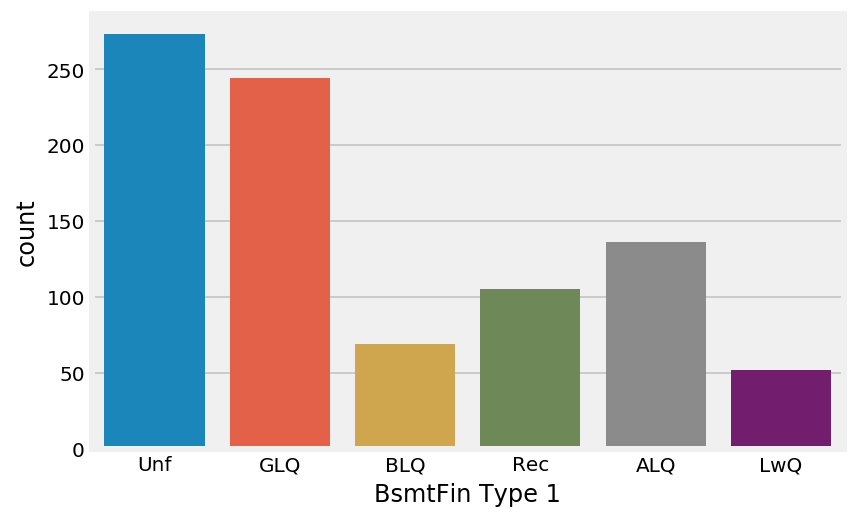

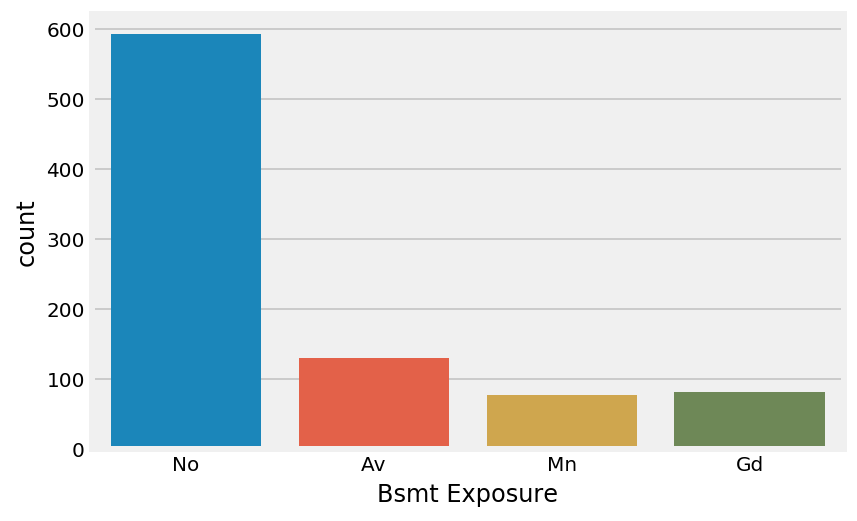

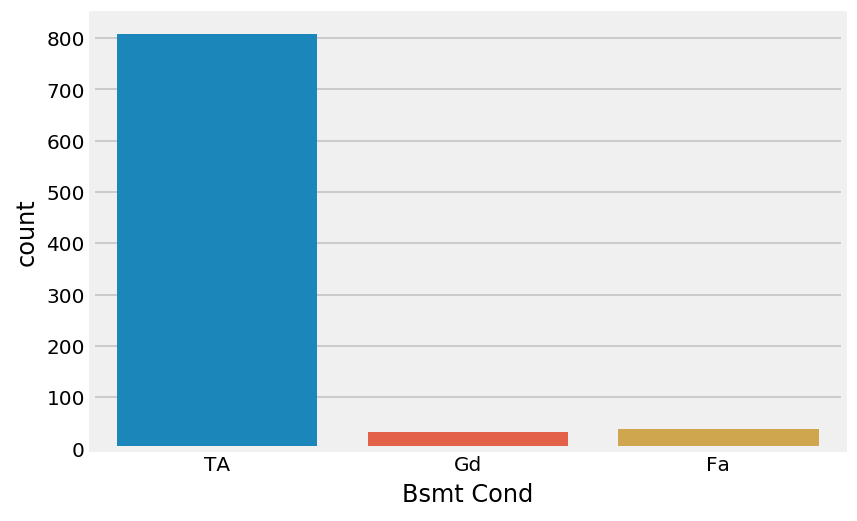

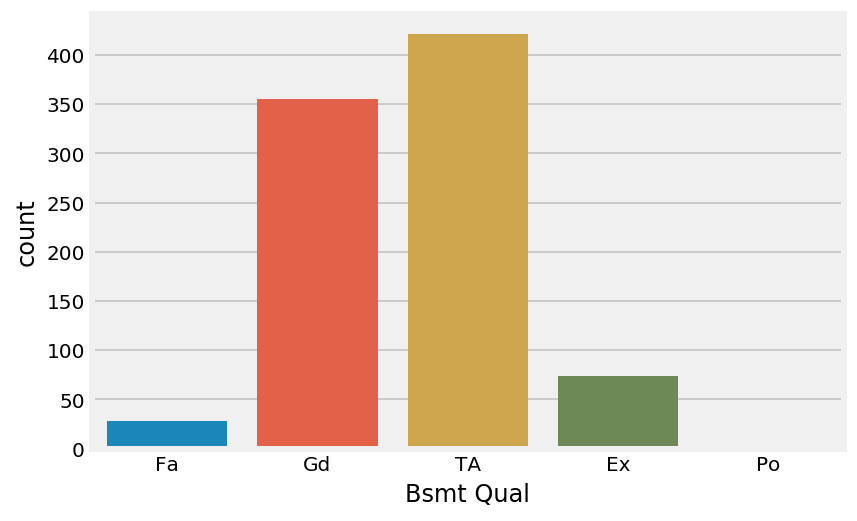

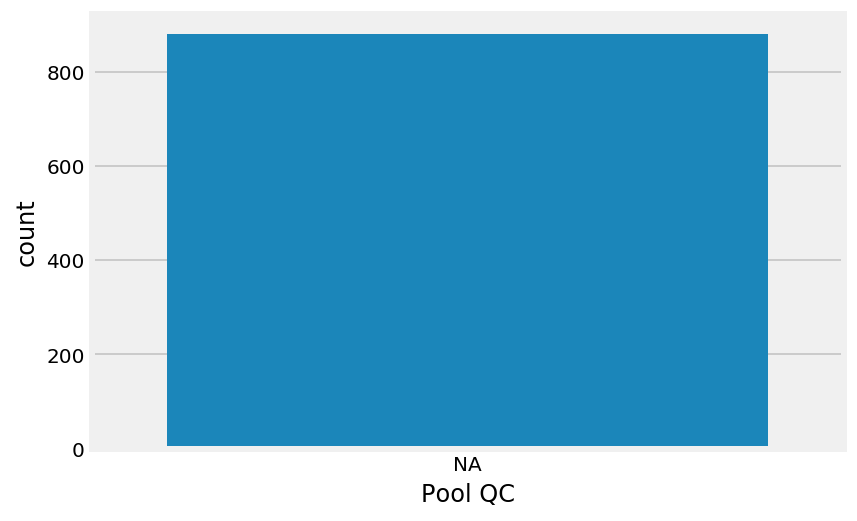

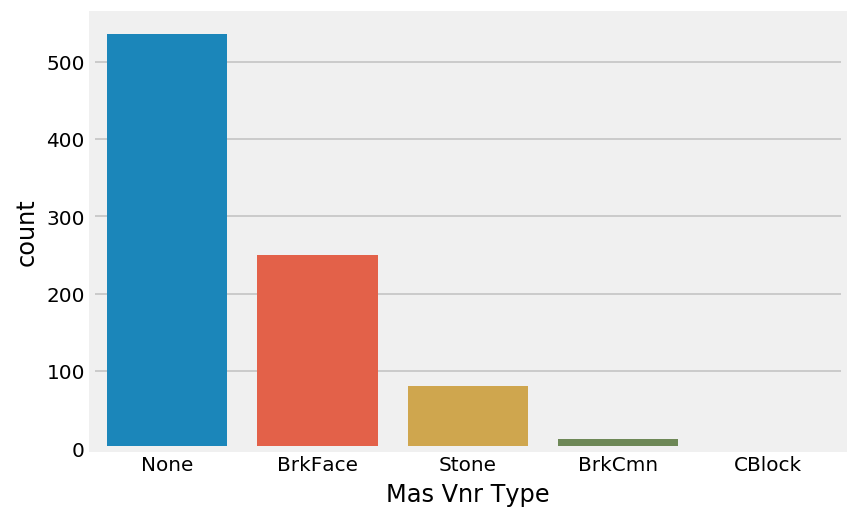

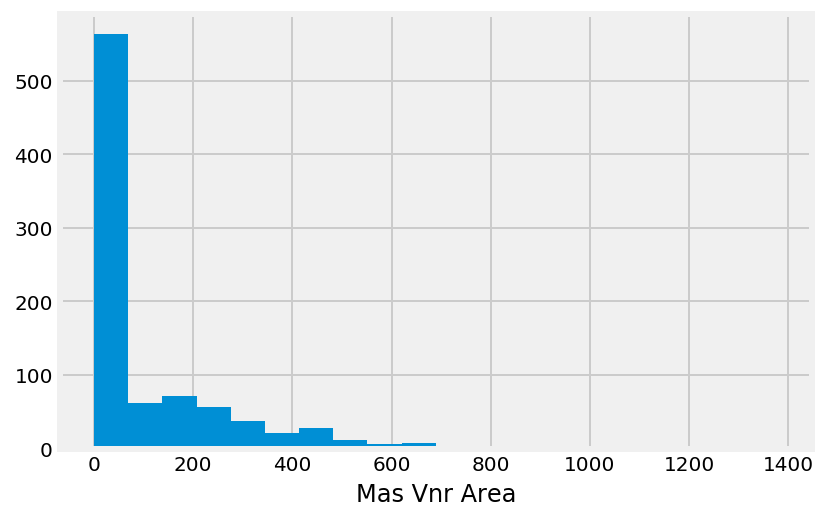

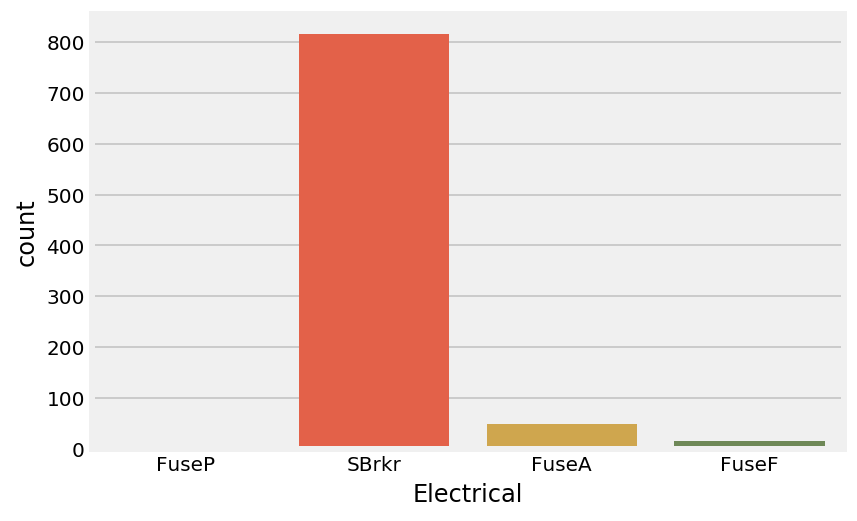

In [254]:
for i, col in enumerate(dftest_sum_null_dict.keys()): #Shows the countplots of categorical variables and histograms of numerical variables with null values
    if dftest[col].dtypes=='object':
        plt.figure(i)
        sns.countplot(x=col, data=dftest)
    else:
        plt.figure(i)
        plt.hist(dftest[col],bins=20)
        plt.xlabel(col)

Imputations based on mean, median or mode constitute "educated guesses" that may affect eventual model performance..

In [255]:
dftest.info() #looking at which data types to convert accordingly..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               879 non-null    int64  
 1   PID              879 non-null    int64  
 2   MS SubClass      879 non-null    int64  
 3   MS Zoning        879 non-null    object 
 4   Lot Frontage     879 non-null    float64
 5   Lot Area         879 non-null    int64  
 6   Street           879 non-null    object 
 7   Lot Shape        879 non-null    object 
 8   Land Contour     879 non-null    object 
 9   Utilities        879 non-null    object 
 10  Lot Config       879 non-null    object 
 11  Land Slope       879 non-null    object 
 12  Neighborhood     879 non-null    object 
 13  Condition 1      879 non-null    object 
 14  Condition 2      879 non-null    object 
 15  Bldg Type        879 non-null    object 
 16  House Style      879 non-null    object 
 17  Overall Qual    

The data types will be converted accordingly.. In essence, nominal features such as ```Garage Yr Blt``` and ```Yr Sold``` will be coded as string objects and undergo ```pd.get_dummies``` to assign 1s and 0s to them so as to facilitate processing by the model subsequently. Ordinal features will have integer valeus mapped to their various ordered levels and thus be converted to integers while features that are of continuous numerical format where values can take on an infinite number of possible values such as ```Gr Liv Area``` or ```Total Bsmt SF``` as well as countable discrete values will be coded in the float format. Discrete countable features such as ```TotRms AbvGrd``` will be coded as floats to distinguish them from the ordinal features (which have various integer-coded levels.  

In [256]:
dftest['PID'] = dftest['PID'].apply(lambda val: '0'+str(val))
dftest['MS SubClass'] = dftest['MS SubClass'].apply(lambda val: '0'+str(val) if len(str(val))==2 else str(val))
dftest['Lot Area'] = dftest['Lot Area'].astype(float)
dftest['Lot Shape']= dftest['Lot Shape'].map({'Reg':1,'IR1':2,'IR2':3,'IR3':4})
dftest['Utilities']= dftest['Utilities'].map({'AllPub':1,'NoSewr':2,'NoSeWa':3,'ELO':4})
dftest['Land Slope']= dftest['Land Slope'].map({'Gtl':1,'Mod':2,'Sev':3})
dftest['Year Built'] = dftest['Year Built'].astype(str)
dftest['Year Remod/Add'] = dftest['Year Remod/Add'].astype(str)
dftest['Exter Qual']= dftest['Exter Qual'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5})
dftest['Exter Cond']= dftest['Exter Cond'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5})
dftest['Bsmt Qual']= dftest['Bsmt Qual'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5,'NA':6})
dftest['Bsmt Cond']= dftest['Bsmt Cond'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5,'NA':6})
dftest['Bsmt Exposure']= dftest['Bsmt Exposure'].map({'Gd':1,'Av':2,'Mn':3,'No':4,'NA':5})
dftest['BsmtFin Type 1']= dftest['BsmtFin Type 1'].map({'GLQ':1,'ALQ':2,'BLQ':3,'Rec':4,'LwQ':5,'Unf':6,'NA':7})
dftest['BsmtFin SF 1'] = dftest['BsmtFin SF 1'].astype(float)
dftest['BsmtFin Type 2']= dftest['BsmtFin Type 2'].map({'GLQ':1,'ALQ':2,'BLQ':3,'Rec':4,'LwQ':5,'Unf':6,'NA':7})
dftest['BsmtFin SF 2'] = dftest['BsmtFin SF 2'].astype(float)
dftest['Bsmt Unf SF'] = dftest['Bsmt Unf SF'].astype(float)
dftest['Total Bsmt SF'] = dftest['Total Bsmt SF'].astype(float)
dftest['Heating QC']= dftest['Heating QC'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5})
dftest['Electrical']= dftest['Electrical'].map({'SBrkr':1,'FuseA':2,'FuseF':3,'FuseP':4,'Mix':5})
dftest['1st Flr SF'] = dftest['1st Flr SF'].astype(float)
dftest['2nd Flr SF'] = dftest['2nd Flr SF'].astype(float)
dftest['Low Qual Fin SF'] = dftest['Low Qual Fin SF'].astype(float)
dftest['Gr Liv Area'] = dftest['Gr Liv Area'].astype(float)
dftest['Bsmt Full Bath'] = dftest['Bsmt Full Bath'].astype(float)
dftest['Bsmt Half Bath'] = dftest['Bsmt Half Bath'].astype(float)
dftest['Full Bath'] = dftest['Full Bath'].astype(float)
dftest['Half Bath'] = dftest['Half Bath'].astype(float)
dftest['Bedroom AbvGr'] = dftest['Bedroom AbvGr'].astype(float)
dftest['Kitchen AbvGr'] = dftest['Kitchen AbvGr'].astype(float)
dftest['Kitchen Qual']= dftest['Kitchen Qual'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5})
dftest['TotRms AbvGrd'] = dftest['TotRms AbvGrd'].astype(float)
dftest['Functional']= dftest['Functional'].map({'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1})
dftest['Fireplaces'] = dftest['Fireplaces'].astype(float)
dftest['Fireplace Qu']= dftest['Fireplace Qu'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5,'NA':6})
dftest['Garage Yr Blt'] = dftest['Garage Yr Blt'].astype(str)
dftest['Garage Finish']= dftest['Garage Finish'].map({'Fin':1,'RFn':2,'Unf':3,'NA':4})
dftest['Garage Cars'] = dftest['Garage Cars'].astype(float)
dftest['Garage Area'] = dftest['Garage Area'].astype(float)
dftest['Garage Qual']= dftest['Garage Qual'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5,'NA':6})
dftest['Garage Cond']= dftest['Garage Cond'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'Po':5,'NA':6})
dftest['Paved Drive']= dftest['Paved Drive'].map({'Y':1,'P':2,'N':3})
for col in ['Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area']:
    dftest[col] = dftest[col].astype(float)
dftest['Pool QC']= dftest['Pool QC'].map({'Ex':1,'Gd':2,'TA':3,'Fa':4,'NA':5})
dftest['Misc Val'] = dftest['Misc Val'].astype(float)
dftest['Mo Sold'] = dftest['Mo Sold'].astype(str)
dftest['Yr Sold'] = dftest['Yr Sold'].astype(str)

In [257]:
dftest.info() #cleaned test dataset!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               879 non-null    int64  
 1   PID              879 non-null    object 
 2   MS SubClass      879 non-null    object 
 3   MS Zoning        879 non-null    object 
 4   Lot Frontage     879 non-null    float64
 5   Lot Area         879 non-null    float64
 6   Street           879 non-null    object 
 7   Lot Shape        879 non-null    int64  
 8   Land Contour     879 non-null    object 
 9   Utilities        879 non-null    int64  
 10  Lot Config       879 non-null    object 
 11  Land Slope       879 non-null    int64  
 12  Neighborhood     879 non-null    object 
 13  Condition 1      879 non-null    object 
 14  Condition 2      879 non-null    object 
 15  Bldg Type        879 non-null    object 
 16  House Style      879 non-null    object 
 17  Overall Qual    

In [258]:
dftest.shape #checking out the dimensions of the cleaned dftest dataset. 

(879, 78)

In [259]:
new_col_names_test = {col:col.lower().replace(' ','_') for col in dftest.columns} #formatting all features' names to lower case and converting spaces to underscores.

In [260]:
dftest=dftest.rename(columns=new_col_names_test) #renaming the columns accordingly for this hold-out set.

In [261]:
dftest=dftest.drop(['id','pid'],axis=1) #removing id and pid features as they will not be used in the prediction process and they will throw up additional unnecessary columns after passing through pd.get_dummies.

In [262]:
dftest=pd.get_dummies(dftest, drop_first=True) #getting dummies for nominal features so that they are in a better format to be analyzed by the model.

In [263]:
dftest.shape #dftest has 463 columns

(879, 463)

In [264]:
len(vif_lst) #the subset of features to be used only has 107 features.

107

In [265]:
intersection_col = [] #Identifying only the columns from vif_lst (final list from the latest ElasticNet assessment above) that are present in the dftest dataframe so that predictions will not go haywire... 
for col in vif_lst:
    if col in dftest.columns:
        intersection_col.append(col)

In [266]:
len(intersection_col) #Appears there are some columns in vif_lst that are not present in the dftest...We will use this intersection_col to predict the target for dftest.

98

Running ```ElasticNet```, the chosen model, on this ```intersection_col``` list of features to evaluate its performance and get some sense of how well it will perform predicting ```test.csv```.

In [267]:
X2 = X[intersection_col]  #defining the predictor and target variables containing only the common columns between vif_lst and dftest
y = df['saleprice'].values

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state=42)  #splitting the data into training and test sets to evaluate the model using the common features between the actual test csv and the training dataset.

In [269]:
scaler = StandardScaler() #instantiating the scaler.

In [270]:
scaler.fit(X_train)  #Scaling on X_train and transforming both X_train and X_test
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [271]:
l1_ratios_tts = np.linspace(0.01, 1.0, 25) #searching for optimal alphas and l1_ratios for the X_train_sc

optimal_enet_tts = ElasticNetCV(l1_ratio=l1_ratios_tts, n_alphas=600, cv=5,   #cross-validation with 5 folds
                            verbose=1)
optimal_enet_tts.fit(X_train_sc, y_train) #training the ElasticNet on the training sets

print(optimal_enet_tts.alpha_)   #printing the optimal alpha
print(optimal_enet_tts.l1_ratio_)  #printing the optimal l1_ratio

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

628.0397880093639
1.0


...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   33.9s finished


In [272]:
enet_tts = ElasticNet(alpha=optimal_enet_tts.alpha_, l1_ratio=optimal_enet_tts.l1_ratio_) #instantiating ElasticNet with optimal alpha and l1_ratio
enet_tts.fit(X_train_sc, y_train) #training on training data
predictions_enet_train_tts = enet_tts.predict(X_train_sc) #predicting on training data
print('Reg metrics for training set: ')
reg_metrics(y_train, predictions_enet_train_tts, X2.shape[1]) #prints regression metrics for testing on training data

Reg metrics for training set: 
Mean squared error      =  652003899.1811206
Root mean squared error =  25534.367021352235
Mean squared log error  =  0.02407754409495916
Median absolute error   =  11963.006035072685
R^2                     =  0.8969085597316615
Adjusted R^2            =  0.8898877389211701


In [273]:
predictions_enet_test_tts = enet_tts.predict(X_test_sc) #predicting on test set
print('Reg metrics for test set: ')
reg_metrics(y_test, predictions_enet_test_tts, X2.shape[1]) #prints regression metrics for testing on test set

Reg metrics for test set: 
Mean squared error      =  725009013.2502778
Root mean squared error =  26925.99140700817
Mean squared log error  =  0.025582923373582974
Median absolute error   =  13716.651217957842
R^2                     =  0.8819208317401085
Adjusted R^2            =  0.8539697242776221


Turns out that using the ```intersection_col``` list of features, the R2 between training and test set is not so different and the difference between the adjusted R2 and R2 for the test set is not big either. Overall, the R2 and adjusted R2 are pretty good at ~0.88 and ~0.85 respectively. The increase in Root mean squared error (RMSE) was not very significant (26,926 dollars - 25,534 dollars= 1,392 dollars) given the spread of the ```SalePrice``` target. Let's now predict the dftest's ```SalePrice```! 

In [274]:
dftest1 = dftest[intersection_col] #subsetting only the intersection columns for our test.csv/dftest

In [275]:
scaler2 = StandardScaler() #instantiating the scaler

In [276]:
dftest_sc = scaler2.fit_transform(dftest1) #scaling our subsetted dftest

In [277]:
dftest_sc.shape #number of features in our dftest_sc is 98

(879, 98)

In [278]:
X_train_sc.shape #so is the number of features in our X_train_sc!

(1538, 98)

The above 2 cells confirmed that the number of features used in ```X_train_sc``` in the ```ElasticNet``` model right before is the same as that for this ```dftest_sc```, so that predictions can be made subsequently with ```enet_tts.predict(dftest_sc)``` as shown below.

In [279]:
predictions_kaggle = enet_tts.predict(dftest_sc) #finally, making predictions on dftest/test.csv and saving them to "predictions_kaggle"

In [280]:
predictions_kaggle_df=pd.DataFrame(predictions_kaggle, columns=['SalePrice']) #converting the predictions_kaggle to a dataframe with column header being the target, "SalePrice".

In [281]:
ames_test_csv = '../datasets/test.csv'  #noticed that I had dropped "Id" from dftest above, thus reading in the test.csv again to obtain the "Id" column..
dftest_1 = pd.read_csv(ames_test_csv)

In [282]:
predictions_kaggle_df['Id']=dftest_1['Id'] #including the "Id" column in our predictions_kaggle dataframe from the newly read in test.csv..

In [283]:
predictions_kaggle_df=predictions_kaggle_df.reindex(columns=['Id','SalePrice']) #re-arranging the columns so that the format is aligned to Kaggle submission's...

In [284]:
predictions_kaggle_df.to_csv('../datasets/kaggle_pred_2.csv',index=False) #saving the predictions_kaggle_df into a csv file for submission to Kaggle

<img src="../images/preds.png"/>

Obtained a Kaggle score of ~36,187 dollars for RMSE as shown above which is quite decent given that the RMSEs ranged between ~20,000 to ~300,000 dollars based on the [Kaggle](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge/leaderboard) leaderboard.

In [285]:
lasso_coefs.head(30) #looking at top 30 list of important features filtered by lasso earlier just to recap the top few features chosen by lasso.

variable          coef      abs_coef
24            gr_liv_area  20153.565203  20153.565203
5            overall_qual  13901.282070  13901.282070
97   neighborhood_NridgHt   8992.942229   8992.942229
49               misc_val  -6797.919365   6797.919365
103  neighborhood_StoneBr   5924.300827   5924.300827
31           kitchen_qual  -5920.209843   5920.209843
8              exter_qual  -5368.169008   5368.169008
10              bsmt_qual  -5349.654186   5349.654186
12          bsmt_exposure  -4977.241518   4977.241518
37            garage_cars   4475.731914   4475.731914
96   neighborhood_NoRidge   4341.214950   4341.214950
14           bsmtfin_sf_1   3984.746975   3984.746975
124      bldg_type_TwnhsE  -3635.626669   3635.626669
456  garage_yr_blt_2009.0   3507.213279   3507.213279
46           screen_porch   3266.629447   3266.629447
7            mas_vnr_area   3259.261014   3259.261014
6            overall_cond   2984.681325   2984.681325
460     misc_feature_Gar2   2859.492032   2859.492032
35           fireplace_qu  -2812.178577   2812.178577
25         bsmt_full_bath   2739.492512   2739.492512
88   neighborhood_GrnHill   2659.711974   2659.711974
72       land_contour_HLS   2628.927634   2628.927634
1                lot_area   2562.538959   2562.538959
123       bldg_type_Twnhs  -2478.369284   2478.369284
18          total_bsmt_sf   2405.877349   2405.877349
485         sale_type_New   2289.904143   2289.904143
48                pool_qc   2175.743633   2175.743633
316  exterior_1st_BrkFace   2172.998366   2172.998366
13         bsmtfin_type_1  -2103.271854   2103.271854
21             1st_flr_sf   2080.600391   2080.600391

In [286]:
lasso_var = lasso_coefs['variable'].head(90).values.tolist() #converting top 90 of the lasso-filtered features to a list for subsequent manipulation.

In [287]:
presentation_col = []   #determining which of those lasso-filtered features (top 90) are present in the intersection_col, where the top few will be used for illustration in the recommendations' section
for col in lasso_var:
    if col in intersection_col:
        presentation_col.append(col)

In [288]:
presentation_col #will pick the top few of this for the subsequnt sections..

['overall_qual',
 'neighborhood_NridgHt',
 'misc_val',
 'neighborhood_StoneBr',
 'kitchen_qual',
 'exter_qual',
 'bsmt_qual',
 'bsmt_exposure',
 'garage_cars',
 'neighborhood_NoRidge',
 'bsmtfin_sf_1',
 'bldg_type_TwnhsE',
 'garage_yr_blt_2009.0',
 'screen_porch',
 'mas_vnr_area',
 'overall_cond',
 'fireplace_qu',
 'bsmt_full_bath',
 'land_contour_HLS',
 'lot_area',
 'bldg_type_Twnhs',
 'total_bsmt_sf',
 'sale_type_New',
 'pool_qc',
 'exterior_1st_BrkFace',
 'bsmtfin_type_1',
 '1st_flr_sf',
 'house_style_1Story',
 'functional',
 'ms_subclass_120',
 'misc_feature_Othr',
 'wood_deck_sf',
 'condition_1_Norm',
 'roof_style_Hip',
 'neighborhood_Crawfor',
 'heating_qc',
 'neighborhood_Somerst',
 'year_built_2008',
 'kitchen_abvgr',
 'full_bath',
 'year_built_1892',
 'lot_config_CulDSac',
 'neighborhood_Edwards',
 'exterior_1st_Stucco',
 'condition_1_PosN',
 'exterior_1st_CemntBd',
 'garage_qual',
 'garage_area',
 'roof_matl_WdShngl',
 'ms_zoning_RM',
 'exterior_1st_Wd Sdng',
 'year_built_200

## Interpretation of Results
---
- The final R2 score of 0.88 reflects a pretty good model performance, which suggests that 88% of the variance in ```SalePrice``` is explained by the predictors and the model. Initially, we witnessed that ```LinearRegression``` performed worse than the Naive baseline model (mean of target, ```SalePrice```), resulting in a negative R2 score of ~-3 and this is possibly because ```LinearRegression``` fails to achieve low enough bias when the predictor count gets considerably high such as this case, especially after the predictor count shoots up after ```pd.get_dummies```. Regularized regression on the other hand, is better at handling highly complex models with multiple predictors by contraining large coefficients to reduce model complexity and variance so that it can generalize better to unseen data. In the process, regularized regression curbs issues of multi-collinearity and even feature selection (```Lasso```, where small coefficients-relatively unimportant features-are zeroed out).


- It appears that features identified to be significantly correlated to the target, ```SalePrice``` early on via initial exploratory data analysis based on visualizations such as heatmap, boxplot, and scatterplot, tend to remain in the final regression model containing important predictors that contribute to the target. Significant numerical and ordinal predictors may be identifiable early on (and a "first-cut" manual "feature selection" could be done before using feature selection regularisation (```Lasso``` for example)) prior to model development through heatmap while nominal predictors may be identifiable through boxplots for instance.
 
 
- In the model evaluation aspect where multi-collinearity between predictors was examined (related to one of MLR's assumptions-independence of predictors) using VIF, ```Gr_Liv_Area``` was identified to have a significant VIF score which indicates that it contributes considerably to collinearity if it remains in the model. Upon removing it from the list of features to be considered, the R2 dropped but not by much and this dip could reflect a slight increase in bias (model becomes slightly simpler without one of the features) but also, a possible reduction in variance (since the model is slightly less complex, less likely to overfit and more likely to generalize to unseen data later on. ```Gr_Liv_Area``` however, is one of the top predictors for ```SalePrice``` as identified by ```Lasso``` regression but because it is also the only numerical predictor that has a VIF score larger than 10 which is considered to be problematic by non-conservative schools of thought ([source](https://www.statisticshowto.datasciencecentral.com/variance-inflation-factor/)), the necessary evil of removing it has to be committed.


- In attempting to make the processing of the ```test.csv``` dataset as distinct as possible from that of ```train.csv``` (same reason why data undergoes ```train_test_split``` first before scaling by ```StandardScaler``` and not the other way round to prevent ["data leakage"](https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split) so as to avoid biasing model performance and causing overfitting, the order by which various aspects of the ```test.csv``` were cleaned was deliberately different - for the ```train.csv```, the bulk of the data types were first converted to the appropriate types for model training prior to dealing with the ```NaN```s accordingly whereas for ```test.csv```, the order was reversed.  


- For ```Garage Yr Blt```, there was an 'nan' that was not flagged since it was converted into a string object and an errorneous year, '2207', was included and this might have affected the model performance.

## Model Evaluation & Limitations
---
- Certain columns were dropped early on due to the lack of a considerable amount of data (null values for more than 70% of the column) and no reasonable conclusion could be drawn on whether or not they are correlated, or how correlated they are to the target since there is simply not enough data points for that column. Such columns may in reality be strong predictors and by dropping them, we could be losing important data, but we would not know since there is not enough data. In place of these null values, imputations by mean, median and mode were conducted which only indicate estimates or "educated guesses" at best and so care should be taken when interpreting these columns. This is a case that can be resolved by the collection of more data.


- The MLR's assumptions were loosely fulfilled as there are some features thrown into the model that have very low correlation coefficents with the target based on the heatmap, as much as there are highly correlated features evident (such as ```overall_qual``` which has a correlation coefficient of 0.8 with the target, ```SalePrice```). This assumption of Linearity with each and every predictor used in the prediction is hence a little tenuous for this case.


- Given that there are multiple features with different scales, eg. square feet can be in the thousands while total number of rooms in a house tend to only range in the single digit space and features on larger scales will dominate those with a smaller scale if they are not standardized/scaled accordingly. The usual convention would be to scale after splitting the data and all. Both the numerical and ordinal, as well as dumm-ified nominal features were scaled. As dumm-ified nominal columns only take on 1s and 0s, scaling them may not make sense and may probably underestimate the significance of the nominal features.


- The analysis generated to this point is based on Ames Iowa's housing data (2006-2010). In order to generalize this across states and time, there is a need to first consider if there is a difference in housing sales practices and policies between Ames Iowa and other states as well as how housing prices could be influenced by time. We can examine this by collecting more recent data such as those from 2010 to 2019 to get a better sense of how housing prices vary with time and comparing housing practices and policies across states. In order to test for generalization across states, we can run the same optimized ```ElasticNet``` model and predict the target, ```SalePrice``` for data from other states and then evaluate the R2 to determine how much it and other metrics like RMSE and adjusted R2 change. If R2 drops drastically, it means that the model does not generalize well to other states and this could be due to the aforementioned differences in state policies and practices on housing.

## Conclusions & Recommendations
---
- Based on the feature selection from ```Lasso``` demonstrated above, some examples of the top few predictors that positively contribute to housing sale price based on houses sold in 2006-2010 are overall quality and condition, specific neighborhoods, type 1 basement finished square feet area, masonry veneer area, and the specific year in which the garage was built - 2009 - but there were some wrong values as mentioned above (year '2207' and 'nan'), that were not dealt with and this could have affected the model performance and Kaggle score. Nevertheless, they do not constitute a significant portion of "error values" but caution should be taken when interpreting this column. A couple of the prominent positive predictors and their relationship with sale price were reinforced earlier with visualizations such as boxplots and scatterplots.


- There were also some predictors identified that contribute negatively to housing sale price and they include the miscellaneous value of miscellaneous features, town houses' End and In units, the type of dwelling - specifically, ```1-STORY PUD (Planned Unit Development) - 1946 & NEWER```, the number of kitchens above grade, specfic neighborhoods, such as the Edwards neighborhood, and the specific Stucco material used for the exterior of the house, if there is just one type of material used. 


- Shown below is the data dictionary depicting the list of predictors that contribute significantly in either direction to housing sale price. The ElasticNet model evaluated positively with results of 0.88 for R2 and 0.85 for adjusted R2 on the test set from within the ```train.csv``` and the predictions on ```test.csv``` were evaluated by Kaggle to have a score of around 36,187 dollars, which is rather decent given that the lowest score was around 300,000 dollars and the highest was [~20,000 dollars](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge/leaderboard). But that said, there were quite a lot of candidates who scored below ~70,000 and as such, my score is above the median - things to improve on could be the removal of specific error values in specific predictor columns and leaving the dummy features out of the ```StandardScaler```, and perhaps, even conducting feature engineering to generate features that could be stronger or more meaningful predictors of existing ones, such as the age of the house sold for instance, by subtracting the ```Year Sold``` from the ```Year Built```.


- Given these information, existing homeowners should avoid using Stucco as a material for their exterior if they are only using one material for their houses' exterior. Those looking to invest in properties in Ames Iowa should look at neighborhoods such as Northridge Heights, Stone Brook, and Northridge, while avoiding neighborhoods such as Edwards, and properties such as town houses.

---
### Data Dictionary on crucial predictors of housing sale price (descending order of importance)
---
|Positive Predictors|Types|Description|Levels|
|---|---|---|---|
|**overall_qual**|*Ordinal*|Rates the overall material and finish of the house|10 - Very Excellent, 9 - Excellent, 8 - Very Good, 7 - Good, 6 - Above Average, 5 - Average, 4 - Below Average, 3 - Fair, 2 - Poor, 1 - Very Poor|
|Specific **neighborhood**|*Nominal*|Northridge Heights, Stone Brook, Northridge|NridgHt, StoneBr, NoRidge respectively|
|**bsmtfin_sf_1**|*Continuous*|Type 1 finished square feet|numeric|
|**garage_yr_blt_2009**|*Discrete but coded Nominal*|Year garage was built|numeric|
|**mas_vnr_area**|*Continuous*|Masonry veneer area in square feet|numeric|
|**overall_cond**|*Ordinal*|Rates the overall condition of the house|10 - Very Excellent, 9 - Excellent, 8 - Very Good, 7 - Good, 6 - Above Average, 5 - Average, 4 - Below Average, 3 - Fair, 2 - Poor, 1 - Very Poor|

|Negative Predictors|Types|Description|Levels|
|---|---|---|---|
|**misc_val**|*Continuous*|Value of miscellaneous feature|numeric|
|**bldg_type_TwnhsE**|*nominal*|Type of dwelling|TwnhsE - Townhouse End Unit|
|**bldg_type_TwnhsI**|*nominal*|Type of dwelling|TwnhsI - Townhouse Inside Unit|
|**ms_subclass_120**|*nominal*|Identifies the type of dwelling involved in the sale|120 - 1-STORY PUD (Planned Unit Development) - 1946 & NEWER|
|**kitchen_abvgr**|*Discrete but coded as float*|Kitchens above grade|numeric|
|Specific **neighborhood**|*Nominal*|Edwards|neighborhood_edwards|
|Specific **exterior_1st**|*Nominal*|Exterior covering on house, Stucco|exterior_1st_Stucco|

For more information on the dataset's original data dictionary, please click [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

## Sources
---

- https://www.statisticshowto.datasciencecentral.com/variance-inflation-factor/
- https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split
- https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge/leaderboard
- http://jse.amstat.org/v19n3/decock/DataDocumentation.txt
- https://beacon.schneidercorp.com/Application.aspx?AppID=165&LayerID=2145&PageTypeID=4&PageID=1108&Q=1514809167&KeyValue=0903230120
